## Import Dataset

In [1]:
from pathlib import Path
import os

In [2]:
!unzip datasets.zip

Archive:  datasets.zip
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_101.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_35.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_38.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_41.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_44.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_48.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_51.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_54.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_57.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_59.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_63.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_65.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_68.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_72.txt  
  inflating: datasets/CitroenC4Picasso/CitroenC4Picasso_74.txt  
 

In [4]:
dataset_dir = Path('/content/datasets')
label_list = list(dataset_dir.glob('*/*.txt'))
print(len(label_list))

400


# Pre-Processing

## Number of frames per video

In [5]:
list_of_frames = {}
for path in label_list:
    filename = path.stem
    with open(path, 'r') as f:
        lines = f.readlines()

    frames = []
    first_frame = None  # Initialize variable to store the first frame
    for line in lines:
        frame = int(line.split(' ')[0])
        frames.append(frame)
        if first_frame is None:  # Check if first_frame is not yet assigned
            first_frame = frame  # Assign the first frame of the first line

    list_of_frames[filename] = frames

    print(f'{filename}: {len(lines)}, {frame + 1}, First frame: {first_frame}')

RenaultScenic_66: 161, 161, First frame: 0
RenaultScenic_90: 153, 153, First frame: 0
RenaultScenic_95: 168, 168, First frame: 0
RenaultScenic_74: 164, 164, First frame: 0
RenaultScenic_71: 167, 167, First frame: 0
RenaultScenic_82: 138, 182, First frame: 44
RenaultScenic_57: 196, 196, First frame: 0
RenaultScenic_72: 157, 157, First frame: 0
RenaultScenic_46: 203, 203, First frame: 0
RenaultScenic_84: 162, 162, First frame: 0
RenaultScenic_86: 170, 170, First frame: 0
RenaultScenic_80: 204, 211, First frame: 5
RenaultScenic_94: 186, 186, First frame: 0
RenaultScenic_77: 220, 220, First frame: 0
RenaultScenic_75: 156, 156, First frame: 0
RenaultScenic_54: 159, 159, First frame: 0
RenaultScenic_40: 201, 201, First frame: 0
RenaultScenic_35: 205, 205, First frame: 0
RenaultScenic_42: 175, 175, First frame: 0
RenaultScenic_30: 176, 176, First frame: 0
RenaultScenic_60: 184, 184, First frame: 0
RenaultScenic_52: 158, 158, First frame: 0
RenaultScenic_38: 181, 181, First frame: 0
RenaultSce

## Bounding Box Area

In [6]:
def cal_area(bbox):
  xmin, ymin, xmax, ymax = bbox
  l = (xmin - xmax)
  b = (ymax - ymin)
  return abs(round(l*b, 3))

cal_area([437.6, 282.957, 1724.401, 1080.0])

1025635.729

## A dataframe to store frame vs Area

In [7]:
import pandas as pd

# Initialize an empty list to store area_df DataFrames
area_dfs = []

for path in label_list:
    filename = path.stem
    areas = {}
    with open(path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        line = line.split(' ')
        frame = int(line[0])
        bbox = [round(float(x), 3) for x in line[1:]]

        area = cal_area(bbox)
        if frame in areas:
            areas[frame] = max(areas[frame], area)
        else:
            areas[frame] = area

    area_df = pd.DataFrame([areas], index=[filename])

    area_dfs.append(area_df)

df = pd.concat(area_dfs)

print(df)

                       0         1         2         3         4         5    \
RenaultScenic_66   938.019   930.036   953.543   957.844   981.903   989.687   
RenaultScenic_90   527.694   533.941   547.647   545.004   520.284   536.317   
RenaultScenic_95   598.627   577.446   576.426   586.316   615.033   622.875   
RenaultScenic_74   739.173   764.329   766.937   767.563   786.967   811.652   
RenaultScenic_71   924.438   917.683   908.362   917.018   929.628   942.581   
...                    ...       ...       ...       ...       ...       ...   
MercedesGLA_41    3303.735  3336.455  3376.085  3394.780  3400.168  3532.882   
MercedesGLA_68    1258.402  1233.620  1282.650  1267.491  1306.384  1292.471   
MercedesGLA_65    1315.250  1344.951  1352.016  1381.836  1432.657  1426.848   
MercedesGLA_59    1812.034  1872.834  1910.092  1919.220  1960.085  1984.669   
MercedesGLA_61    1422.097  1474.096  1490.322  1465.316  1513.938  1578.115   

                       6         7     

In [8]:
df_by_car = {}

for car in set(index.split('_')[0] for index in df.index):
  filtered_df = df[df.index.str.startswith(car)]

  filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]
    # Store the filtered DataFrame in the dictionary
  df_by_car[car] = filtered_df

for car, group_df in df_by_car.items():
    print(f"DataFrame for car '{car}':")
    print(group_df.head())
    print('-----'*50)

DataFrame for car 'Peugeot208':
                    0         1         2         3         4         5    \
Peugeot208_47  2797.045  2846.956  2958.154  3030.557  3073.113  3020.517   
Peugeot208_73   928.815   915.842   916.962   932.025   950.760   993.216   
Peugeot208_54  1954.502  1983.750  2046.184  2082.648  2139.687  2145.090   
Peugeot208_95   552.672   580.802   609.434   597.983   590.578   612.125   
Peugeot208_37  3224.304  3255.322  3339.205  3347.454  3477.298  3488.744   

                    6         7         8         9    ...  219  220  221  \
Peugeot208_47  3062.480  3119.942  3150.998  3153.096  ...  NaN  NaN  NaN   
Peugeot208_73  1018.152  1026.610  1040.188  1020.529  ...  NaN  NaN  NaN   
Peugeot208_54  2179.945  2238.604  2264.127  2236.671  ...  NaN  NaN  NaN   
Peugeot208_95   622.510   624.158   643.753   649.680  ...  NaN  NaN  NaN   
Peugeot208_37  3460.787  3492.146  3539.846  3555.666  ...  NaN  NaN  NaN   

               222  223  224  225  226  22

## Choosing list of frames

Our new dataframe will start from col 44 as one of the cars frame starts from 44.

In [9]:
df = df.iloc[:, 44:]
df

,44,45,46,47,48,49,50,51,52,53,...,219,220,221,222,223,224,225,226,227,228
RenaultScenic_66,1766.335,1849.513,1926.838,1943.092,1944.425,1976.514,2011.870,2051.790,2072.341,2071.848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RenaultScenic_90,968.371,989.689,1015.439,1048.428,1072.856,1106.502,1112.268,1120.106,1138.377,1203.586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RenaultScenic_95,946.372,952.020,945.384,944.457,944.989,972.098,1011.163,1049.693,1058.978,1060.174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RenaultScenic_74,1465.325,1478.652,1432.102,1507.085,1572.110,1568.136,1597.582,1688.816,1749.070,1762.708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RenaultScenic_71,1617.202,1642.514,1713.147,1757.898,1711.921,1777.432,1748.416,1877.344,1953.899,1949.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MercedesGLA_41,6552.752,6707.278,6821.069,7000.547,6994.396,7097.386,7194.583,7375.461,7586.358,7695.716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MercedesGLA_68,2475.522,2604.945,2688.503,2780.166,2892.135,2972.034,3013.200,2992.452,3037.421,3079.670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MercedesGLA_65,2831.463,2820.460,2882.420,2937.370,3063.008,3150.886,3192.236,3216.276,3281.715,3316.039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MercedesGLA_59,3791.356,3863.681,4024.059,4030.544,4167.886,4296.306,4421.644,4483.147,4637.740,4662.802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
for col in df.columns:
    if df[col].isna().any():
        print(f"Column '{col}' has NaN values.")

Column '63' has NaN values.
Column '64' has NaN values.
Column '65' has NaN values.
Column '67' has NaN values.
Column '68' has NaN values.
Column '124' has NaN values.
Column '125' has NaN values.
Column '126' has NaN values.
Column '127' has NaN values.
Column '128' has NaN values.
Column '129' has NaN values.
Column '130' has NaN values.
Column '131' has NaN values.
Column '132' has NaN values.
Column '133' has NaN values.
Column '134' has NaN values.
Column '135' has NaN values.
Column '136' has NaN values.
Column '137' has NaN values.
Column '138' has NaN values.
Column '139' has NaN values.
Column '140' has NaN values.
Column '141' has NaN values.
Column '142' has NaN values.
Column '143' has NaN values.
Column '144' has NaN values.
Column '145' has NaN values.
Column '146' has NaN values.
Column '147' has NaN values.
Column '148' has NaN values.
Column '149' has NaN values.
Column '150' has NaN values.
Column '151' has NaN values.
Column '152' has NaN values.
Column '153' has Na

## Dropping Non-consecutive frames

Since all the columns starting from 124 have NaN, we will drop all the rows from 124, and we will drop a few rows that have 63, 64,65 and 67 as NaN

In [21]:
index_124 = df.columns.get_loc(124)
df = df.iloc[:, :index_124]

df

,44,45,46,47,48,49,50,51,52,53,...,114,115,116,117,118,119,120,121,122,123
RenaultScenic_66,1766.335,1849.513,1926.838,1943.092,1944.425,1976.514,2011.870,2051.790,2072.341,2071.848,...,9867.301,10185.259,10922.735,11107.644,11404.720,12218.665,12717.057,13542.026,13706.802,14476.960
RenaultScenic_90,968.371,989.689,1015.439,1048.428,1072.856,1106.502,1112.268,1120.106,1138.377,1203.586,...,7356.603,7675.204,8023.530,8301.556,8819.206,9311.677,10034.552,10482.497,10784.985,11468.650
RenaultScenic_95,946.372,952.020,945.384,944.457,944.989,972.098,1011.163,1049.693,1058.978,1060.174,...,4906.049,4963.871,5186.485,5500.604,5713.718,5987.114,6100.952,6387.304,6684.693,6965.278
RenaultScenic_74,1465.325,1478.652,1432.102,1507.085,1572.110,1568.136,1597.582,1688.816,1749.070,1762.708,...,9242.726,9711.899,10164.155,10544.590,11133.623,11678.640,12250.052,12831.482,13558.505,14259.516
RenaultScenic_71,1617.202,1642.514,1713.147,1757.898,1711.921,1777.432,1748.416,1877.344,1953.899,1949.777,...,9651.166,10011.848,10248.379,10661.289,11079.228,11502.407,11997.514,12604.898,13136.714,13933.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MercedesGLA_41,6552.752,6707.278,6821.069,7000.547,6994.396,7097.386,7194.583,7375.461,7586.358,7695.716,...,57669.286,61673.180,65276.606,66060.833,71762.113,76080.088,80444.585,86722.739,93503.202,100919.066
MercedesGLA_68,2475.522,2604.945,2688.503,2780.166,2892.135,2972.034,3013.200,2992.452,3037.421,3079.670,...,35483.230,37514.760,40290.964,43833.900,48483.961,52504.842,57773.189,62202.225,71876.166,78334.069
MercedesGLA_65,2831.463,2820.460,2882.420,2937.370,3063.008,3150.886,3192.236,3216.276,3281.715,3316.039,...,31634.015,33911.457,37469.380,41137.025,43212.571,46736.215,51335.501,54947.106,60523.738,66681.368
MercedesGLA_59,3791.356,3863.681,4024.059,4030.544,4167.886,4296.306,4421.644,4483.147,4637.740,4662.802,...,62191.148,65882.394,70296.562,79111.985,82613.907,93532.991,105475.750,112389.336,126589.607,142941.451


In [22]:
rows_with_nan = df[df.isna().any(axis=1)]

print("Rows with NaN values:")
print(rows_with_nan)

Rows with NaN values:
                          44       45       46       47       48       49   \
CitroenC4Picasso_101  388.503  354.243  368.456  364.625  353.343  369.070   
CitroenC4Picasso_92   400.673  408.900  414.872  403.065  428.932  430.306   

                          50       51       52       53   ...       114  \
CitroenC4Picasso_101  378.421  394.104  410.477  415.327  ...   896.098   
CitroenC4Picasso_92   423.786  465.943  446.667  428.519  ...  1010.444   

                           115       116       117       118       119  \
CitroenC4Picasso_101   903.241   932.026   945.955   931.331   956.476   
CitroenC4Picasso_92   1061.919  1041.406  1058.782  1080.800  1118.533   

                           120       121       122       123  
CitroenC4Picasso_101   965.407  1009.715  1050.414  1101.076  
CitroenC4Picasso_92   1108.769  1142.307  1147.111  1170.916  

[2 rows x 80 columns]


In [24]:
df = df.dropna()
df.columns

Index([ 44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123],
      dtype='int64')

In [25]:
df

,44,45,46,47,48,49,50,51,52,53,...,114,115,116,117,118,119,120,121,122,123
RenaultScenic_66,1766.335,1849.513,1926.838,1943.092,1944.425,1976.514,2011.870,2051.790,2072.341,2071.848,...,9867.301,10185.259,10922.735,11107.644,11404.720,12218.665,12717.057,13542.026,13706.802,14476.960
RenaultScenic_90,968.371,989.689,1015.439,1048.428,1072.856,1106.502,1112.268,1120.106,1138.377,1203.586,...,7356.603,7675.204,8023.530,8301.556,8819.206,9311.677,10034.552,10482.497,10784.985,11468.650
RenaultScenic_95,946.372,952.020,945.384,944.457,944.989,972.098,1011.163,1049.693,1058.978,1060.174,...,4906.049,4963.871,5186.485,5500.604,5713.718,5987.114,6100.952,6387.304,6684.693,6965.278
RenaultScenic_74,1465.325,1478.652,1432.102,1507.085,1572.110,1568.136,1597.582,1688.816,1749.070,1762.708,...,9242.726,9711.899,10164.155,10544.590,11133.623,11678.640,12250.052,12831.482,13558.505,14259.516
RenaultScenic_71,1617.202,1642.514,1713.147,1757.898,1711.921,1777.432,1748.416,1877.344,1953.899,1949.777,...,9651.166,10011.848,10248.379,10661.289,11079.228,11502.407,11997.514,12604.898,13136.714,13933.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MercedesGLA_41,6552.752,6707.278,6821.069,7000.547,6994.396,7097.386,7194.583,7375.461,7586.358,7695.716,...,57669.286,61673.180,65276.606,66060.833,71762.113,76080.088,80444.585,86722.739,93503.202,100919.066
MercedesGLA_68,2475.522,2604.945,2688.503,2780.166,2892.135,2972.034,3013.200,2992.452,3037.421,3079.670,...,35483.230,37514.760,40290.964,43833.900,48483.961,52504.842,57773.189,62202.225,71876.166,78334.069
MercedesGLA_65,2831.463,2820.460,2882.420,2937.370,3063.008,3150.886,3192.236,3216.276,3281.715,3316.039,...,31634.015,33911.457,37469.380,41137.025,43212.571,46736.215,51335.501,54947.106,60523.738,66681.368
MercedesGLA_59,3791.356,3863.681,4024.059,4030.544,4167.886,4296.306,4421.644,4483.147,4637.740,4662.802,...,62191.148,65882.394,70296.562,79111.985,82613.907,93532.991,105475.750,112389.336,126589.607,142941.451


## Area Difference

In [29]:
df_area = df.copy()
df_area

,44,45,46,47,48,49,50,51,52,53,...,114,115,116,117,118,119,120,121,122,123
RenaultScenic_66,1766.335,1849.513,1926.838,1943.092,1944.425,1976.514,2011.870,2051.790,2072.341,2071.848,...,9867.301,10185.259,10922.735,11107.644,11404.720,12218.665,12717.057,13542.026,13706.802,14476.960
RenaultScenic_90,968.371,989.689,1015.439,1048.428,1072.856,1106.502,1112.268,1120.106,1138.377,1203.586,...,7356.603,7675.204,8023.530,8301.556,8819.206,9311.677,10034.552,10482.497,10784.985,11468.650
RenaultScenic_95,946.372,952.020,945.384,944.457,944.989,972.098,1011.163,1049.693,1058.978,1060.174,...,4906.049,4963.871,5186.485,5500.604,5713.718,5987.114,6100.952,6387.304,6684.693,6965.278
RenaultScenic_74,1465.325,1478.652,1432.102,1507.085,1572.110,1568.136,1597.582,1688.816,1749.070,1762.708,...,9242.726,9711.899,10164.155,10544.590,11133.623,11678.640,12250.052,12831.482,13558.505,14259.516
RenaultScenic_71,1617.202,1642.514,1713.147,1757.898,1711.921,1777.432,1748.416,1877.344,1953.899,1949.777,...,9651.166,10011.848,10248.379,10661.289,11079.228,11502.407,11997.514,12604.898,13136.714,13933.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MercedesGLA_41,6552.752,6707.278,6821.069,7000.547,6994.396,7097.386,7194.583,7375.461,7586.358,7695.716,...,57669.286,61673.180,65276.606,66060.833,71762.113,76080.088,80444.585,86722.739,93503.202,100919.066
MercedesGLA_68,2475.522,2604.945,2688.503,2780.166,2892.135,2972.034,3013.200,2992.452,3037.421,3079.670,...,35483.230,37514.760,40290.964,43833.900,48483.961,52504.842,57773.189,62202.225,71876.166,78334.069
MercedesGLA_65,2831.463,2820.460,2882.420,2937.370,3063.008,3150.886,3192.236,3216.276,3281.715,3316.039,...,31634.015,33911.457,37469.380,41137.025,43212.571,46736.215,51335.501,54947.106,60523.738,66681.368
MercedesGLA_59,3791.356,3863.681,4024.059,4030.544,4167.886,4296.306,4421.644,4483.147,4637.740,4662.802,...,62191.148,65882.394,70296.562,79111.985,82613.907,93532.991,105475.750,112389.336,126589.607,142941.451


In [26]:
df_area_diff = df.diff(axis=1)

df_area_diff = df_area_diff.iloc[:, 1:]
df_area_diff

,45,46,47,48,49,50,51,52,53,54,...,114,115,116,117,118,119,120,121,122,123
RenaultScenic_66,83.178,77.325,16.254,1.333,32.089,35.356,39.920,20.551,-0.493,126.369,...,393.242,317.958,737.476,184.909,297.076,813.945,498.392,824.969,164.776,770.158
RenaultScenic_90,21.318,25.750,32.989,24.428,33.646,5.766,7.838,18.271,65.209,35.171,...,360.436,318.601,348.326,278.026,517.650,492.471,722.875,447.945,302.488,683.665
RenaultScenic_95,5.648,-6.636,-0.927,0.532,27.109,39.065,38.530,9.285,1.196,-5.202,...,197.894,57.822,222.614,314.119,213.114,273.396,113.838,286.352,297.389,280.585
RenaultScenic_74,13.327,-46.550,74.983,65.025,-3.974,29.446,91.234,60.254,13.638,3.852,...,111.269,469.173,452.256,380.435,589.033,545.017,571.412,581.430,727.023,701.011
RenaultScenic_71,25.312,70.633,44.751,-45.977,65.511,-29.016,128.928,76.555,-4.122,73.500,...,434.742,360.682,236.531,412.910,417.939,423.179,495.107,607.384,531.816,796.596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MercedesGLA_41,154.526,113.791,179.478,-6.151,102.990,97.197,180.878,210.897,109.358,94.562,...,4730.534,4003.894,3603.426,784.227,5701.280,4317.975,4364.497,6278.154,6780.463,7415.864
MercedesGLA_68,129.423,83.558,91.663,111.969,79.899,41.166,-20.748,44.969,42.249,100.236,...,3727.902,2031.530,2776.204,3542.936,4650.061,4020.881,5268.347,4429.036,9673.941,6457.903
MercedesGLA_65,-11.003,61.960,54.950,125.638,87.878,41.350,24.040,65.439,34.324,71.132,...,1986.062,2277.442,3557.923,3667.645,2075.546,3523.644,4599.286,3611.605,5576.632,6157.630
MercedesGLA_59,72.325,160.378,6.485,137.342,128.420,125.338,61.503,154.593,25.062,155.866,...,7427.562,3691.246,4414.168,8815.423,3501.922,10919.084,11942.759,6913.586,14200.271,16351.844


## Save to CSV

In [27]:
df.to_csv('df_final.csv')

# Training

## Training

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from tqdm import tqdm
import pandas as pd

# Custom RMSE loss function
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# Model definition
class SpeedEstimatorRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpeedEstimatorRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last output of the LSTM
        out = nn.ReLU()(self.fc1(out))
        out = self.fc2(out)
        return out

# Dataset definition
class SpeedDataset(Dataset):
    def __init__(self, df):
        self.features = df.drop(columns=['speed']).values
        self.labels = df['speed'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return features, label

# Training function
def new_train(model, train_dataloader, optimizer, loss_fn, epochs, step_size, gamma, device):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    results = {"train_loss": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for features, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            features = features.unsqueeze(1).to(device)
            labels = labels.to(device).view(-1, 1)

            outputs = model(features)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * features.size(0)

        train_loss = train_loss / len(train_dataloader.dataset)
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f}")
        results["train_loss"].append(train_loss)

        scheduler.step()

    return results

# Testing function
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    results = {'original': [], 'predicted': []}
    test_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.unsqueeze(1)

            test_pred = model(X)
            loss = loss_fn(test_pred, y.view(-1, 1))
            test_loss += loss.item() * X.size(0)

            results['original'].extend(y.cpu().numpy().tolist())
            results['predicted'].extend(test_pred.cpu().numpy().tolist())

    test_loss = test_loss / len(dataloader.dataset)
    return test_loss, results

# Example usage
if __name__ == "__main__":
    # Load your datasets
    df_train = pd.read_csv('/content/df_final.csv', index_col=0)

    # Normalize the data
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    df_train_normalized = df_train.copy()
    df_train_normalized.iloc[:, :-1] = scaler.fit_transform(df_train.iloc[:, :-1])

    # Create the datasets and dataloaders
    train_dataset = SpeedDataset(df_train_normalized)
    test_dataset = SpeedDataset(df_train_normalized)  # For testing, we'll use the same dataset here

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = df_train.shape[1] - 1  # number of features (excluding 'speed' column)
    hidden_size = 36
    num_layers = 3
    output_size = 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model2 = SpeedEstimatorRNN(input_size, hidden_size, num_layers, output_size).to(device)

    lr = 0.0001
    opt = torch.optim.Adam(params=model2.parameters(), lr=lr)
    loss_fn = RMSELoss()  # Change to RMSELoss
    EPOCH = 1000

    train_results = new_train(model=model2,
                              train_dataloader=train_loader,
                              optimizer=opt,
                              loss_fn=loss_fn,
                              epochs=EPOCH,
                              step_size=500,
                              gamma=0.1,
                              device=device)

    test_loss, output = test_step(model=model2,
                                  dataloader=test_loader,
                                  loss_fn=loss_fn,
                                  device=device)

    print(f"Test Loss: {test_loss:.4f}")

    # Print all outputs in the desired format
    originals = output['original']
    predicted = output['predicted']

    for org, pred in zip(originals, predicted):
        print(f"org: {org}, pred: {pred}")


Epoch 1/1000: 100%|██████████| 12/12 [00:00<00:00, 27.63batch/s]


Epoch: 1 | train_loss: 68.4182


Epoch 2/1000: 100%|██████████| 12/12 [00:00<00:00, 156.36batch/s]


Epoch: 2 | train_loss: 68.3985


Epoch 3/1000: 100%|██████████| 12/12 [00:00<00:00, 152.61batch/s]


Epoch: 3 | train_loss: 68.3561


Epoch 4/1000: 100%|██████████| 12/12 [00:00<00:00, 154.55batch/s]


Epoch: 4 | train_loss: 68.3993


Epoch 5/1000: 100%|██████████| 12/12 [00:00<00:00, 164.17batch/s]


Epoch: 5 | train_loss: 68.4217


Epoch 6/1000: 100%|██████████| 12/12 [00:00<00:00, 147.51batch/s]


Epoch: 6 | train_loss: 68.3811


Epoch 7/1000: 100%|██████████| 12/12 [00:00<00:00, 150.99batch/s]


Epoch: 7 | train_loss: 68.3794


Epoch 8/1000: 100%|██████████| 12/12 [00:00<00:00, 148.32batch/s]


Epoch: 8 | train_loss: 68.3149


Epoch 9/1000: 100%|██████████| 12/12 [00:00<00:00, 159.99batch/s]


Epoch: 9 | train_loss: 68.4016


Epoch 10/1000: 100%|██████████| 12/12 [00:00<00:00, 127.06batch/s]


Epoch: 10 | train_loss: 68.3717


Epoch 11/1000: 100%|██████████| 12/12 [00:00<00:00, 159.59batch/s]


Epoch: 11 | train_loss: 68.3271


Epoch 12/1000: 100%|██████████| 12/12 [00:00<00:00, 143.04batch/s]


Epoch: 12 | train_loss: 68.2939


Epoch 13/1000: 100%|██████████| 12/12 [00:00<00:00, 123.91batch/s]


Epoch: 13 | train_loss: 68.3619


Epoch 14/1000: 100%|██████████| 12/12 [00:00<00:00, 153.13batch/s]


Epoch: 14 | train_loss: 68.3445


Epoch 15/1000: 100%|██████████| 12/12 [00:00<00:00, 161.79batch/s]


Epoch: 15 | train_loss: 68.2749


Epoch 16/1000: 100%|██████████| 12/12 [00:00<00:00, 162.80batch/s]


Epoch: 16 | train_loss: 68.2799


Epoch 17/1000: 100%|██████████| 12/12 [00:00<00:00, 147.17batch/s]


Epoch: 17 | train_loss: 68.2706


Epoch 18/1000: 100%|██████████| 12/12 [00:00<00:00, 145.29batch/s]


Epoch: 18 | train_loss: 68.2730


Epoch 19/1000: 100%|██████████| 12/12 [00:00<00:00, 154.62batch/s]


Epoch: 19 | train_loss: 68.2663


Epoch 20/1000: 100%|██████████| 12/12 [00:00<00:00, 151.50batch/s]


Epoch: 20 | train_loss: 68.1295


Epoch 21/1000: 100%|██████████| 12/12 [00:00<00:00, 154.21batch/s]


Epoch: 21 | train_loss: 68.1549


Epoch 22/1000: 100%|██████████| 12/12 [00:00<00:00, 130.06batch/s]


Epoch: 22 | train_loss: 68.1073


Epoch 23/1000: 100%|██████████| 12/12 [00:00<00:00, 140.76batch/s]


Epoch: 23 | train_loss: 67.9129


Epoch 24/1000: 100%|██████████| 12/12 [00:00<00:00, 156.05batch/s]


Epoch: 24 | train_loss: 67.9766


Epoch 25/1000: 100%|██████████| 12/12 [00:00<00:00, 154.00batch/s]


Epoch: 25 | train_loss: 67.8874


Epoch 26/1000: 100%|██████████| 12/12 [00:00<00:00, 151.08batch/s]


Epoch: 26 | train_loss: 67.8427


Epoch 27/1000: 100%|██████████| 12/12 [00:00<00:00, 143.70batch/s]


Epoch: 27 | train_loss: 67.6930


Epoch 28/1000: 100%|██████████| 12/12 [00:00<00:00, 160.48batch/s]


Epoch: 28 | train_loss: 67.5817


Epoch 29/1000: 100%|██████████| 12/12 [00:00<00:00, 157.46batch/s]


Epoch: 29 | train_loss: 67.4413


Epoch 30/1000: 100%|██████████| 12/12 [00:00<00:00, 156.93batch/s]


Epoch: 30 | train_loss: 67.2359


Epoch 31/1000: 100%|██████████| 12/12 [00:00<00:00, 148.65batch/s]


Epoch: 31 | train_loss: 67.0467


Epoch 32/1000: 100%|██████████| 12/12 [00:00<00:00, 149.42batch/s]


Epoch: 32 | train_loss: 66.8200


Epoch 33/1000: 100%|██████████| 12/12 [00:00<00:00, 149.57batch/s]


Epoch: 33 | train_loss: 66.6765


Epoch 34/1000: 100%|██████████| 12/12 [00:00<00:00, 139.83batch/s]


Epoch: 34 | train_loss: 66.4253


Epoch 35/1000: 100%|██████████| 12/12 [00:00<00:00, 151.70batch/s]


Epoch: 35 | train_loss: 66.2029


Epoch 36/1000: 100%|██████████| 12/12 [00:00<00:00, 143.34batch/s]


Epoch: 36 | train_loss: 65.9670


Epoch 37/1000: 100%|██████████| 12/12 [00:00<00:00, 145.12batch/s]


Epoch: 37 | train_loss: 65.6388


Epoch 38/1000: 100%|██████████| 12/12 [00:00<00:00, 153.73batch/s]


Epoch: 38 | train_loss: 65.4015


Epoch 39/1000: 100%|██████████| 12/12 [00:00<00:00, 156.32batch/s]


Epoch: 39 | train_loss: 65.1607


Epoch 40/1000: 100%|██████████| 12/12 [00:00<00:00, 157.23batch/s]


Epoch: 40 | train_loss: 64.8486


Epoch 41/1000: 100%|██████████| 12/12 [00:00<00:00, 131.38batch/s]


Epoch: 41 | train_loss: 64.5196


Epoch 42/1000: 100%|██████████| 12/12 [00:00<00:00, 145.07batch/s]


Epoch: 42 | train_loss: 64.1406


Epoch 43/1000: 100%|██████████| 12/12 [00:00<00:00, 154.86batch/s]


Epoch: 43 | train_loss: 63.9171


Epoch 44/1000: 100%|██████████| 12/12 [00:00<00:00, 157.64batch/s]


Epoch: 44 | train_loss: 63.5863


Epoch 45/1000: 100%|██████████| 12/12 [00:00<00:00, 131.85batch/s]


Epoch: 45 | train_loss: 63.2708


Epoch 46/1000: 100%|██████████| 12/12 [00:00<00:00, 148.63batch/s]


Epoch: 46 | train_loss: 62.9502


Epoch 47/1000: 100%|██████████| 12/12 [00:00<00:00, 151.53batch/s]


Epoch: 47 | train_loss: 62.5614


Epoch 48/1000: 100%|██████████| 12/12 [00:00<00:00, 155.29batch/s]


Epoch: 48 | train_loss: 62.2678


Epoch 49/1000: 100%|██████████| 12/12 [00:00<00:00, 145.27batch/s]


Epoch: 49 | train_loss: 61.9109


Epoch 50/1000: 100%|██████████| 12/12 [00:00<00:00, 145.71batch/s]


Epoch: 50 | train_loss: 61.5445


Epoch 51/1000: 100%|██████████| 12/12 [00:00<00:00, 155.32batch/s]


Epoch: 51 | train_loss: 61.1616


Epoch 52/1000: 100%|██████████| 12/12 [00:00<00:00, 155.59batch/s]


Epoch: 52 | train_loss: 60.8668


Epoch 53/1000: 100%|██████████| 12/12 [00:00<00:00, 128.28batch/s]


Epoch: 53 | train_loss: 60.3853


Epoch 54/1000: 100%|██████████| 12/12 [00:00<00:00, 101.82batch/s]


Epoch: 54 | train_loss: 60.0986


Epoch 55/1000: 100%|██████████| 12/12 [00:00<00:00, 103.07batch/s]


Epoch: 55 | train_loss: 59.6509


Epoch 56/1000: 100%|██████████| 12/12 [00:00<00:00, 97.62batch/s]


Epoch: 56 | train_loss: 59.2794


Epoch 57/1000: 100%|██████████| 12/12 [00:00<00:00, 98.84batch/s]


Epoch: 57 | train_loss: 58.9190


Epoch 58/1000: 100%|██████████| 12/12 [00:00<00:00, 101.89batch/s]


Epoch: 58 | train_loss: 58.5372


Epoch 59/1000: 100%|██████████| 12/12 [00:00<00:00, 98.60batch/s]


Epoch: 59 | train_loss: 58.0669


Epoch 60/1000: 100%|██████████| 12/12 [00:00<00:00, 112.79batch/s]


Epoch: 60 | train_loss: 57.7688


Epoch 61/1000: 100%|██████████| 12/12 [00:00<00:00, 112.84batch/s]


Epoch: 61 | train_loss: 57.3497


Epoch 62/1000: 100%|██████████| 12/12 [00:00<00:00, 97.61batch/s]


Epoch: 62 | train_loss: 56.8756


Epoch 63/1000: 100%|██████████| 12/12 [00:00<00:00, 96.47batch/s] 


Epoch: 63 | train_loss: 56.4940


Epoch 64/1000: 100%|██████████| 12/12 [00:00<00:00, 84.99batch/s]


Epoch: 64 | train_loss: 55.9883


Epoch 65/1000: 100%|██████████| 12/12 [00:00<00:00, 99.25batch/s] 


Epoch: 65 | train_loss: 55.6314


Epoch 66/1000: 100%|██████████| 12/12 [00:00<00:00, 99.99batch/s] 


Epoch: 66 | train_loss: 55.2135


Epoch 67/1000: 100%|██████████| 12/12 [00:00<00:00, 109.11batch/s]


Epoch: 67 | train_loss: 54.7377


Epoch 68/1000: 100%|██████████| 12/12 [00:00<00:00, 111.09batch/s]


Epoch: 68 | train_loss: 54.3414


Epoch 69/1000: 100%|██████████| 12/12 [00:00<00:00, 96.32batch/s]


Epoch: 69 | train_loss: 53.9176


Epoch 70/1000: 100%|██████████| 12/12 [00:00<00:00, 98.86batch/s] 


Epoch: 70 | train_loss: 53.4242


Epoch 71/1000: 100%|██████████| 12/12 [00:00<00:00, 90.45batch/s]


Epoch: 71 | train_loss: 53.0205


Epoch 72/1000: 100%|██████████| 12/12 [00:00<00:00, 85.75batch/s]


Epoch: 72 | train_loss: 52.5054


Epoch 73/1000: 100%|██████████| 12/12 [00:00<00:00, 97.40batch/s]


Epoch: 73 | train_loss: 52.1082


Epoch 74/1000: 100%|██████████| 12/12 [00:00<00:00, 106.76batch/s]


Epoch: 74 | train_loss: 51.6058


Epoch 75/1000: 100%|██████████| 12/12 [00:00<00:00, 83.87batch/s]


Epoch: 75 | train_loss: 51.2062


Epoch 76/1000: 100%|██████████| 12/12 [00:00<00:00, 106.22batch/s]


Epoch: 76 | train_loss: 50.6724


Epoch 77/1000: 100%|██████████| 12/12 [00:00<00:00, 86.52batch/s]


Epoch: 77 | train_loss: 50.2806


Epoch 78/1000: 100%|██████████| 12/12 [00:00<00:00, 89.38batch/s]


Epoch: 78 | train_loss: 49.7809


Epoch 79/1000: 100%|██████████| 12/12 [00:00<00:00, 93.78batch/s] 


Epoch: 79 | train_loss: 49.2818


Epoch 80/1000: 100%|██████████| 12/12 [00:00<00:00, 92.53batch/s]


Epoch: 80 | train_loss: 48.8419


Epoch 81/1000: 100%|██████████| 12/12 [00:00<00:00, 100.08batch/s]


Epoch: 81 | train_loss: 48.3103


Epoch 82/1000: 100%|██████████| 12/12 [00:00<00:00, 104.73batch/s]


Epoch: 82 | train_loss: 47.8350


Epoch 83/1000: 100%|██████████| 12/12 [00:00<00:00, 101.62batch/s]


Epoch: 83 | train_loss: 47.4314


Epoch 84/1000: 100%|██████████| 12/12 [00:00<00:00, 97.87batch/s] 


Epoch: 84 | train_loss: 46.9791


Epoch 85/1000: 100%|██████████| 12/12 [00:00<00:00, 94.49batch/s]


Epoch: 85 | train_loss: 46.5493


Epoch 86/1000: 100%|██████████| 12/12 [00:00<00:00, 82.72batch/s]


Epoch: 86 | train_loss: 46.0830


Epoch 87/1000: 100%|██████████| 12/12 [00:00<00:00, 110.92batch/s]


Epoch: 87 | train_loss: 45.4337


Epoch 88/1000: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s]


Epoch: 88 | train_loss: 45.0275


Epoch 89/1000: 100%|██████████| 12/12 [00:00<00:00, 144.86batch/s]


Epoch: 89 | train_loss: 44.6139


Epoch 90/1000: 100%|██████████| 12/12 [00:00<00:00, 151.68batch/s]


Epoch: 90 | train_loss: 44.0905


Epoch 91/1000: 100%|██████████| 12/12 [00:00<00:00, 150.91batch/s]


Epoch: 91 | train_loss: 43.6025


Epoch 92/1000: 100%|██████████| 12/12 [00:00<00:00, 141.63batch/s]


Epoch: 92 | train_loss: 43.1659


Epoch 93/1000: 100%|██████████| 12/12 [00:00<00:00, 149.60batch/s]


Epoch: 93 | train_loss: 42.7020


Epoch 94/1000: 100%|██████████| 12/12 [00:00<00:00, 131.05batch/s]


Epoch: 94 | train_loss: 42.2598


Epoch 95/1000: 100%|██████████| 12/12 [00:00<00:00, 146.66batch/s]


Epoch: 95 | train_loss: 41.7743


Epoch 96/1000: 100%|██████████| 12/12 [00:00<00:00, 144.13batch/s]


Epoch: 96 | train_loss: 41.2634


Epoch 97/1000: 100%|██████████| 12/12 [00:00<00:00, 136.81batch/s]


Epoch: 97 | train_loss: 40.7508


Epoch 98/1000: 100%|██████████| 12/12 [00:00<00:00, 144.30batch/s]


Epoch: 98 | train_loss: 40.3470


Epoch 99/1000: 100%|██████████| 12/12 [00:00<00:00, 122.84batch/s]


Epoch: 99 | train_loss: 39.8002


Epoch 100/1000: 100%|██████████| 12/12 [00:00<00:00, 148.83batch/s]


Epoch: 100 | train_loss: 39.4434


Epoch 101/1000: 100%|██████████| 12/12 [00:00<00:00, 144.68batch/s]


Epoch: 101 | train_loss: 38.9138


Epoch 102/1000: 100%|██████████| 12/12 [00:00<00:00, 144.55batch/s]


Epoch: 102 | train_loss: 38.4811


Epoch 103/1000: 100%|██████████| 12/12 [00:00<00:00, 146.67batch/s]


Epoch: 103 | train_loss: 38.0318


Epoch 104/1000: 100%|██████████| 12/12 [00:00<00:00, 147.80batch/s]


Epoch: 104 | train_loss: 37.4193


Epoch 105/1000: 100%|██████████| 12/12 [00:00<00:00, 150.80batch/s]


Epoch: 105 | train_loss: 37.0555


Epoch 106/1000: 100%|██████████| 12/12 [00:00<00:00, 144.40batch/s]


Epoch: 106 | train_loss: 36.6074


Epoch 107/1000: 100%|██████████| 12/12 [00:00<00:00, 154.02batch/s]


Epoch: 107 | train_loss: 36.1323


Epoch 108/1000: 100%|██████████| 12/12 [00:00<00:00, 135.82batch/s]


Epoch: 108 | train_loss: 35.6080


Epoch 109/1000: 100%|██████████| 12/12 [00:00<00:00, 148.52batch/s]


Epoch: 109 | train_loss: 35.2506


Epoch 110/1000: 100%|██████████| 12/12 [00:00<00:00, 115.78batch/s]


Epoch: 110 | train_loss: 34.7534


Epoch 111/1000: 100%|██████████| 12/12 [00:00<00:00, 145.36batch/s]


Epoch: 111 | train_loss: 34.3249


Epoch 112/1000: 100%|██████████| 12/12 [00:00<00:00, 147.82batch/s]


Epoch: 112 | train_loss: 33.8553


Epoch 113/1000: 100%|██████████| 12/12 [00:00<00:00, 156.00batch/s]


Epoch: 113 | train_loss: 33.4516


Epoch 114/1000: 100%|██████████| 12/12 [00:00<00:00, 131.78batch/s]


Epoch: 114 | train_loss: 33.0530


Epoch 115/1000: 100%|██████████| 12/12 [00:00<00:00, 122.61batch/s]


Epoch: 115 | train_loss: 32.6144


Epoch 116/1000: 100%|██████████| 12/12 [00:00<00:00, 139.52batch/s]


Epoch: 116 | train_loss: 32.1506


Epoch 117/1000: 100%|██████████| 12/12 [00:00<00:00, 138.58batch/s]


Epoch: 117 | train_loss: 31.7380


Epoch 118/1000: 100%|██████████| 12/12 [00:00<00:00, 142.77batch/s]


Epoch: 118 | train_loss: 31.2446


Epoch 119/1000: 100%|██████████| 12/12 [00:00<00:00, 150.57batch/s]


Epoch: 119 | train_loss: 30.8266


Epoch 120/1000: 100%|██████████| 12/12 [00:00<00:00, 143.10batch/s]


Epoch: 120 | train_loss: 30.4583


Epoch 121/1000: 100%|██████████| 12/12 [00:00<00:00, 126.92batch/s]


Epoch: 121 | train_loss: 30.0736


Epoch 122/1000: 100%|██████████| 12/12 [00:00<00:00, 154.73batch/s]


Epoch: 122 | train_loss: 29.7090


Epoch 123/1000: 100%|██████████| 12/12 [00:00<00:00, 153.35batch/s]


Epoch: 123 | train_loss: 29.1246


Epoch 124/1000: 100%|██████████| 12/12 [00:00<00:00, 151.58batch/s]


Epoch: 124 | train_loss: 28.8497


Epoch 125/1000: 100%|██████████| 12/12 [00:00<00:00, 137.00batch/s]


Epoch: 125 | train_loss: 28.4770


Epoch 126/1000: 100%|██████████| 12/12 [00:00<00:00, 155.21batch/s]


Epoch: 126 | train_loss: 28.0954


Epoch 127/1000: 100%|██████████| 12/12 [00:00<00:00, 156.20batch/s]


Epoch: 127 | train_loss: 27.6718


Epoch 128/1000: 100%|██████████| 12/12 [00:00<00:00, 151.05batch/s]


Epoch: 128 | train_loss: 27.3768


Epoch 129/1000: 100%|██████████| 12/12 [00:00<00:00, 144.46batch/s]


Epoch: 129 | train_loss: 26.9535


Epoch 130/1000: 100%|██████████| 12/12 [00:00<00:00, 143.78batch/s]


Epoch: 130 | train_loss: 26.6255


Epoch 131/1000: 100%|██████████| 12/12 [00:00<00:00, 142.62batch/s]


Epoch: 131 | train_loss: 26.2477


Epoch 132/1000: 100%|██████████| 12/12 [00:00<00:00, 122.93batch/s]


Epoch: 132 | train_loss: 25.9791


Epoch 133/1000: 100%|██████████| 12/12 [00:00<00:00, 142.85batch/s]


Epoch: 133 | train_loss: 25.5370


Epoch 134/1000: 100%|██████████| 12/12 [00:00<00:00, 140.17batch/s]


Epoch: 134 | train_loss: 25.3006


Epoch 135/1000: 100%|██████████| 12/12 [00:00<00:00, 145.23batch/s]


Epoch: 135 | train_loss: 24.9964


Epoch 136/1000: 100%|██████████| 12/12 [00:00<00:00, 141.38batch/s]


Epoch: 136 | train_loss: 24.7526


Epoch 137/1000: 100%|██████████| 12/12 [00:00<00:00, 148.23batch/s]


Epoch: 137 | train_loss: 24.3175


Epoch 138/1000: 100%|██████████| 12/12 [00:00<00:00, 138.77batch/s]


Epoch: 138 | train_loss: 23.9659


Epoch 139/1000: 100%|██████████| 12/12 [00:00<00:00, 139.27batch/s]


Epoch: 139 | train_loss: 23.7623


Epoch 140/1000: 100%|██████████| 12/12 [00:00<00:00, 137.26batch/s]


Epoch: 140 | train_loss: 23.6099


Epoch 141/1000: 100%|██████████| 12/12 [00:00<00:00, 145.41batch/s]


Epoch: 141 | train_loss: 23.3514


Epoch 142/1000: 100%|██████████| 12/12 [00:00<00:00, 138.67batch/s]


Epoch: 142 | train_loss: 22.9783


Epoch 143/1000: 100%|██████████| 12/12 [00:00<00:00, 122.40batch/s]


Epoch: 143 | train_loss: 22.8541


Epoch 144/1000: 100%|██████████| 12/12 [00:00<00:00, 133.27batch/s]


Epoch: 144 | train_loss: 22.5736


Epoch 145/1000: 100%|██████████| 12/12 [00:00<00:00, 141.51batch/s]


Epoch: 145 | train_loss: 22.3034


Epoch 146/1000: 100%|██████████| 12/12 [00:00<00:00, 147.31batch/s]


Epoch: 146 | train_loss: 22.1830


Epoch 147/1000: 100%|██████████| 12/12 [00:00<00:00, 138.13batch/s]


Epoch: 147 | train_loss: 21.8515


Epoch 148/1000: 100%|██████████| 12/12 [00:00<00:00, 131.46batch/s]


Epoch: 148 | train_loss: 21.7719


Epoch 149/1000: 100%|██████████| 12/12 [00:00<00:00, 161.79batch/s]


Epoch: 149 | train_loss: 21.5997


Epoch 150/1000: 100%|██████████| 12/12 [00:00<00:00, 140.74batch/s]


Epoch: 150 | train_loss: 21.2919


Epoch 151/1000: 100%|██████████| 12/12 [00:00<00:00, 147.86batch/s]


Epoch: 151 | train_loss: 21.1472


Epoch 152/1000: 100%|██████████| 12/12 [00:00<00:00, 141.97batch/s]


Epoch: 152 | train_loss: 21.0311


Epoch 153/1000: 100%|██████████| 12/12 [00:00<00:00, 128.66batch/s]


Epoch: 153 | train_loss: 20.8892


Epoch 154/1000: 100%|██████████| 12/12 [00:00<00:00, 128.92batch/s]


Epoch: 154 | train_loss: 20.6752


Epoch 155/1000: 100%|██████████| 12/12 [00:00<00:00, 146.70batch/s]


Epoch: 155 | train_loss: 20.5747


Epoch 156/1000: 100%|██████████| 12/12 [00:00<00:00, 132.11batch/s]


Epoch: 156 | train_loss: 20.3205


Epoch 157/1000: 100%|██████████| 12/12 [00:00<00:00, 144.93batch/s]


Epoch: 157 | train_loss: 20.2704


Epoch 158/1000: 100%|██████████| 12/12 [00:00<00:00, 128.30batch/s]


Epoch: 158 | train_loss: 20.1190


Epoch 159/1000: 100%|██████████| 12/12 [00:00<00:00, 121.60batch/s]


Epoch: 159 | train_loss: 19.9950


Epoch 160/1000: 100%|██████████| 12/12 [00:00<00:00, 136.65batch/s]


Epoch: 160 | train_loss: 19.7957


Epoch 161/1000: 100%|██████████| 12/12 [00:00<00:00, 138.25batch/s]


Epoch: 161 | train_loss: 19.6847


Epoch 162/1000: 100%|██████████| 12/12 [00:00<00:00, 146.14batch/s]


Epoch: 162 | train_loss: 19.5919


Epoch 163/1000: 100%|██████████| 12/12 [00:00<00:00, 135.03batch/s]


Epoch: 163 | train_loss: 19.5260


Epoch 164/1000: 100%|██████████| 12/12 [00:00<00:00, 122.14batch/s]


Epoch: 164 | train_loss: 19.3968


Epoch 165/1000: 100%|██████████| 12/12 [00:00<00:00, 138.55batch/s]


Epoch: 165 | train_loss: 19.3560


Epoch 166/1000: 100%|██████████| 12/12 [00:00<00:00, 145.57batch/s]


Epoch: 166 | train_loss: 19.2161


Epoch 167/1000: 100%|██████████| 12/12 [00:00<00:00, 139.93batch/s]


Epoch: 167 | train_loss: 19.0811


Epoch 168/1000: 100%|██████████| 12/12 [00:00<00:00, 147.86batch/s]


Epoch: 168 | train_loss: 18.9557


Epoch 169/1000: 100%|██████████| 12/12 [00:00<00:00, 67.09batch/s]


Epoch: 169 | train_loss: 18.8883


Epoch 170/1000: 100%|██████████| 12/12 [00:00<00:00, 54.75batch/s]


Epoch: 170 | train_loss: 18.8323


Epoch 171/1000: 100%|██████████| 12/12 [00:00<00:00, 158.33batch/s]


Epoch: 171 | train_loss: 18.7039


Epoch 172/1000: 100%|██████████| 12/12 [00:00<00:00, 151.45batch/s]


Epoch: 172 | train_loss: 18.5305


Epoch 173/1000: 100%|██████████| 12/12 [00:00<00:00, 126.92batch/s]


Epoch: 173 | train_loss: 18.5485


Epoch 174/1000: 100%|██████████| 12/12 [00:00<00:00, 135.87batch/s]


Epoch: 174 | train_loss: 18.4261


Epoch 175/1000: 100%|██████████| 12/12 [00:00<00:00, 140.05batch/s]


Epoch: 175 | train_loss: 18.2674


Epoch 176/1000: 100%|██████████| 12/12 [00:00<00:00, 131.37batch/s]


Epoch: 176 | train_loss: 18.2079


Epoch 177/1000: 100%|██████████| 12/12 [00:00<00:00, 44.46batch/s]


Epoch: 177 | train_loss: 18.1765


Epoch 178/1000: 100%|██████████| 12/12 [00:00<00:00, 89.04batch/s]


Epoch: 178 | train_loss: 18.0046


Epoch 179/1000: 100%|██████████| 12/12 [00:00<00:00, 152.06batch/s]


Epoch: 179 | train_loss: 17.9638


Epoch 180/1000: 100%|██████████| 12/12 [00:00<00:00, 154.21batch/s]


Epoch: 180 | train_loss: 17.8597


Epoch 181/1000: 100%|██████████| 12/12 [00:00<00:00, 130.55batch/s]


Epoch: 181 | train_loss: 17.7090


Epoch 182/1000: 100%|██████████| 12/12 [00:00<00:00, 152.28batch/s]


Epoch: 182 | train_loss: 17.6559


Epoch 183/1000: 100%|██████████| 12/12 [00:00<00:00, 146.50batch/s]


Epoch: 183 | train_loss: 17.4830


Epoch 184/1000: 100%|██████████| 12/12 [00:00<00:00, 102.12batch/s]


Epoch: 184 | train_loss: 17.4805


Epoch 185/1000: 100%|██████████| 12/12 [00:00<00:00, 41.80batch/s]


Epoch: 185 | train_loss: 17.3776


Epoch 186/1000: 100%|██████████| 12/12 [00:00<00:00, 90.59batch/s]


Epoch: 186 | train_loss: 17.2835


Epoch 187/1000: 100%|██████████| 12/12 [00:00<00:00, 98.58batch/s]


Epoch: 187 | train_loss: 17.1375


Epoch 188/1000: 100%|██████████| 12/12 [00:00<00:00, 97.01batch/s] 


Epoch: 188 | train_loss: 17.0607


Epoch 189/1000: 100%|██████████| 12/12 [00:00<00:00, 107.13batch/s]


Epoch: 189 | train_loss: 16.9175


Epoch 190/1000: 100%|██████████| 12/12 [00:00<00:00, 95.93batch/s]


Epoch: 190 | train_loss: 16.7901


Epoch 191/1000: 100%|██████████| 12/12 [00:00<00:00, 101.25batch/s]


Epoch: 191 | train_loss: 16.7662


Epoch 192/1000: 100%|██████████| 12/12 [00:00<00:00, 120.73batch/s]


Epoch: 192 | train_loss: 16.5895


Epoch 193/1000: 100%|██████████| 12/12 [00:00<00:00, 119.46batch/s]


Epoch: 193 | train_loss: 16.5284


Epoch 194/1000: 100%|██████████| 12/12 [00:00<00:00, 112.89batch/s]


Epoch: 194 | train_loss: 16.3825


Epoch 195/1000: 100%|██████████| 12/12 [00:00<00:00, 110.35batch/s]


Epoch: 195 | train_loss: 16.3118


Epoch 196/1000: 100%|██████████| 12/12 [00:00<00:00, 105.41batch/s]


Epoch: 196 | train_loss: 16.1930


Epoch 197/1000: 100%|██████████| 12/12 [00:00<00:00, 94.84batch/s]


Epoch: 197 | train_loss: 16.1359


Epoch 198/1000: 100%|██████████| 12/12 [00:00<00:00, 102.21batch/s]


Epoch: 198 | train_loss: 16.0500


Epoch 199/1000: 100%|██████████| 12/12 [00:00<00:00, 112.80batch/s]


Epoch: 199 | train_loss: 15.9384


Epoch 200/1000: 100%|██████████| 12/12 [00:00<00:00, 100.88batch/s]


Epoch: 200 | train_loss: 15.8679


Epoch 201/1000: 100%|██████████| 12/12 [00:00<00:00, 120.16batch/s]


Epoch: 201 | train_loss: 15.6725


Epoch 202/1000: 100%|██████████| 12/12 [00:00<00:00, 109.37batch/s]


Epoch: 202 | train_loss: 15.5642


Epoch 203/1000: 100%|██████████| 12/12 [00:00<00:00, 114.30batch/s]


Epoch: 203 | train_loss: 15.5072


Epoch 204/1000: 100%|██████████| 12/12 [00:00<00:00, 110.21batch/s]


Epoch: 204 | train_loss: 15.2663


Epoch 205/1000: 100%|██████████| 12/12 [00:00<00:00, 100.56batch/s]


Epoch: 205 | train_loss: 15.2168


Epoch 206/1000: 100%|██████████| 12/12 [00:00<00:00, 83.96batch/s]


Epoch: 206 | train_loss: 15.1344


Epoch 207/1000: 100%|██████████| 12/12 [00:00<00:00, 97.05batch/s] 


Epoch: 207 | train_loss: 15.0564


Epoch 208/1000: 100%|██████████| 12/12 [00:00<00:00, 90.73batch/s]


Epoch: 208 | train_loss: 14.9041


Epoch 209/1000: 100%|██████████| 12/12 [00:00<00:00, 87.98batch/s]


Epoch: 209 | train_loss: 14.7799


Epoch 210/1000: 100%|██████████| 12/12 [00:00<00:00, 91.41batch/s]


Epoch: 210 | train_loss: 14.7098


Epoch 211/1000: 100%|██████████| 12/12 [00:00<00:00, 105.76batch/s]


Epoch: 211 | train_loss: 14.5698


Epoch 212/1000: 100%|██████████| 12/12 [00:00<00:00, 81.56batch/s]


Epoch: 212 | train_loss: 14.3387


Epoch 213/1000: 100%|██████████| 12/12 [00:00<00:00, 84.35batch/s]


Epoch: 213 | train_loss: 14.3739


Epoch 214/1000: 100%|██████████| 12/12 [00:00<00:00, 97.60batch/s]


Epoch: 214 | train_loss: 14.2838


Epoch 215/1000: 100%|██████████| 12/12 [00:00<00:00, 101.46batch/s]


Epoch: 215 | train_loss: 14.1321


Epoch 216/1000: 100%|██████████| 12/12 [00:00<00:00, 105.62batch/s]


Epoch: 216 | train_loss: 14.0360


Epoch 217/1000: 100%|██████████| 12/12 [00:00<00:00, 109.19batch/s]


Epoch: 217 | train_loss: 13.8644


Epoch 218/1000: 100%|██████████| 12/12 [00:00<00:00, 100.63batch/s]


Epoch: 218 | train_loss: 13.7746


Epoch 219/1000: 100%|██████████| 12/12 [00:00<00:00, 101.11batch/s]


Epoch: 219 | train_loss: 13.4658


Epoch 220/1000: 100%|██████████| 12/12 [00:00<00:00, 109.08batch/s]


Epoch: 220 | train_loss: 13.3809


Epoch 221/1000: 100%|██████████| 12/12 [00:00<00:00, 106.92batch/s]


Epoch: 221 | train_loss: 13.0636


Epoch 222/1000: 100%|██████████| 12/12 [00:00<00:00, 82.20batch/s]


Epoch: 222 | train_loss: 12.7149


Epoch 223/1000: 100%|██████████| 12/12 [00:00<00:00, 88.08batch/s]


Epoch: 223 | train_loss: 12.4687


Epoch 224/1000: 100%|██████████| 12/12 [00:00<00:00, 81.23batch/s]


Epoch: 224 | train_loss: 12.1552


Epoch 225/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 225 | train_loss: 11.8370


Epoch 226/1000: 100%|██████████| 12/12 [00:00<00:00, 138.94batch/s]


Epoch: 226 | train_loss: 11.6612


Epoch 227/1000: 100%|██████████| 12/12 [00:00<00:00, 148.57batch/s]


Epoch: 227 | train_loss: 11.4639


Epoch 228/1000: 100%|██████████| 12/12 [00:00<00:00, 153.56batch/s]


Epoch: 228 | train_loss: 11.1420


Epoch 229/1000: 100%|██████████| 12/12 [00:00<00:00, 114.12batch/s]


Epoch: 229 | train_loss: 11.0066


Epoch 230/1000: 100%|██████████| 12/12 [00:00<00:00, 137.84batch/s]


Epoch: 230 | train_loss: 10.7989


Epoch 231/1000: 100%|██████████| 12/12 [00:00<00:00, 144.23batch/s]


Epoch: 231 | train_loss: 10.6377


Epoch 232/1000: 100%|██████████| 12/12 [00:00<00:00, 147.75batch/s]


Epoch: 232 | train_loss: 10.3554


Epoch 233/1000: 100%|██████████| 12/12 [00:00<00:00, 137.23batch/s]


Epoch: 233 | train_loss: 10.1953


Epoch 234/1000: 100%|██████████| 12/12 [00:00<00:00, 155.93batch/s]


Epoch: 234 | train_loss: 10.0641


Epoch 235/1000: 100%|██████████| 12/12 [00:00<00:00, 130.54batch/s]


Epoch: 235 | train_loss: 9.8909


Epoch 236/1000: 100%|██████████| 12/12 [00:00<00:00, 136.21batch/s]


Epoch: 236 | train_loss: 9.7740


Epoch 237/1000: 100%|██████████| 12/12 [00:00<00:00, 144.28batch/s]


Epoch: 237 | train_loss: 9.5854


Epoch 238/1000: 100%|██████████| 12/12 [00:00<00:00, 141.59batch/s]


Epoch: 238 | train_loss: 9.4902


Epoch 239/1000: 100%|██████████| 12/12 [00:00<00:00, 143.98batch/s]


Epoch: 239 | train_loss: 9.3626


Epoch 240/1000: 100%|██████████| 12/12 [00:00<00:00, 153.31batch/s]


Epoch: 240 | train_loss: 9.1534


Epoch 241/1000: 100%|██████████| 12/12 [00:00<00:00, 147.51batch/s]


Epoch: 241 | train_loss: 9.1164


Epoch 242/1000: 100%|██████████| 12/12 [00:00<00:00, 140.33batch/s]


Epoch: 242 | train_loss: 9.0602


Epoch 243/1000: 100%|██████████| 12/12 [00:00<00:00, 125.87batch/s]


Epoch: 243 | train_loss: 8.8428


Epoch 244/1000: 100%|██████████| 12/12 [00:00<00:00, 134.54batch/s]


Epoch: 244 | train_loss: 8.7732


Epoch 245/1000: 100%|██████████| 12/12 [00:00<00:00, 144.33batch/s]


Epoch: 245 | train_loss: 8.6879


Epoch 246/1000: 100%|██████████| 12/12 [00:00<00:00, 149.59batch/s]


Epoch: 246 | train_loss: 8.5844


Epoch 247/1000: 100%|██████████| 12/12 [00:00<00:00, 140.15batch/s]


Epoch: 247 | train_loss: 8.4307


Epoch 248/1000: 100%|██████████| 12/12 [00:00<00:00, 142.65batch/s]


Epoch: 248 | train_loss: 8.3835


Epoch 249/1000: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s]


Epoch: 249 | train_loss: 8.3017


Epoch 250/1000: 100%|██████████| 12/12 [00:00<00:00, 139.60batch/s]


Epoch: 250 | train_loss: 8.2627


Epoch 251/1000: 100%|██████████| 12/12 [00:00<00:00, 130.04batch/s]


Epoch: 251 | train_loss: 8.1666


Epoch 252/1000: 100%|██████████| 12/12 [00:00<00:00, 149.46batch/s]


Epoch: 252 | train_loss: 8.1018


Epoch 253/1000: 100%|██████████| 12/12 [00:00<00:00, 140.20batch/s]


Epoch: 253 | train_loss: 8.0056


Epoch 254/1000: 100%|██████████| 12/12 [00:00<00:00, 126.18batch/s]


Epoch: 254 | train_loss: 7.9649


Epoch 255/1000: 100%|██████████| 12/12 [00:00<00:00, 149.70batch/s]


Epoch: 255 | train_loss: 7.8880


Epoch 256/1000: 100%|██████████| 12/12 [00:00<00:00, 135.18batch/s]


Epoch: 256 | train_loss: 7.8352


Epoch 257/1000: 100%|██████████| 12/12 [00:00<00:00, 145.00batch/s]


Epoch: 257 | train_loss: 7.7832


Epoch 258/1000: 100%|██████████| 12/12 [00:00<00:00, 142.46batch/s]


Epoch: 258 | train_loss: 7.7124


Epoch 259/1000: 100%|██████████| 12/12 [00:00<00:00, 148.33batch/s]


Epoch: 259 | train_loss: 7.6424


Epoch 260/1000: 100%|██████████| 12/12 [00:00<00:00, 151.78batch/s]


Epoch: 260 | train_loss: 7.5437


Epoch 261/1000: 100%|██████████| 12/12 [00:00<00:00, 143.55batch/s]


Epoch: 261 | train_loss: 7.5376


Epoch 262/1000: 100%|██████████| 12/12 [00:00<00:00, 130.77batch/s]


Epoch: 262 | train_loss: 7.5212


Epoch 263/1000: 100%|██████████| 12/12 [00:00<00:00, 155.98batch/s]


Epoch: 263 | train_loss: 7.3903


Epoch 264/1000: 100%|██████████| 12/12 [00:00<00:00, 138.14batch/s]


Epoch: 264 | train_loss: 7.3395


Epoch 265/1000: 100%|██████████| 12/12 [00:00<00:00, 119.66batch/s]


Epoch: 265 | train_loss: 7.3292


Epoch 266/1000: 100%|██████████| 12/12 [00:00<00:00, 114.66batch/s]


Epoch: 266 | train_loss: 7.1997


Epoch 267/1000: 100%|██████████| 12/12 [00:00<00:00, 123.63batch/s]


Epoch: 267 | train_loss: 7.1850


Epoch 268/1000: 100%|██████████| 12/12 [00:00<00:00, 145.28batch/s]


Epoch: 268 | train_loss: 7.1425


Epoch 269/1000: 100%|██████████| 12/12 [00:00<00:00, 144.97batch/s]


Epoch: 269 | train_loss: 7.0734


Epoch 270/1000: 100%|██████████| 12/12 [00:00<00:00, 109.32batch/s]


Epoch: 270 | train_loss: 7.0886


Epoch 271/1000: 100%|██████████| 12/12 [00:00<00:00, 114.36batch/s]


Epoch: 271 | train_loss: 7.0650


Epoch 272/1000: 100%|██████████| 12/12 [00:00<00:00, 129.84batch/s]


Epoch: 272 | train_loss: 7.0260


Epoch 273/1000: 100%|██████████| 12/12 [00:00<00:00, 136.13batch/s]


Epoch: 273 | train_loss: 6.9941


Epoch 274/1000: 100%|██████████| 12/12 [00:00<00:00, 140.85batch/s]


Epoch: 274 | train_loss: 6.8123


Epoch 275/1000: 100%|██████████| 12/12 [00:00<00:00, 122.62batch/s]


Epoch: 275 | train_loss: 6.9018


Epoch 276/1000: 100%|██████████| 12/12 [00:00<00:00, 149.42batch/s]


Epoch: 276 | train_loss: 6.8690


Epoch 277/1000: 100%|██████████| 12/12 [00:00<00:00, 143.83batch/s]


Epoch: 277 | train_loss: 6.8217


Epoch 278/1000: 100%|██████████| 12/12 [00:00<00:00, 137.72batch/s]


Epoch: 278 | train_loss: 6.7992


Epoch 279/1000: 100%|██████████| 12/12 [00:00<00:00, 135.34batch/s]


Epoch: 279 | train_loss: 6.7460


Epoch 280/1000: 100%|██████████| 12/12 [00:00<00:00, 142.51batch/s]


Epoch: 280 | train_loss: 6.7297


Epoch 281/1000: 100%|██████████| 12/12 [00:00<00:00, 138.68batch/s]


Epoch: 281 | train_loss: 6.6381


Epoch 282/1000: 100%|██████████| 12/12 [00:00<00:00, 134.36batch/s]


Epoch: 282 | train_loss: 6.5705


Epoch 283/1000: 100%|██████████| 12/12 [00:00<00:00, 148.62batch/s]


Epoch: 283 | train_loss: 6.5447


Epoch 284/1000: 100%|██████████| 12/12 [00:00<00:00, 138.81batch/s]


Epoch: 284 | train_loss: 6.5023


Epoch 285/1000: 100%|██████████| 12/12 [00:00<00:00, 145.97batch/s]


Epoch: 285 | train_loss: 6.5220


Epoch 286/1000: 100%|██████████| 12/12 [00:00<00:00, 121.43batch/s]


Epoch: 286 | train_loss: 6.4957


Epoch 287/1000: 100%|██████████| 12/12 [00:00<00:00, 134.67batch/s]


Epoch: 287 | train_loss: 6.4211


Epoch 288/1000: 100%|██████████| 12/12 [00:00<00:00, 146.58batch/s]


Epoch: 288 | train_loss: 6.4578


Epoch 289/1000: 100%|██████████| 12/12 [00:00<00:00, 141.66batch/s]


Epoch: 289 | train_loss: 6.4724


Epoch 290/1000: 100%|██████████| 12/12 [00:00<00:00, 135.34batch/s]


Epoch: 290 | train_loss: 6.2685


Epoch 291/1000: 100%|██████████| 12/12 [00:00<00:00, 148.80batch/s]


Epoch: 291 | train_loss: 6.3300


Epoch 292/1000: 100%|██████████| 12/12 [00:00<00:00, 147.63batch/s]


Epoch: 292 | train_loss: 6.2956


Epoch 293/1000: 100%|██████████| 12/12 [00:00<00:00, 149.53batch/s]


Epoch: 293 | train_loss: 6.1851


Epoch 294/1000: 100%|██████████| 12/12 [00:00<00:00, 145.13batch/s]


Epoch: 294 | train_loss: 6.2451


Epoch 295/1000: 100%|██████████| 12/12 [00:00<00:00, 143.73batch/s]


Epoch: 295 | train_loss: 6.2254


Epoch 296/1000: 100%|██████████| 12/12 [00:00<00:00, 144.16batch/s]


Epoch: 296 | train_loss: 6.1561


Epoch 297/1000: 100%|██████████| 12/12 [00:00<00:00, 132.90batch/s]


Epoch: 297 | train_loss: 6.1600


Epoch 298/1000: 100%|██████████| 12/12 [00:00<00:00, 146.49batch/s]


Epoch: 298 | train_loss: 6.0594


Epoch 299/1000: 100%|██████████| 12/12 [00:00<00:00, 146.87batch/s]


Epoch: 299 | train_loss: 6.1305


Epoch 300/1000: 100%|██████████| 12/12 [00:00<00:00, 134.46batch/s]


Epoch: 300 | train_loss: 6.0650


Epoch 301/1000: 100%|██████████| 12/12 [00:00<00:00, 142.03batch/s]


Epoch: 301 | train_loss: 6.0430


Epoch 302/1000: 100%|██████████| 12/12 [00:00<00:00, 143.05batch/s]


Epoch: 302 | train_loss: 6.0087


Epoch 303/1000: 100%|██████████| 12/12 [00:00<00:00, 147.44batch/s]


Epoch: 303 | train_loss: 5.9407


Epoch 304/1000: 100%|██████████| 12/12 [00:00<00:00, 145.03batch/s]


Epoch: 304 | train_loss: 5.9923


Epoch 305/1000: 100%|██████████| 12/12 [00:00<00:00, 144.05batch/s]


Epoch: 305 | train_loss: 6.0217


Epoch 306/1000: 100%|██████████| 12/12 [00:00<00:00, 135.51batch/s]


Epoch: 306 | train_loss: 5.9544


Epoch 307/1000: 100%|██████████| 12/12 [00:00<00:00, 145.47batch/s]


Epoch: 307 | train_loss: 5.8685


Epoch 308/1000: 100%|██████████| 12/12 [00:00<00:00, 115.49batch/s]


Epoch: 308 | train_loss: 5.8411


Epoch 309/1000: 100%|██████████| 12/12 [00:00<00:00, 141.89batch/s]


Epoch: 309 | train_loss: 5.8010


Epoch 310/1000: 100%|██████████| 12/12 [00:00<00:00, 148.09batch/s]


Epoch: 310 | train_loss: 5.8474


Epoch 311/1000: 100%|██████████| 12/12 [00:00<00:00, 127.70batch/s]


Epoch: 311 | train_loss: 5.8284


Epoch 312/1000: 100%|██████████| 12/12 [00:00<00:00, 147.51batch/s]


Epoch: 312 | train_loss: 5.7832


Epoch 313/1000: 100%|██████████| 12/12 [00:00<00:00, 148.58batch/s]


Epoch: 313 | train_loss: 5.7790


Epoch 314/1000: 100%|██████████| 12/12 [00:00<00:00, 145.81batch/s]


Epoch: 314 | train_loss: 5.7337


Epoch 315/1000: 100%|██████████| 12/12 [00:00<00:00, 143.33batch/s]


Epoch: 315 | train_loss: 5.7093


Epoch 316/1000: 100%|██████████| 12/12 [00:00<00:00, 139.92batch/s]


Epoch: 316 | train_loss: 5.7044


Epoch 317/1000: 100%|██████████| 12/12 [00:00<00:00, 144.23batch/s]


Epoch: 317 | train_loss: 5.7103


Epoch 318/1000: 100%|██████████| 12/12 [00:00<00:00, 141.37batch/s]


Epoch: 318 | train_loss: 5.6660


Epoch 319/1000: 100%|██████████| 12/12 [00:00<00:00, 122.62batch/s]


Epoch: 319 | train_loss: 5.6087


Epoch 320/1000: 100%|██████████| 12/12 [00:00<00:00, 132.43batch/s]


Epoch: 320 | train_loss: 5.6699


Epoch 321/1000: 100%|██████████| 12/12 [00:00<00:00, 144.32batch/s]


Epoch: 321 | train_loss: 5.5210


Epoch 322/1000: 100%|██████████| 12/12 [00:00<00:00, 123.33batch/s]


Epoch: 322 | train_loss: 5.6271


Epoch 323/1000: 100%|██████████| 12/12 [00:00<00:00, 136.85batch/s]


Epoch: 323 | train_loss: 5.5946


Epoch 324/1000: 100%|██████████| 12/12 [00:00<00:00, 136.87batch/s]


Epoch: 324 | train_loss: 5.5621


Epoch 325/1000: 100%|██████████| 12/12 [00:00<00:00, 143.66batch/s]


Epoch: 325 | train_loss: 5.5143


Epoch 326/1000: 100%|██████████| 12/12 [00:00<00:00, 144.29batch/s]


Epoch: 326 | train_loss: 5.4939


Epoch 327/1000: 100%|██████████| 12/12 [00:00<00:00, 145.80batch/s]


Epoch: 327 | train_loss: 5.5284


Epoch 328/1000: 100%|██████████| 12/12 [00:00<00:00, 136.67batch/s]


Epoch: 328 | train_loss: 5.4674


Epoch 329/1000: 100%|██████████| 12/12 [00:00<00:00, 144.44batch/s]


Epoch: 329 | train_loss: 5.4086


Epoch 330/1000: 100%|██████████| 12/12 [00:00<00:00, 88.87batch/s]


Epoch: 330 | train_loss: 5.4499


Epoch 331/1000: 100%|██████████| 12/12 [00:00<00:00, 100.43batch/s]


Epoch: 331 | train_loss: 5.4506


Epoch 332/1000: 100%|██████████| 12/12 [00:00<00:00, 89.04batch/s]


Epoch: 332 | train_loss: 5.4595


Epoch 333/1000: 100%|██████████| 12/12 [00:00<00:00, 105.30batch/s]


Epoch: 333 | train_loss: 5.4045


Epoch 334/1000: 100%|██████████| 12/12 [00:00<00:00, 96.16batch/s]


Epoch: 334 | train_loss: 5.3367


Epoch 335/1000: 100%|██████████| 12/12 [00:00<00:00, 103.11batch/s]


Epoch: 335 | train_loss: 5.3962


Epoch 336/1000: 100%|██████████| 12/12 [00:00<00:00, 103.27batch/s]


Epoch: 336 | train_loss: 5.2925


Epoch 337/1000: 100%|██████████| 12/12 [00:00<00:00, 100.57batch/s]


Epoch: 337 | train_loss: 5.3960


Epoch 338/1000: 100%|██████████| 12/12 [00:00<00:00, 95.72batch/s]


Epoch: 338 | train_loss: 5.3445


Epoch 339/1000: 100%|██████████| 12/12 [00:00<00:00, 104.60batch/s]


Epoch: 339 | train_loss: 5.3669


Epoch 340/1000: 100%|██████████| 12/12 [00:00<00:00, 105.01batch/s]


Epoch: 340 | train_loss: 5.2572


Epoch 341/1000: 100%|██████████| 12/12 [00:00<00:00, 109.33batch/s]


Epoch: 341 | train_loss: 5.2820


Epoch 342/1000: 100%|██████████| 12/12 [00:00<00:00, 89.22batch/s]


Epoch: 342 | train_loss: 5.2770


Epoch 343/1000: 100%|██████████| 12/12 [00:00<00:00, 114.37batch/s]


Epoch: 343 | train_loss: 5.2940


Epoch 344/1000: 100%|██████████| 12/12 [00:00<00:00, 106.09batch/s]


Epoch: 344 | train_loss: 5.2300


Epoch 345/1000: 100%|██████████| 12/12 [00:00<00:00, 96.69batch/s]


Epoch: 345 | train_loss: 5.2323


Epoch 346/1000: 100%|██████████| 12/12 [00:00<00:00, 98.40batch/s] 


Epoch: 346 | train_loss: 5.1946


Epoch 347/1000: 100%|██████████| 12/12 [00:00<00:00, 111.76batch/s]


Epoch: 347 | train_loss: 5.2561


Epoch 348/1000: 100%|██████████| 12/12 [00:00<00:00, 109.16batch/s]


Epoch: 348 | train_loss: 5.1854


Epoch 349/1000: 100%|██████████| 12/12 [00:00<00:00, 103.08batch/s]


Epoch: 349 | train_loss: 5.2362


Epoch 350/1000: 100%|██████████| 12/12 [00:00<00:00, 110.85batch/s]


Epoch: 350 | train_loss: 5.2425


Epoch 351/1000: 100%|██████████| 12/12 [00:00<00:00, 100.57batch/s]


Epoch: 351 | train_loss: 5.1631


Epoch 352/1000: 100%|██████████| 12/12 [00:00<00:00, 99.04batch/s] 


Epoch: 352 | train_loss: 5.1262


Epoch 353/1000: 100%|██████████| 12/12 [00:00<00:00, 101.02batch/s]


Epoch: 353 | train_loss: 5.1207


Epoch 354/1000: 100%|██████████| 12/12 [00:00<00:00, 101.38batch/s]


Epoch: 354 | train_loss: 5.1201


Epoch 355/1000: 100%|██████████| 12/12 [00:00<00:00, 85.95batch/s]


Epoch: 355 | train_loss: 5.1236


Epoch 356/1000: 100%|██████████| 12/12 [00:00<00:00, 106.03batch/s]


Epoch: 356 | train_loss: 5.0763


Epoch 357/1000: 100%|██████████| 12/12 [00:00<00:00, 97.74batch/s] 


Epoch: 357 | train_loss: 5.0648


Epoch 358/1000: 100%|██████████| 12/12 [00:00<00:00, 79.48batch/s]


Epoch: 358 | train_loss: 4.9868


Epoch 359/1000: 100%|██████████| 12/12 [00:00<00:00, 95.83batch/s]


Epoch: 359 | train_loss: 4.9746


Epoch 360/1000: 100%|██████████| 12/12 [00:00<00:00, 112.06batch/s]


Epoch: 360 | train_loss: 5.0304


Epoch 361/1000: 100%|██████████| 12/12 [00:00<00:00, 102.06batch/s]


Epoch: 361 | train_loss: 5.0570


Epoch 362/1000: 100%|██████████| 12/12 [00:00<00:00, 106.30batch/s]


Epoch: 362 | train_loss: 5.0205


Epoch 363/1000: 100%|██████████| 12/12 [00:00<00:00, 74.33batch/s]


Epoch: 363 | train_loss: 4.9992


Epoch 364/1000: 100%|██████████| 12/12 [00:00<00:00, 99.65batch/s] 


Epoch: 364 | train_loss: 4.9362


Epoch 365/1000: 100%|██████████| 12/12 [00:00<00:00, 106.09batch/s]


Epoch: 365 | train_loss: 4.9354


Epoch 366/1000: 100%|██████████| 12/12 [00:00<00:00, 102.50batch/s]


Epoch: 366 | train_loss: 5.0152


Epoch 367/1000: 100%|██████████| 12/12 [00:00<00:00, 109.08batch/s]


Epoch: 367 | train_loss: 4.9631


Epoch 368/1000: 100%|██████████| 12/12 [00:00<00:00, 107.67batch/s]


Epoch: 368 | train_loss: 4.9564


Epoch 369/1000: 100%|██████████| 12/12 [00:00<00:00, 111.98batch/s]


Epoch: 369 | train_loss: 4.9387


Epoch 370/1000: 100%|██████████| 12/12 [00:00<00:00, 85.01batch/s]


Epoch: 370 | train_loss: 4.9212


Epoch 371/1000: 100%|██████████| 12/12 [00:00<00:00, 81.48batch/s]


Epoch: 371 | train_loss: 4.9520


Epoch 372/1000: 100%|██████████| 12/12 [00:00<00:00, 108.99batch/s]


Epoch: 372 | train_loss: 4.8664


Epoch 373/1000: 100%|██████████| 12/12 [00:00<00:00, 92.26batch/s]


Epoch: 373 | train_loss: 4.9022


Epoch 374/1000: 100%|██████████| 12/12 [00:00<00:00, 96.96batch/s] 


Epoch: 374 | train_loss: 4.8519


Epoch 375/1000: 100%|██████████| 12/12 [00:00<00:00, 88.36batch/s]


Epoch: 375 | train_loss: 4.8545


Epoch 376/1000: 100%|██████████| 12/12 [00:00<00:00, 87.81batch/s]


Epoch: 376 | train_loss: 4.8066


Epoch 377/1000: 100%|██████████| 12/12 [00:00<00:00, 111.83batch/s]


Epoch: 377 | train_loss: 4.8047


Epoch 378/1000: 100%|██████████| 12/12 [00:00<00:00, 131.81batch/s]


Epoch: 378 | train_loss: 4.8060


Epoch 379/1000: 100%|██████████| 12/12 [00:00<00:00, 116.65batch/s]


Epoch: 379 | train_loss: 4.7816


Epoch 380/1000: 100%|██████████| 12/12 [00:00<00:00, 129.95batch/s]


Epoch: 380 | train_loss: 4.8060


Epoch 381/1000: 100%|██████████| 12/12 [00:00<00:00, 129.83batch/s]


Epoch: 381 | train_loss: 4.8238


Epoch 382/1000: 100%|██████████| 12/12 [00:00<00:00, 127.46batch/s]


Epoch: 382 | train_loss: 4.7795


Epoch 383/1000: 100%|██████████| 12/12 [00:00<00:00, 140.84batch/s]


Epoch: 383 | train_loss: 4.7277


Epoch 384/1000: 100%|██████████| 12/12 [00:00<00:00, 142.07batch/s]


Epoch: 384 | train_loss: 4.7890


Epoch 385/1000: 100%|██████████| 12/12 [00:00<00:00, 142.14batch/s]


Epoch: 385 | train_loss: 4.7540


Epoch 386/1000: 100%|██████████| 12/12 [00:00<00:00, 134.80batch/s]


Epoch: 386 | train_loss: 4.6852


Epoch 387/1000: 100%|██████████| 12/12 [00:00<00:00, 145.88batch/s]


Epoch: 387 | train_loss: 4.7556


Epoch 388/1000: 100%|██████████| 12/12 [00:00<00:00, 114.55batch/s]


Epoch: 388 | train_loss: 4.7560


Epoch 389/1000: 100%|██████████| 12/12 [00:00<00:00, 103.16batch/s]


Epoch: 389 | train_loss: 4.7427


Epoch 390/1000: 100%|██████████| 12/12 [00:00<00:00, 114.23batch/s]


Epoch: 390 | train_loss: 4.7068


Epoch 391/1000: 100%|██████████| 12/12 [00:00<00:00, 130.08batch/s]


Epoch: 391 | train_loss: 4.6396


Epoch 392/1000: 100%|██████████| 12/12 [00:00<00:00, 131.72batch/s]


Epoch: 392 | train_loss: 4.7127


Epoch 393/1000: 100%|██████████| 12/12 [00:00<00:00, 135.72batch/s]


Epoch: 393 | train_loss: 4.7081


Epoch 394/1000: 100%|██████████| 12/12 [00:00<00:00, 133.84batch/s]


Epoch: 394 | train_loss: 4.6442


Epoch 395/1000: 100%|██████████| 12/12 [00:00<00:00, 134.42batch/s]


Epoch: 395 | train_loss: 4.7066


Epoch 396/1000: 100%|██████████| 12/12 [00:00<00:00, 141.46batch/s]


Epoch: 396 | train_loss: 4.6626


Epoch 397/1000: 100%|██████████| 12/12 [00:00<00:00, 142.55batch/s]


Epoch: 397 | train_loss: 4.5957


Epoch 398/1000: 100%|██████████| 12/12 [00:00<00:00, 128.57batch/s]


Epoch: 398 | train_loss: 4.6071


Epoch 399/1000: 100%|██████████| 12/12 [00:00<00:00, 144.51batch/s]


Epoch: 399 | train_loss: 4.6759


Epoch 400/1000: 100%|██████████| 12/12 [00:00<00:00, 114.70batch/s]


Epoch: 400 | train_loss: 4.5398


Epoch 401/1000: 100%|██████████| 12/12 [00:00<00:00, 128.73batch/s]


Epoch: 401 | train_loss: 4.6509


Epoch 402/1000: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s]


Epoch: 402 | train_loss: 4.5623


Epoch 403/1000: 100%|██████████| 12/12 [00:00<00:00, 140.81batch/s]


Epoch: 403 | train_loss: 4.5899


Epoch 404/1000: 100%|██████████| 12/12 [00:00<00:00, 140.63batch/s]


Epoch: 404 | train_loss: 4.6175


Epoch 405/1000: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s]


Epoch: 405 | train_loss: 4.5545


Epoch 406/1000: 100%|██████████| 12/12 [00:00<00:00, 137.18batch/s]


Epoch: 406 | train_loss: 4.5411


Epoch 407/1000: 100%|██████████| 12/12 [00:00<00:00, 138.71batch/s]


Epoch: 407 | train_loss: 4.5648


Epoch 408/1000: 100%|██████████| 12/12 [00:00<00:00, 146.74batch/s]


Epoch: 408 | train_loss: 4.5533


Epoch 409/1000: 100%|██████████| 12/12 [00:00<00:00, 132.03batch/s]


Epoch: 409 | train_loss: 4.5202


Epoch 410/1000: 100%|██████████| 12/12 [00:00<00:00, 114.76batch/s]


Epoch: 410 | train_loss: 4.5018


Epoch 411/1000: 100%|██████████| 12/12 [00:00<00:00, 123.82batch/s]


Epoch: 411 | train_loss: 4.5181


Epoch 412/1000: 100%|██████████| 12/12 [00:00<00:00, 120.22batch/s]


Epoch: 412 | train_loss: 4.5097


Epoch 413/1000: 100%|██████████| 12/12 [00:00<00:00, 135.79batch/s]


Epoch: 413 | train_loss: 4.5457


Epoch 414/1000: 100%|██████████| 12/12 [00:00<00:00, 140.40batch/s]


Epoch: 414 | train_loss: 4.5179


Epoch 415/1000: 100%|██████████| 12/12 [00:00<00:00, 131.39batch/s]


Epoch: 415 | train_loss: 4.5434


Epoch 416/1000: 100%|██████████| 12/12 [00:00<00:00, 144.64batch/s]


Epoch: 416 | train_loss: 4.5211


Epoch 417/1000: 100%|██████████| 12/12 [00:00<00:00, 138.71batch/s]


Epoch: 417 | train_loss: 4.5211


Epoch 418/1000: 100%|██████████| 12/12 [00:00<00:00, 133.62batch/s]


Epoch: 418 | train_loss: 4.4397


Epoch 419/1000: 100%|██████████| 12/12 [00:00<00:00, 129.87batch/s]


Epoch: 419 | train_loss: 4.4417


Epoch 420/1000: 100%|██████████| 12/12 [00:00<00:00, 142.35batch/s]


Epoch: 420 | train_loss: 4.4680


Epoch 421/1000: 100%|██████████| 12/12 [00:00<00:00, 116.15batch/s]


Epoch: 421 | train_loss: 4.4493


Epoch 422/1000: 100%|██████████| 12/12 [00:00<00:00, 130.88batch/s]


Epoch: 422 | train_loss: 4.4287


Epoch 423/1000: 100%|██████████| 12/12 [00:00<00:00, 139.72batch/s]


Epoch: 423 | train_loss: 4.3809


Epoch 424/1000: 100%|██████████| 12/12 [00:00<00:00, 139.37batch/s]


Epoch: 424 | train_loss: 4.4065


Epoch 425/1000: 100%|██████████| 12/12 [00:00<00:00, 133.77batch/s]


Epoch: 425 | train_loss: 4.4523


Epoch 426/1000: 100%|██████████| 12/12 [00:00<00:00, 136.27batch/s]


Epoch: 426 | train_loss: 4.3961


Epoch 427/1000: 100%|██████████| 12/12 [00:00<00:00, 136.20batch/s]


Epoch: 427 | train_loss: 4.4207


Epoch 428/1000: 100%|██████████| 12/12 [00:00<00:00, 142.45batch/s]


Epoch: 428 | train_loss: 4.3955


Epoch 429/1000: 100%|██████████| 12/12 [00:00<00:00, 131.83batch/s]


Epoch: 429 | train_loss: 4.3913


Epoch 430/1000: 100%|██████████| 12/12 [00:00<00:00, 130.45batch/s]


Epoch: 430 | train_loss: 4.3901


Epoch 431/1000: 100%|██████████| 12/12 [00:00<00:00, 124.11batch/s]


Epoch: 431 | train_loss: 4.3415


Epoch 432/1000: 100%|██████████| 12/12 [00:00<00:00, 133.59batch/s]


Epoch: 432 | train_loss: 4.3710


Epoch 433/1000: 100%|██████████| 12/12 [00:00<00:00, 145.37batch/s]


Epoch: 433 | train_loss: 4.2995


Epoch 434/1000: 100%|██████████| 12/12 [00:00<00:00, 132.26batch/s]


Epoch: 434 | train_loss: 4.3106


Epoch 435/1000: 100%|██████████| 12/12 [00:00<00:00, 139.48batch/s]


Epoch: 435 | train_loss: 4.3636


Epoch 436/1000: 100%|██████████| 12/12 [00:00<00:00, 138.86batch/s]


Epoch: 436 | train_loss: 4.3360


Epoch 437/1000: 100%|██████████| 12/12 [00:00<00:00, 138.72batch/s]


Epoch: 437 | train_loss: 4.3490


Epoch 438/1000: 100%|██████████| 12/12 [00:00<00:00, 143.58batch/s]


Epoch: 438 | train_loss: 4.2643


Epoch 439/1000: 100%|██████████| 12/12 [00:00<00:00, 145.74batch/s]


Epoch: 439 | train_loss: 4.3559


Epoch 440/1000: 100%|██████████| 12/12 [00:00<00:00, 141.62batch/s]


Epoch: 440 | train_loss: 4.3261


Epoch 441/1000: 100%|██████████| 12/12 [00:00<00:00, 147.36batch/s]


Epoch: 441 | train_loss: 4.2862


Epoch 442/1000: 100%|██████████| 12/12 [00:00<00:00, 115.34batch/s]


Epoch: 442 | train_loss: 4.3212


Epoch 443/1000: 100%|██████████| 12/12 [00:00<00:00, 131.45batch/s]


Epoch: 443 | train_loss: 4.2507


Epoch 444/1000: 100%|██████████| 12/12 [00:00<00:00, 137.77batch/s]


Epoch: 444 | train_loss: 4.1999


Epoch 445/1000: 100%|██████████| 12/12 [00:00<00:00, 139.24batch/s]


Epoch: 445 | train_loss: 4.2550


Epoch 446/1000: 100%|██████████| 12/12 [00:00<00:00, 132.02batch/s]


Epoch: 446 | train_loss: 4.2776


Epoch 447/1000: 100%|██████████| 12/12 [00:00<00:00, 145.69batch/s]


Epoch: 447 | train_loss: 4.2198


Epoch 448/1000: 100%|██████████| 12/12 [00:00<00:00, 136.15batch/s]


Epoch: 448 | train_loss: 4.2342


Epoch 449/1000: 100%|██████████| 12/12 [00:00<00:00, 133.71batch/s]


Epoch: 449 | train_loss: 4.2263


Epoch 450/1000: 100%|██████████| 12/12 [00:00<00:00, 160.49batch/s]


Epoch: 450 | train_loss: 4.2195


Epoch 451/1000: 100%|██████████| 12/12 [00:00<00:00, 140.68batch/s]


Epoch: 451 | train_loss: 4.2369


Epoch 452/1000: 100%|██████████| 12/12 [00:00<00:00, 126.16batch/s]


Epoch: 452 | train_loss: 4.2458


Epoch 453/1000: 100%|██████████| 12/12 [00:00<00:00, 106.36batch/s]


Epoch: 453 | train_loss: 4.2365


Epoch 454/1000: 100%|██████████| 12/12 [00:00<00:00, 140.79batch/s]


Epoch: 454 | train_loss: 4.1885


Epoch 455/1000: 100%|██████████| 12/12 [00:00<00:00, 134.18batch/s]


Epoch: 455 | train_loss: 4.1050


Epoch 456/1000: 100%|██████████| 12/12 [00:00<00:00, 131.27batch/s]


Epoch: 456 | train_loss: 4.1792


Epoch 457/1000: 100%|██████████| 12/12 [00:00<00:00, 135.76batch/s]


Epoch: 457 | train_loss: 4.1751


Epoch 458/1000: 100%|██████████| 12/12 [00:00<00:00, 144.22batch/s]


Epoch: 458 | train_loss: 4.1446


Epoch 459/1000: 100%|██████████| 12/12 [00:00<00:00, 139.40batch/s]


Epoch: 459 | train_loss: 4.1633


Epoch 460/1000: 100%|██████████| 12/12 [00:00<00:00, 145.04batch/s]


Epoch: 460 | train_loss: 4.1837


Epoch 461/1000: 100%|██████████| 12/12 [00:00<00:00, 126.92batch/s]


Epoch: 461 | train_loss: 4.1052


Epoch 462/1000: 100%|██████████| 12/12 [00:00<00:00, 130.56batch/s]


Epoch: 462 | train_loss: 4.1799


Epoch 463/1000: 100%|██████████| 12/12 [00:00<00:00, 114.61batch/s]


Epoch: 463 | train_loss: 4.2193


Epoch 464/1000: 100%|██████████| 12/12 [00:00<00:00, 129.77batch/s]


Epoch: 464 | train_loss: 4.1813


Epoch 465/1000: 100%|██████████| 12/12 [00:00<00:00, 127.21batch/s]


Epoch: 465 | train_loss: 4.1143


Epoch 466/1000: 100%|██████████| 12/12 [00:00<00:00, 138.67batch/s]


Epoch: 466 | train_loss: 4.1112


Epoch 467/1000: 100%|██████████| 12/12 [00:00<00:00, 140.48batch/s]


Epoch: 467 | train_loss: 4.1036


Epoch 468/1000: 100%|██████████| 12/12 [00:00<00:00, 139.58batch/s]


Epoch: 468 | train_loss: 4.0974


Epoch 469/1000: 100%|██████████| 12/12 [00:00<00:00, 132.46batch/s]


Epoch: 469 | train_loss: 4.1415


Epoch 470/1000: 100%|██████████| 12/12 [00:00<00:00, 138.26batch/s]


Epoch: 470 | train_loss: 4.0996


Epoch 471/1000: 100%|██████████| 12/12 [00:00<00:00, 143.17batch/s]


Epoch: 471 | train_loss: 4.1541


Epoch 472/1000: 100%|██████████| 12/12 [00:00<00:00, 142.42batch/s]


Epoch: 472 | train_loss: 4.0495


Epoch 473/1000: 100%|██████████| 12/12 [00:00<00:00, 126.53batch/s]


Epoch: 473 | train_loss: 4.1015


Epoch 474/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 474 | train_loss: 4.0887


Epoch 475/1000: 100%|██████████| 12/12 [00:00<00:00, 134.30batch/s]


Epoch: 475 | train_loss: 4.0722


Epoch 476/1000: 100%|██████████| 12/12 [00:00<00:00, 133.91batch/s]


Epoch: 476 | train_loss: 4.0583


Epoch 477/1000: 100%|██████████| 12/12 [00:00<00:00, 96.46batch/s]


Epoch: 477 | train_loss: 4.0446


Epoch 478/1000: 100%|██████████| 12/12 [00:00<00:00, 97.75batch/s]


Epoch: 478 | train_loss: 4.0535


Epoch 479/1000: 100%|██████████| 12/12 [00:00<00:00, 96.84batch/s]


Epoch: 479 | train_loss: 4.0270


Epoch 480/1000: 100%|██████████| 12/12 [00:00<00:00, 115.88batch/s]


Epoch: 480 | train_loss: 4.0607


Epoch 481/1000: 100%|██████████| 12/12 [00:00<00:00, 92.12batch/s]


Epoch: 481 | train_loss: 4.0528


Epoch 482/1000: 100%|██████████| 12/12 [00:00<00:00, 87.32batch/s]


Epoch: 482 | train_loss: 4.0711


Epoch 483/1000: 100%|██████████| 12/12 [00:00<00:00, 92.37batch/s]


Epoch: 483 | train_loss: 4.0665


Epoch 484/1000: 100%|██████████| 12/12 [00:00<00:00, 105.65batch/s]


Epoch: 484 | train_loss: 4.0570


Epoch 485/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 485 | train_loss: 4.0321


Epoch 486/1000: 100%|██████████| 12/12 [00:00<00:00, 109.44batch/s]


Epoch: 486 | train_loss: 3.9687


Epoch 487/1000: 100%|██████████| 12/12 [00:00<00:00, 103.37batch/s]


Epoch: 487 | train_loss: 3.9242


Epoch 488/1000: 100%|██████████| 12/12 [00:00<00:00, 107.43batch/s]


Epoch: 488 | train_loss: 3.9980


Epoch 489/1000: 100%|██████████| 12/12 [00:00<00:00, 98.09batch/s]


Epoch: 489 | train_loss: 3.9675


Epoch 490/1000: 100%|██████████| 12/12 [00:00<00:00, 88.79batch/s]


Epoch: 490 | train_loss: 3.9904


Epoch 491/1000: 100%|██████████| 12/12 [00:00<00:00, 87.99batch/s]


Epoch: 491 | train_loss: 3.9473


Epoch 492/1000: 100%|██████████| 12/12 [00:00<00:00, 109.04batch/s]


Epoch: 492 | train_loss: 3.9472


Epoch 493/1000: 100%|██████████| 12/12 [00:00<00:00, 111.23batch/s]


Epoch: 493 | train_loss: 3.9187


Epoch 494/1000: 100%|██████████| 12/12 [00:00<00:00, 113.28batch/s]


Epoch: 494 | train_loss: 3.9726


Epoch 495/1000: 100%|██████████| 12/12 [00:00<00:00, 96.21batch/s]


Epoch: 495 | train_loss: 3.9148


Epoch 496/1000: 100%|██████████| 12/12 [00:00<00:00, 88.85batch/s]


Epoch: 496 | train_loss: 3.9463


Epoch 497/1000: 100%|██████████| 12/12 [00:00<00:00, 108.87batch/s]


Epoch: 497 | train_loss: 3.9359


Epoch 498/1000: 100%|██████████| 12/12 [00:00<00:00, 85.26batch/s]


Epoch: 498 | train_loss: 3.8779


Epoch 499/1000: 100%|██████████| 12/12 [00:00<00:00, 99.85batch/s] 


Epoch: 499 | train_loss: 3.9487


Epoch 500/1000: 100%|██████████| 12/12 [00:00<00:00, 90.89batch/s]


Epoch: 500 | train_loss: 3.9200


Epoch 501/1000: 100%|██████████| 12/12 [00:00<00:00, 101.41batch/s]


Epoch: 501 | train_loss: 3.8766


Epoch 502/1000: 100%|██████████| 12/12 [00:00<00:00, 100.65batch/s]


Epoch: 502 | train_loss: 3.9179


Epoch 503/1000: 100%|██████████| 12/12 [00:00<00:00, 97.47batch/s]


Epoch: 503 | train_loss: 3.8867


Epoch 504/1000: 100%|██████████| 12/12 [00:00<00:00, 87.93batch/s]


Epoch: 504 | train_loss: 3.8945


Epoch 505/1000: 100%|██████████| 12/12 [00:00<00:00, 114.37batch/s]


Epoch: 505 | train_loss: 3.9093


Epoch 506/1000: 100%|██████████| 12/12 [00:00<00:00, 105.85batch/s]


Epoch: 506 | train_loss: 3.8913


Epoch 507/1000: 100%|██████████| 12/12 [00:00<00:00, 95.12batch/s]


Epoch: 507 | train_loss: 3.8722


Epoch 508/1000: 100%|██████████| 12/12 [00:00<00:00, 82.80batch/s]


Epoch: 508 | train_loss: 3.8785


Epoch 509/1000: 100%|██████████| 12/12 [00:00<00:00, 91.57batch/s]


Epoch: 509 | train_loss: 3.8903


Epoch 510/1000: 100%|██████████| 12/12 [00:00<00:00, 88.76batch/s]


Epoch: 510 | train_loss: 3.8675


Epoch 511/1000: 100%|██████████| 12/12 [00:00<00:00, 87.02batch/s]


Epoch: 511 | train_loss: 3.8563


Epoch 512/1000: 100%|██████████| 12/12 [00:00<00:00, 88.96batch/s]


Epoch: 512 | train_loss: 3.8998


Epoch 513/1000: 100%|██████████| 12/12 [00:00<00:00, 107.92batch/s]


Epoch: 513 | train_loss: 3.8816


Epoch 514/1000: 100%|██████████| 12/12 [00:00<00:00, 102.18batch/s]


Epoch: 514 | train_loss: 3.9011


Epoch 515/1000: 100%|██████████| 12/12 [00:00<00:00, 103.84batch/s]


Epoch: 515 | train_loss: 3.9151


Epoch 516/1000: 100%|██████████| 12/12 [00:00<00:00, 89.71batch/s]


Epoch: 516 | train_loss: 3.8925


Epoch 517/1000: 100%|██████████| 12/12 [00:00<00:00, 105.95batch/s]


Epoch: 517 | train_loss: 3.9000


Epoch 518/1000: 100%|██████████| 12/12 [00:00<00:00, 107.24batch/s]


Epoch: 518 | train_loss: 3.8828


Epoch 519/1000: 100%|██████████| 12/12 [00:00<00:00, 102.63batch/s]


Epoch: 519 | train_loss: 3.8852


Epoch 520/1000: 100%|██████████| 12/12 [00:00<00:00, 105.31batch/s]


Epoch: 520 | train_loss: 3.8275


Epoch 521/1000: 100%|██████████| 12/12 [00:00<00:00, 101.71batch/s]


Epoch: 521 | train_loss: 3.9181


Epoch 522/1000: 100%|██████████| 12/12 [00:00<00:00, 109.80batch/s]


Epoch: 522 | train_loss: 3.8812


Epoch 523/1000: 100%|██████████| 12/12 [00:00<00:00, 99.85batch/s] 


Epoch: 523 | train_loss: 3.8758


Epoch 524/1000: 100%|██████████| 12/12 [00:00<00:00, 78.07batch/s]


Epoch: 524 | train_loss: 3.8451


Epoch 525/1000: 100%|██████████| 12/12 [00:00<00:00, 85.82batch/s]


Epoch: 525 | train_loss: 3.8992


Epoch 526/1000: 100%|██████████| 12/12 [00:00<00:00, 80.06batch/s]


Epoch: 526 | train_loss: 3.8708


Epoch 527/1000: 100%|██████████| 12/12 [00:00<00:00, 79.53batch/s]


Epoch: 527 | train_loss: 3.9333


Epoch 528/1000: 100%|██████████| 12/12 [00:00<00:00, 124.08batch/s]


Epoch: 528 | train_loss: 3.8800


Epoch 529/1000: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s]


Epoch: 529 | train_loss: 3.9252


Epoch 530/1000: 100%|██████████| 12/12 [00:00<00:00, 125.91batch/s]


Epoch: 530 | train_loss: 3.8923


Epoch 531/1000: 100%|██████████| 12/12 [00:00<00:00, 134.70batch/s]


Epoch: 531 | train_loss: 3.9188


Epoch 532/1000: 100%|██████████| 12/12 [00:00<00:00, 129.97batch/s]


Epoch: 532 | train_loss: 3.9241


Epoch 533/1000: 100%|██████████| 12/12 [00:00<00:00, 124.57batch/s]


Epoch: 533 | train_loss: 3.8605


Epoch 534/1000: 100%|██████████| 12/12 [00:00<00:00, 127.96batch/s]


Epoch: 534 | train_loss: 3.8879


Epoch 535/1000: 100%|██████████| 12/12 [00:00<00:00, 132.02batch/s]


Epoch: 535 | train_loss: 3.9130


Epoch 536/1000: 100%|██████████| 12/12 [00:00<00:00, 136.26batch/s]


Epoch: 536 | train_loss: 3.8783


Epoch 537/1000: 100%|██████████| 12/12 [00:00<00:00, 142.79batch/s]


Epoch: 537 | train_loss: 3.8331


Epoch 538/1000: 100%|██████████| 12/12 [00:00<00:00, 128.86batch/s]


Epoch: 538 | train_loss: 3.9084


Epoch 539/1000: 100%|██████████| 12/12 [00:00<00:00, 131.68batch/s]


Epoch: 539 | train_loss: 3.8939


Epoch 540/1000: 100%|██████████| 12/12 [00:00<00:00, 120.16batch/s]


Epoch: 540 | train_loss: 3.8698


Epoch 541/1000: 100%|██████████| 12/12 [00:00<00:00, 134.42batch/s]


Epoch: 541 | train_loss: 3.9263


Epoch 542/1000: 100%|██████████| 12/12 [00:00<00:00, 122.50batch/s]


Epoch: 542 | train_loss: 3.8889


Epoch 543/1000: 100%|██████████| 12/12 [00:00<00:00, 102.61batch/s]


Epoch: 543 | train_loss: 3.8670


Epoch 544/1000: 100%|██████████| 12/12 [00:00<00:00, 127.93batch/s]


Epoch: 544 | train_loss: 3.8748


Epoch 545/1000: 100%|██████████| 12/12 [00:00<00:00, 125.90batch/s]


Epoch: 545 | train_loss: 3.8220


Epoch 546/1000: 100%|██████████| 12/12 [00:00<00:00, 126.10batch/s]


Epoch: 546 | train_loss: 3.8624


Epoch 547/1000: 100%|██████████| 12/12 [00:00<00:00, 131.49batch/s]


Epoch: 547 | train_loss: 3.8739


Epoch 548/1000: 100%|██████████| 12/12 [00:00<00:00, 131.45batch/s]


Epoch: 548 | train_loss: 3.8842


Epoch 549/1000: 100%|██████████| 12/12 [00:00<00:00, 133.40batch/s]


Epoch: 549 | train_loss: 3.8725


Epoch 550/1000: 100%|██████████| 12/12 [00:00<00:00, 124.24batch/s]


Epoch: 550 | train_loss: 3.8596


Epoch 551/1000: 100%|██████████| 12/12 [00:00<00:00, 128.97batch/s]


Epoch: 551 | train_loss: 3.8726


Epoch 552/1000: 100%|██████████| 12/12 [00:00<00:00, 130.84batch/s]


Epoch: 552 | train_loss: 3.8811


Epoch 553/1000: 100%|██████████| 12/12 [00:00<00:00, 116.19batch/s]


Epoch: 553 | train_loss: 3.8951


Epoch 554/1000: 100%|██████████| 12/12 [00:00<00:00, 125.12batch/s]


Epoch: 554 | train_loss: 3.9053


Epoch 555/1000: 100%|██████████| 12/12 [00:00<00:00, 121.68batch/s]


Epoch: 555 | train_loss: 3.8431


Epoch 556/1000: 100%|██████████| 12/12 [00:00<00:00, 135.96batch/s]


Epoch: 556 | train_loss: 3.8607


Epoch 557/1000: 100%|██████████| 12/12 [00:00<00:00, 127.93batch/s]


Epoch: 557 | train_loss: 3.8024


Epoch 558/1000: 100%|██████████| 12/12 [00:00<00:00, 127.10batch/s]


Epoch: 558 | train_loss: 3.8105


Epoch 559/1000: 100%|██████████| 12/12 [00:00<00:00, 122.86batch/s]


Epoch: 559 | train_loss: 3.8828


Epoch 560/1000: 100%|██████████| 12/12 [00:00<00:00, 102.59batch/s]


Epoch: 560 | train_loss: 3.8780


Epoch 561/1000: 100%|██████████| 12/12 [00:00<00:00, 124.02batch/s]


Epoch: 561 | train_loss: 3.8877


Epoch 562/1000: 100%|██████████| 12/12 [00:00<00:00, 133.53batch/s]


Epoch: 562 | train_loss: 3.8955


Epoch 563/1000: 100%|██████████| 12/12 [00:00<00:00, 113.76batch/s]


Epoch: 563 | train_loss: 3.8875


Epoch 564/1000: 100%|██████████| 12/12 [00:00<00:00, 127.79batch/s]


Epoch: 564 | train_loss: 3.8405


Epoch 565/1000: 100%|██████████| 12/12 [00:00<00:00, 144.43batch/s]


Epoch: 565 | train_loss: 3.8289


Epoch 566/1000: 100%|██████████| 12/12 [00:00<00:00, 131.26batch/s]


Epoch: 566 | train_loss: 3.8873


Epoch 567/1000: 100%|██████████| 12/12 [00:00<00:00, 129.85batch/s]


Epoch: 567 | train_loss: 3.8235


Epoch 568/1000: 100%|██████████| 12/12 [00:00<00:00, 134.60batch/s]


Epoch: 568 | train_loss: 3.8102


Epoch 569/1000: 100%|██████████| 12/12 [00:00<00:00, 127.59batch/s]


Epoch: 569 | train_loss: 3.8632


Epoch 570/1000: 100%|██████████| 12/12 [00:00<00:00, 135.62batch/s]


Epoch: 570 | train_loss: 3.8465


Epoch 571/1000: 100%|██████████| 12/12 [00:00<00:00, 128.74batch/s]


Epoch: 571 | train_loss: 3.8522


Epoch 572/1000: 100%|██████████| 12/12 [00:00<00:00, 131.46batch/s]


Epoch: 572 | train_loss: 3.9144


Epoch 573/1000: 100%|██████████| 12/12 [00:00<00:00, 102.70batch/s]


Epoch: 573 | train_loss: 3.8011


Epoch 574/1000: 100%|██████████| 12/12 [00:00<00:00, 131.46batch/s]


Epoch: 574 | train_loss: 3.8473


Epoch 575/1000: 100%|██████████| 12/12 [00:00<00:00, 134.72batch/s]


Epoch: 575 | train_loss: 3.8707


Epoch 576/1000: 100%|██████████| 12/12 [00:00<00:00, 130.67batch/s]


Epoch: 576 | train_loss: 3.8742


Epoch 577/1000: 100%|██████████| 12/12 [00:00<00:00, 139.31batch/s]


Epoch: 577 | train_loss: 3.8725


Epoch 578/1000: 100%|██████████| 12/12 [00:00<00:00, 138.30batch/s]


Epoch: 578 | train_loss: 3.8106


Epoch 579/1000: 100%|██████████| 12/12 [00:00<00:00, 133.89batch/s]


Epoch: 579 | train_loss: 3.8716


Epoch 580/1000: 100%|██████████| 12/12 [00:00<00:00, 127.99batch/s]


Epoch: 580 | train_loss: 3.8646


Epoch 581/1000: 100%|██████████| 12/12 [00:00<00:00, 140.27batch/s]


Epoch: 581 | train_loss: 3.8924


Epoch 582/1000: 100%|██████████| 12/12 [00:00<00:00, 133.16batch/s]


Epoch: 582 | train_loss: 3.8733


Epoch 583/1000: 100%|██████████| 12/12 [00:00<00:00, 115.33batch/s]


Epoch: 583 | train_loss: 3.8202


Epoch 584/1000: 100%|██████████| 12/12 [00:00<00:00, 114.66batch/s]


Epoch: 584 | train_loss: 3.8927


Epoch 585/1000: 100%|██████████| 12/12 [00:00<00:00, 132.05batch/s]


Epoch: 585 | train_loss: 3.8636


Epoch 586/1000: 100%|██████████| 12/12 [00:00<00:00, 135.22batch/s]


Epoch: 586 | train_loss: 3.8664


Epoch 587/1000: 100%|██████████| 12/12 [00:00<00:00, 135.62batch/s]


Epoch: 587 | train_loss: 3.8654


Epoch 588/1000: 100%|██████████| 12/12 [00:00<00:00, 129.35batch/s]


Epoch: 588 | train_loss: 3.8750


Epoch 589/1000: 100%|██████████| 12/12 [00:00<00:00, 132.02batch/s]


Epoch: 589 | train_loss: 3.8519


Epoch 590/1000: 100%|██████████| 12/12 [00:00<00:00, 134.01batch/s]


Epoch: 590 | train_loss: 3.8515


Epoch 591/1000: 100%|██████████| 12/12 [00:00<00:00, 137.09batch/s]


Epoch: 591 | train_loss: 3.8796


Epoch 592/1000: 100%|██████████| 12/12 [00:00<00:00, 126.52batch/s]

Epoch: 592 | train_loss: 3.8555

Epoch 593/1000: 100%|██████████| 12/12 [00:00<00:00, 96.96batch/s] 


Epoch: 593 | train_loss: 3.8707


Epoch 594/1000: 100%|██████████| 12/12 [00:00<00:00, 127.38batch/s]


Epoch: 594 | train_loss: 3.8655


Epoch 595/1000: 100%|██████████| 12/12 [00:00<00:00, 128.53batch/s]


Epoch: 595 | train_loss: 3.8365


Epoch 596/1000: 100%|██████████| 12/12 [00:00<00:00, 111.26batch/s]


Epoch: 596 | train_loss: 3.8995


Epoch 597/1000: 100%|██████████| 12/12 [00:00<00:00, 112.08batch/s]


Epoch: 597 | train_loss: 3.8817


Epoch 598/1000: 100%|██████████| 12/12 [00:00<00:00, 126.19batch/s]


Epoch: 598 | train_loss: 3.8795


Epoch 599/1000: 100%|██████████| 12/12 [00:00<00:00, 119.21batch/s]


Epoch: 599 | train_loss: 3.8085


Epoch 600/1000: 100%|██████████| 12/12 [00:00<00:00, 125.45batch/s]


Epoch: 600 | train_loss: 3.8588


Epoch 601/1000: 100%|██████████| 12/12 [00:00<00:00, 128.27batch/s]


Epoch: 601 | train_loss: 3.8599


Epoch 602/1000: 100%|██████████| 12/12 [00:00<00:00, 134.49batch/s]


Epoch: 602 | train_loss: 3.9009


Epoch 603/1000: 100%|██████████| 12/12 [00:00<00:00, 97.83batch/s]


Epoch: 603 | train_loss: 3.8757


Epoch 604/1000: 100%|██████████| 12/12 [00:00<00:00, 128.82batch/s]


Epoch: 604 | train_loss: 3.8492


Epoch 605/1000: 100%|██████████| 12/12 [00:00<00:00, 135.92batch/s]


Epoch: 605 | train_loss: 3.8236


Epoch 606/1000: 100%|██████████| 12/12 [00:00<00:00, 130.49batch/s]


Epoch: 606 | train_loss: 3.8820


Epoch 607/1000: 100%|██████████| 12/12 [00:00<00:00, 120.19batch/s]


Epoch: 607 | train_loss: 3.8638


Epoch 608/1000: 100%|██████████| 12/12 [00:00<00:00, 106.97batch/s]


Epoch: 608 | train_loss: 3.8232


Epoch 609/1000: 100%|██████████| 12/12 [00:00<00:00, 122.08batch/s]


Epoch: 609 | train_loss: 3.8193


Epoch 610/1000: 100%|██████████| 12/12 [00:00<00:00, 127.69batch/s]


Epoch: 610 | train_loss: 3.8304


Epoch 611/1000: 100%|██████████| 12/12 [00:00<00:00, 129.78batch/s]


Epoch: 611 | train_loss: 3.8269


Epoch 612/1000: 100%|██████████| 12/12 [00:00<00:00, 111.39batch/s]


Epoch: 612 | train_loss: 3.8177


Epoch 613/1000: 100%|██████████| 12/12 [00:00<00:00, 114.32batch/s]


Epoch: 613 | train_loss: 3.8073


Epoch 614/1000: 100%|██████████| 12/12 [00:00<00:00, 122.69batch/s]


Epoch: 614 | train_loss: 3.8401


Epoch 615/1000: 100%|██████████| 12/12 [00:00<00:00, 134.44batch/s]


Epoch: 615 | train_loss: 3.8389


Epoch 616/1000: 100%|██████████| 12/12 [00:00<00:00, 107.13batch/s]


Epoch: 616 | train_loss: 3.8247


Epoch 617/1000: 100%|██████████| 12/12 [00:00<00:00, 110.25batch/s]


Epoch: 617 | train_loss: 3.7780


Epoch 618/1000: 100%|██████████| 12/12 [00:00<00:00, 126.70batch/s]


Epoch: 618 | train_loss: 3.8813


Epoch 619/1000: 100%|██████████| 12/12 [00:00<00:00, 134.35batch/s]


Epoch: 619 | train_loss: 3.7845


Epoch 620/1000: 100%|██████████| 12/12 [00:00<00:00, 124.06batch/s]


Epoch: 620 | train_loss: 3.8495


Epoch 621/1000: 100%|██████████| 12/12 [00:00<00:00, 133.81batch/s]


Epoch: 621 | train_loss: 3.8544


Epoch 622/1000: 100%|██████████| 12/12 [00:00<00:00, 106.67batch/s]


Epoch: 622 | train_loss: 3.8601


Epoch 623/1000: 100%|██████████| 12/12 [00:00<00:00, 100.66batch/s]


Epoch: 623 | train_loss: 3.8365


Epoch 624/1000: 100%|██████████| 12/12 [00:00<00:00, 85.95batch/s]


Epoch: 624 | train_loss: 3.8107


Epoch 625/1000: 100%|██████████| 12/12 [00:00<00:00, 88.34batch/s]


Epoch: 625 | train_loss: 3.8448


Epoch 626/1000: 100%|██████████| 12/12 [00:00<00:00, 98.84batch/s]


Epoch: 626 | train_loss: 3.8773


Epoch 627/1000: 100%|██████████| 12/12 [00:00<00:00, 86.04batch/s]


Epoch: 627 | train_loss: 3.8425


Epoch 628/1000: 100%|██████████| 12/12 [00:00<00:00, 105.79batch/s]


Epoch: 628 | train_loss: 3.8703


Epoch 629/1000: 100%|██████████| 12/12 [00:00<00:00, 88.39batch/s]


Epoch: 629 | train_loss: 3.8600


Epoch 630/1000: 100%|██████████| 12/12 [00:00<00:00, 82.66batch/s]


Epoch: 630 | train_loss: 3.7960


Epoch 631/1000: 100%|██████████| 12/12 [00:00<00:00, 89.11batch/s]


Epoch: 631 | train_loss: 3.8441


Epoch 632/1000: 100%|██████████| 12/12 [00:00<00:00, 85.63batch/s]


Epoch: 632 | train_loss: 3.7948


Epoch 633/1000: 100%|██████████| 12/12 [00:00<00:00, 83.74batch/s]


Epoch: 633 | train_loss: 3.7925


Epoch 634/1000: 100%|██████████| 12/12 [00:00<00:00, 64.90batch/s]


Epoch: 634 | train_loss: 3.8522


Epoch 635/1000: 100%|██████████| 12/12 [00:00<00:00, 106.06batch/s]


Epoch: 635 | train_loss: 3.8093


Epoch 636/1000: 100%|██████████| 12/12 [00:00<00:00, 108.68batch/s]


Epoch: 636 | train_loss: 3.7712


Epoch 637/1000: 100%|██████████| 12/12 [00:00<00:00, 102.18batch/s]


Epoch: 637 | train_loss: 3.8251


Epoch 638/1000: 100%|██████████| 12/12 [00:00<00:00, 106.64batch/s]


Epoch: 638 | train_loss: 3.8450


Epoch 639/1000: 100%|██████████| 12/12 [00:00<00:00, 109.55batch/s]


Epoch: 639 | train_loss: 3.8212


Epoch 640/1000: 100%|██████████| 12/12 [00:00<00:00, 109.53batch/s]


Epoch: 640 | train_loss: 3.8139


Epoch 641/1000: 100%|██████████| 12/12 [00:00<00:00, 104.01batch/s]


Epoch: 641 | train_loss: 3.8172


Epoch 642/1000: 100%|██████████| 12/12 [00:00<00:00, 115.14batch/s]


Epoch: 642 | train_loss: 3.8370


Epoch 643/1000: 100%|██████████| 12/12 [00:00<00:00, 119.26batch/s]


Epoch: 643 | train_loss: 3.8638


Epoch 644/1000: 100%|██████████| 12/12 [00:00<00:00, 112.57batch/s]


Epoch: 644 | train_loss: 3.8515


Epoch 645/1000: 100%|██████████| 12/12 [00:00<00:00, 112.21batch/s]


Epoch: 645 | train_loss: 3.8125


Epoch 646/1000: 100%|██████████| 12/12 [00:00<00:00, 83.08batch/s]


Epoch: 646 | train_loss: 3.8284


Epoch 647/1000: 100%|██████████| 12/12 [00:00<00:00, 86.91batch/s]


Epoch: 647 | train_loss: 3.8258


Epoch 648/1000: 100%|██████████| 12/12 [00:00<00:00, 90.00batch/s]


Epoch: 648 | train_loss: 3.7994


Epoch 649/1000: 100%|██████████| 12/12 [00:00<00:00, 88.61batch/s]


Epoch: 649 | train_loss: 3.8154


Epoch 650/1000: 100%|██████████| 12/12 [00:00<00:00, 85.16batch/s]


Epoch: 650 | train_loss: 3.8050


Epoch 651/1000: 100%|██████████| 12/12 [00:00<00:00, 95.66batch/s]


Epoch: 651 | train_loss: 3.8338


Epoch 652/1000: 100%|██████████| 12/12 [00:00<00:00, 86.92batch/s]


Epoch: 652 | train_loss: 3.7799


Epoch 653/1000: 100%|██████████| 12/12 [00:00<00:00, 79.68batch/s]


Epoch: 653 | train_loss: 3.7985


Epoch 654/1000: 100%|██████████| 12/12 [00:00<00:00, 95.11batch/s]


Epoch: 654 | train_loss: 3.8451


Epoch 655/1000: 100%|██████████| 12/12 [00:00<00:00, 96.91batch/s] 


Epoch: 655 | train_loss: 3.7769


Epoch 656/1000: 100%|██████████| 12/12 [00:00<00:00, 90.89batch/s]


Epoch: 656 | train_loss: 3.7936


Epoch 657/1000: 100%|██████████| 12/12 [00:00<00:00, 72.20batch/s]


Epoch: 657 | train_loss: 3.8272


Epoch 658/1000: 100%|██████████| 12/12 [00:00<00:00, 83.42batch/s]


Epoch: 658 | train_loss: 3.8012


Epoch 659/1000: 100%|██████████| 12/12 [00:00<00:00, 98.83batch/s] 


Epoch: 659 | train_loss: 3.8411


Epoch 660/1000: 100%|██████████| 12/12 [00:00<00:00, 102.63batch/s]


Epoch: 660 | train_loss: 3.8221


Epoch 661/1000: 100%|██████████| 12/12 [00:00<00:00, 88.40batch/s]


Epoch: 661 | train_loss: 3.8408


Epoch 662/1000: 100%|██████████| 12/12 [00:00<00:00, 101.40batch/s]


Epoch: 662 | train_loss: 3.8178


Epoch 663/1000: 100%|██████████| 12/12 [00:00<00:00, 108.38batch/s]


Epoch: 663 | train_loss: 3.8297


Epoch 664/1000: 100%|██████████| 12/12 [00:00<00:00, 97.61batch/s] 


Epoch: 664 | train_loss: 3.8147


Epoch 665/1000: 100%|██████████| 12/12 [00:00<00:00, 108.23batch/s]


Epoch: 665 | train_loss: 3.7789


Epoch 666/1000: 100%|██████████| 12/12 [00:00<00:00, 100.98batch/s]


Epoch: 666 | train_loss: 3.8205


Epoch 667/1000: 100%|██████████| 12/12 [00:00<00:00, 100.52batch/s]


Epoch: 667 | train_loss: 3.8707


Epoch 668/1000: 100%|██████████| 12/12 [00:00<00:00, 84.19batch/s]


Epoch: 668 | train_loss: 3.8120


Epoch 669/1000: 100%|██████████| 12/12 [00:00<00:00, 84.35batch/s]


Epoch: 669 | train_loss: 3.7932


Epoch 670/1000: 100%|██████████| 12/12 [00:00<00:00, 81.64batch/s]


Epoch: 670 | train_loss: 3.8531


Epoch 671/1000: 100%|██████████| 12/12 [00:00<00:00, 85.43batch/s]


Epoch: 671 | train_loss: 3.8056


Epoch 672/1000: 100%|██████████| 12/12 [00:00<00:00, 81.90batch/s]


Epoch: 672 | train_loss: 3.8621


Epoch 673/1000: 100%|██████████| 12/12 [00:00<00:00, 98.14batch/s] 


Epoch: 673 | train_loss: 3.8320


Epoch 674/1000: 100%|██████████| 12/12 [00:00<00:00, 107.62batch/s]


Epoch: 674 | train_loss: 3.8172


Epoch 675/1000: 100%|██████████| 12/12 [00:00<00:00, 101.06batch/s]


Epoch: 675 | train_loss: 3.7567


Epoch 676/1000: 100%|██████████| 12/12 [00:00<00:00, 109.26batch/s]


Epoch: 676 | train_loss: 3.8278


Epoch 677/1000: 100%|██████████| 12/12 [00:00<00:00, 105.43batch/s]


Epoch: 677 | train_loss: 3.7626


Epoch 678/1000: 100%|██████████| 12/12 [00:00<00:00, 97.30batch/s]


Epoch: 678 | train_loss: 3.8387


Epoch 679/1000: 100%|██████████| 12/12 [00:00<00:00, 113.74batch/s]


Epoch: 679 | train_loss: 3.7685


Epoch 680/1000: 100%|██████████| 12/12 [00:00<00:00, 116.67batch/s]


Epoch: 680 | train_loss: 3.8480


Epoch 681/1000: 100%|██████████| 12/12 [00:00<00:00, 107.58batch/s]


Epoch: 681 | train_loss: 3.7963


Epoch 682/1000: 100%|██████████| 12/12 [00:00<00:00, 124.97batch/s]


Epoch: 682 | train_loss: 3.7750


Epoch 683/1000: 100%|██████████| 12/12 [00:00<00:00, 128.10batch/s]


Epoch: 683 | train_loss: 3.7821


Epoch 684/1000: 100%|██████████| 12/12 [00:00<00:00, 134.60batch/s]


Epoch: 684 | train_loss: 3.8229


Epoch 685/1000: 100%|██████████| 12/12 [00:00<00:00, 125.44batch/s]


Epoch: 685 | train_loss: 3.8134


Epoch 686/1000: 100%|██████████| 12/12 [00:00<00:00, 130.46batch/s]


Epoch: 686 | train_loss: 3.8081


Epoch 687/1000: 100%|██████████| 12/12 [00:00<00:00, 104.49batch/s]


Epoch: 687 | train_loss: 3.7969


Epoch 688/1000: 100%|██████████| 12/12 [00:00<00:00, 128.04batch/s]


Epoch: 688 | train_loss: 3.7996


Epoch 689/1000: 100%|██████████| 12/12 [00:00<00:00, 135.31batch/s]


Epoch: 689 | train_loss: 3.8107


Epoch 690/1000: 100%|██████████| 12/12 [00:00<00:00, 105.19batch/s]


Epoch: 690 | train_loss: 3.7968


Epoch 691/1000: 100%|██████████| 12/12 [00:00<00:00, 123.79batch/s]


Epoch: 691 | train_loss: 3.8128


Epoch 692/1000: 100%|██████████| 12/12 [00:00<00:00, 128.95batch/s]


Epoch: 692 | train_loss: 3.8175


Epoch 693/1000: 100%|██████████| 12/12 [00:00<00:00, 129.94batch/s]


Epoch: 693 | train_loss: 3.8223


Epoch 694/1000: 100%|██████████| 12/12 [00:00<00:00, 113.40batch/s]


Epoch: 694 | train_loss: 3.8025


Epoch 695/1000: 100%|██████████| 12/12 [00:00<00:00, 122.15batch/s]


Epoch: 695 | train_loss: 3.7685


Epoch 696/1000: 100%|██████████| 12/12 [00:00<00:00, 128.73batch/s]


Epoch: 696 | train_loss: 3.7906


Epoch 697/1000: 100%|██████████| 12/12 [00:00<00:00, 113.15batch/s]


Epoch: 697 | train_loss: 3.7776


Epoch 698/1000: 100%|██████████| 12/12 [00:00<00:00, 116.17batch/s]


Epoch: 698 | train_loss: 3.7490


Epoch 699/1000: 100%|██████████| 12/12 [00:00<00:00, 120.92batch/s]


Epoch: 699 | train_loss: 3.8543


Epoch 700/1000: 100%|██████████| 12/12 [00:00<00:00, 129.06batch/s]


Epoch: 700 | train_loss: 3.7933


Epoch 701/1000: 100%|██████████| 12/12 [00:00<00:00, 128.64batch/s]


Epoch: 701 | train_loss: 3.8033


Epoch 702/1000: 100%|██████████| 12/12 [00:00<00:00, 131.20batch/s]


Epoch: 702 | train_loss: 3.8048


Epoch 703/1000: 100%|██████████| 12/12 [00:00<00:00, 128.05batch/s]


Epoch: 703 | train_loss: 3.7929


Epoch 704/1000: 100%|██████████| 12/12 [00:00<00:00, 135.33batch/s]


Epoch: 704 | train_loss: 3.7753


Epoch 705/1000: 100%|██████████| 12/12 [00:00<00:00, 136.23batch/s]


Epoch: 705 | train_loss: 3.8019


Epoch 706/1000: 100%|██████████| 12/12 [00:00<00:00, 132.14batch/s]


Epoch: 706 | train_loss: 3.7601


Epoch 707/1000: 100%|██████████| 12/12 [00:00<00:00, 105.13batch/s]


Epoch: 707 | train_loss: 3.8317


Epoch 708/1000: 100%|██████████| 12/12 [00:00<00:00, 124.66batch/s]


Epoch: 708 | train_loss: 3.8023


Epoch 709/1000: 100%|██████████| 12/12 [00:00<00:00, 115.72batch/s]


Epoch: 709 | train_loss: 3.7787


Epoch 710/1000: 100%|██████████| 12/12 [00:00<00:00, 112.67batch/s]


Epoch: 710 | train_loss: 3.8331


Epoch 711/1000: 100%|██████████| 12/12 [00:00<00:00, 98.58batch/s]


Epoch: 711 | train_loss: 3.7710


Epoch 712/1000: 100%|██████████| 12/12 [00:00<00:00, 125.65batch/s]


Epoch: 712 | train_loss: 3.7117


Epoch 713/1000: 100%|██████████| 12/12 [00:00<00:00, 126.79batch/s]


Epoch: 713 | train_loss: 3.7778


Epoch 714/1000: 100%|██████████| 12/12 [00:00<00:00, 124.15batch/s]


Epoch: 714 | train_loss: 3.7568


Epoch 715/1000: 100%|██████████| 12/12 [00:00<00:00, 128.74batch/s]


Epoch: 715 | train_loss: 3.7922


Epoch 716/1000: 100%|██████████| 12/12 [00:00<00:00, 124.16batch/s]


Epoch: 716 | train_loss: 3.7444


Epoch 717/1000: 100%|██████████| 12/12 [00:00<00:00, 114.11batch/s]


Epoch: 717 | train_loss: 3.8108


Epoch 718/1000: 100%|██████████| 12/12 [00:00<00:00, 113.29batch/s]


Epoch: 718 | train_loss: 3.8219


Epoch 719/1000: 100%|██████████| 12/12 [00:00<00:00, 114.80batch/s]


Epoch: 719 | train_loss: 3.8171


Epoch 720/1000: 100%|██████████| 12/12 [00:00<00:00, 102.85batch/s]


Epoch: 720 | train_loss: 3.7575


Epoch 721/1000: 100%|██████████| 12/12 [00:00<00:00, 125.62batch/s]


Epoch: 721 | train_loss: 3.7723


Epoch 722/1000: 100%|██████████| 12/12 [00:00<00:00, 123.02batch/s]


Epoch: 722 | train_loss: 3.7850


Epoch 723/1000: 100%|██████████| 12/12 [00:00<00:00, 117.06batch/s]


Epoch: 723 | train_loss: 3.8263


Epoch 724/1000: 100%|██████████| 12/12 [00:00<00:00, 113.53batch/s]


Epoch: 724 | train_loss: 3.7527


Epoch 725/1000: 100%|██████████| 12/12 [00:00<00:00, 122.77batch/s]


Epoch: 725 | train_loss: 3.8017


Epoch 726/1000: 100%|██████████| 12/12 [00:00<00:00, 104.05batch/s]


Epoch: 726 | train_loss: 3.7702


Epoch 727/1000: 100%|██████████| 12/12 [00:00<00:00, 120.68batch/s]


Epoch: 727 | train_loss: 3.7459


Epoch 728/1000: 100%|██████████| 12/12 [00:00<00:00, 125.82batch/s]


Epoch: 728 | train_loss: 3.7463


Epoch 729/1000: 100%|██████████| 12/12 [00:00<00:00, 129.79batch/s]


Epoch: 729 | train_loss: 3.7671


Epoch 730/1000: 100%|██████████| 12/12 [00:00<00:00, 123.37batch/s]


Epoch: 730 | train_loss: 3.7929


Epoch 731/1000: 100%|██████████| 12/12 [00:00<00:00, 125.47batch/s]


Epoch: 731 | train_loss: 3.8027


Epoch 732/1000: 100%|██████████| 12/12 [00:00<00:00, 129.19batch/s]


Epoch: 732 | train_loss: 3.8073


Epoch 733/1000: 100%|██████████| 12/12 [00:00<00:00, 120.41batch/s]


Epoch: 733 | train_loss: 3.7849


Epoch 734/1000: 100%|██████████| 12/12 [00:00<00:00, 122.45batch/s]


Epoch: 734 | train_loss: 3.7324


Epoch 735/1000: 100%|██████████| 12/12 [00:00<00:00, 125.01batch/s]


Epoch: 735 | train_loss: 3.7788


Epoch 736/1000: 100%|██████████| 12/12 [00:00<00:00, 97.03batch/s]


Epoch: 736 | train_loss: 3.7943


Epoch 737/1000: 100%|██████████| 12/12 [00:00<00:00, 119.94batch/s]


Epoch: 737 | train_loss: 3.8201


Epoch 738/1000: 100%|██████████| 12/12 [00:00<00:00, 124.48batch/s]


Epoch: 738 | train_loss: 3.7630


Epoch 739/1000: 100%|██████████| 12/12 [00:00<00:00, 129.08batch/s]


Epoch: 739 | train_loss: 3.7859


Epoch 740/1000: 100%|██████████| 12/12 [00:00<00:00, 119.27batch/s]


Epoch: 740 | train_loss: 3.7715


Epoch 741/1000: 100%|██████████| 12/12 [00:00<00:00, 123.49batch/s]


Epoch: 741 | train_loss: 3.7507


Epoch 742/1000: 100%|██████████| 12/12 [00:00<00:00, 113.75batch/s]


Epoch: 742 | train_loss: 3.6686


Epoch 743/1000: 100%|██████████| 12/12 [00:00<00:00, 121.70batch/s]


Epoch: 743 | train_loss: 3.7791


Epoch 744/1000: 100%|██████████| 12/12 [00:00<00:00, 132.68batch/s]


Epoch: 744 | train_loss: 3.7928


Epoch 745/1000: 100%|██████████| 12/12 [00:00<00:00, 109.03batch/s]


Epoch: 745 | train_loss: 3.7927


Epoch 746/1000: 100%|██████████| 12/12 [00:00<00:00, 119.52batch/s]


Epoch: 746 | train_loss: 3.8207


Epoch 747/1000: 100%|██████████| 12/12 [00:00<00:00, 130.16batch/s]


Epoch: 747 | train_loss: 3.7574


Epoch 748/1000: 100%|██████████| 12/12 [00:00<00:00, 124.20batch/s]


Epoch: 748 | train_loss: 3.7444


Epoch 749/1000: 100%|██████████| 12/12 [00:00<00:00, 106.04batch/s]


Epoch: 749 | train_loss: 3.7263


Epoch 750/1000: 100%|██████████| 12/12 [00:00<00:00, 128.26batch/s]


Epoch: 750 | train_loss: 3.7338


Epoch 751/1000: 100%|██████████| 12/12 [00:00<00:00, 126.18batch/s]


Epoch: 751 | train_loss: 3.7631


Epoch 752/1000: 100%|██████████| 12/12 [00:00<00:00, 126.70batch/s]


Epoch: 752 | train_loss: 3.7628


Epoch 753/1000: 100%|██████████| 12/12 [00:00<00:00, 131.07batch/s]


Epoch: 753 | train_loss: 3.7311


Epoch 754/1000: 100%|██████████| 12/12 [00:00<00:00, 130.69batch/s]


Epoch: 754 | train_loss: 3.7741


Epoch 755/1000: 100%|██████████| 12/12 [00:00<00:00, 102.90batch/s]


Epoch: 755 | train_loss: 3.7722


Epoch 756/1000: 100%|██████████| 12/12 [00:00<00:00, 116.70batch/s]


Epoch: 756 | train_loss: 3.7937


Epoch 757/1000: 100%|██████████| 12/12 [00:00<00:00, 125.96batch/s]


Epoch: 757 | train_loss: 3.7844


Epoch 758/1000: 100%|██████████| 12/12 [00:00<00:00, 123.67batch/s]


Epoch: 758 | train_loss: 3.7654


Epoch 759/1000: 100%|██████████| 12/12 [00:00<00:00, 127.77batch/s]


Epoch: 759 | train_loss: 3.7222


Epoch 760/1000: 100%|██████████| 12/12 [00:00<00:00, 127.56batch/s]


Epoch: 760 | train_loss: 3.7895


Epoch 761/1000: 100%|██████████| 12/12 [00:00<00:00, 122.43batch/s]


Epoch: 761 | train_loss: 3.7423


Epoch 762/1000: 100%|██████████| 12/12 [00:00<00:00, 121.12batch/s]


Epoch: 762 | train_loss: 3.7850


Epoch 763/1000: 100%|██████████| 12/12 [00:00<00:00, 128.81batch/s]


Epoch: 763 | train_loss: 3.7930


Epoch 764/1000: 100%|██████████| 12/12 [00:00<00:00, 95.14batch/s]


Epoch: 764 | train_loss: 3.7153


Epoch 765/1000: 100%|██████████| 12/12 [00:00<00:00, 82.37batch/s]


Epoch: 765 | train_loss: 3.7421


Epoch 766/1000: 100%|██████████| 12/12 [00:00<00:00, 85.69batch/s]


Epoch: 766 | train_loss: 3.7930


Epoch 767/1000: 100%|██████████| 12/12 [00:00<00:00, 96.79batch/s]


Epoch: 767 | train_loss: 3.7292


Epoch 768/1000: 100%|██████████| 12/12 [00:00<00:00, 85.62batch/s]


Epoch: 768 | train_loss: 3.7840


Epoch 769/1000: 100%|██████████| 12/12 [00:00<00:00, 95.35batch/s]


Epoch: 769 | train_loss: 3.7600


Epoch 770/1000: 100%|██████████| 12/12 [00:00<00:00, 121.30batch/s]


Epoch: 770 | train_loss: 3.7343


Epoch 771/1000: 100%|██████████| 12/12 [00:00<00:00, 101.78batch/s]


Epoch: 771 | train_loss: 3.7713


Epoch 772/1000: 100%|██████████| 12/12 [00:00<00:00, 110.45batch/s]


Epoch: 772 | train_loss: 3.7785


Epoch 773/1000: 100%|██████████| 12/12 [00:00<00:00, 93.09batch/s]


Epoch: 773 | train_loss: 3.6940


Epoch 774/1000: 100%|██████████| 12/12 [00:00<00:00, 103.59batch/s]


Epoch: 774 | train_loss: 3.7942


Epoch 775/1000: 100%|██████████| 12/12 [00:00<00:00, 121.89batch/s]


Epoch: 775 | train_loss: 3.7634


Epoch 776/1000: 100%|██████████| 12/12 [00:00<00:00, 107.37batch/s]


Epoch: 776 | train_loss: 3.7998


Epoch 777/1000: 100%|██████████| 12/12 [00:00<00:00, 115.27batch/s]


Epoch: 777 | train_loss: 3.7676


Epoch 778/1000: 100%|██████████| 12/12 [00:00<00:00, 121.22batch/s]


Epoch: 778 | train_loss: 3.7627


Epoch 779/1000: 100%|██████████| 12/12 [00:00<00:00, 95.64batch/s] 


Epoch: 779 | train_loss: 3.7487


Epoch 780/1000: 100%|██████████| 12/12 [00:00<00:00, 106.43batch/s]


Epoch: 780 | train_loss: 3.7824


Epoch 781/1000: 100%|██████████| 12/12 [00:00<00:00, 110.31batch/s]


Epoch: 781 | train_loss: 3.7886


Epoch 782/1000: 100%|██████████| 12/12 [00:00<00:00, 83.03batch/s]


Epoch: 782 | train_loss: 3.7482


Epoch 783/1000: 100%|██████████| 12/12 [00:00<00:00, 82.81batch/s]


Epoch: 783 | train_loss: 3.7518


Epoch 784/1000: 100%|██████████| 12/12 [00:00<00:00, 107.84batch/s]


Epoch: 784 | train_loss: 3.7944


Epoch 785/1000: 100%|██████████| 12/12 [00:00<00:00, 111.39batch/s]


Epoch: 785 | train_loss: 3.7676


Epoch 786/1000: 100%|██████████| 12/12 [00:00<00:00, 87.54batch/s]


Epoch: 786 | train_loss: 3.7473


Epoch 787/1000: 100%|██████████| 12/12 [00:00<00:00, 97.21batch/s] 


Epoch: 787 | train_loss: 3.7779


Epoch 788/1000: 100%|██████████| 12/12 [00:00<00:00, 81.54batch/s]


Epoch: 788 | train_loss: 3.7300


Epoch 789/1000: 100%|██████████| 12/12 [00:00<00:00, 81.26batch/s]


Epoch: 789 | train_loss: 3.7061


Epoch 790/1000: 100%|██████████| 12/12 [00:00<00:00, 77.82batch/s]


Epoch: 790 | train_loss: 3.7636


Epoch 791/1000: 100%|██████████| 12/12 [00:00<00:00, 85.93batch/s]


Epoch: 791 | train_loss: 3.7555


Epoch 792/1000: 100%|██████████| 12/12 [00:00<00:00, 110.02batch/s]


Epoch: 792 | train_loss: 3.7647


Epoch 793/1000: 100%|██████████| 12/12 [00:00<00:00, 84.85batch/s]


Epoch: 793 | train_loss: 3.7536


Epoch 794/1000: 100%|██████████| 12/12 [00:00<00:00, 80.25batch/s]


Epoch: 794 | train_loss: 3.7590


Epoch 795/1000: 100%|██████████| 12/12 [00:00<00:00, 81.23batch/s]


Epoch: 795 | train_loss: 3.7421


Epoch 796/1000: 100%|██████████| 12/12 [00:00<00:00, 89.72batch/s]


Epoch: 796 | train_loss: 3.7863


Epoch 797/1000: 100%|██████████| 12/12 [00:00<00:00, 81.47batch/s]


Epoch: 797 | train_loss: 3.7801


Epoch 798/1000: 100%|██████████| 12/12 [00:00<00:00, 97.31batch/s] 


Epoch: 798 | train_loss: 3.7656


Epoch 799/1000: 100%|██████████| 12/12 [00:00<00:00, 110.48batch/s]


Epoch: 799 | train_loss: 3.7564


Epoch 800/1000: 100%|██████████| 12/12 [00:00<00:00, 106.57batch/s]


Epoch: 800 | train_loss: 3.7846


Epoch 801/1000: 100%|██████████| 12/12 [00:00<00:00, 101.11batch/s]


Epoch: 801 | train_loss: 3.7493


Epoch 802/1000: 100%|██████████| 12/12 [00:00<00:00, 105.31batch/s]


Epoch: 802 | train_loss: 3.7579


Epoch 803/1000: 100%|██████████| 12/12 [00:00<00:00, 84.20batch/s]


Epoch: 803 | train_loss: 3.7776


Epoch 804/1000: 100%|██████████| 12/12 [00:00<00:00, 84.89batch/s]


Epoch: 804 | train_loss: 3.7679


Epoch 805/1000: 100%|██████████| 12/12 [00:00<00:00, 87.64batch/s]


Epoch: 805 | train_loss: 3.7678


Epoch 806/1000: 100%|██████████| 12/12 [00:00<00:00, 82.95batch/s]


Epoch: 806 | train_loss: 3.7768


Epoch 807/1000: 100%|██████████| 12/12 [00:00<00:00, 78.74batch/s]


Epoch: 807 | train_loss: 3.7027


Epoch 808/1000: 100%|██████████| 12/12 [00:00<00:00, 76.74batch/s]


Epoch: 808 | train_loss: 3.7806


Epoch 809/1000: 100%|██████████| 12/12 [00:00<00:00, 89.40batch/s]


Epoch: 809 | train_loss: 3.7252


Epoch 810/1000: 100%|██████████| 12/12 [00:00<00:00, 108.50batch/s]


Epoch: 810 | train_loss: 3.7049


Epoch 811/1000: 100%|██████████| 12/12 [00:00<00:00, 106.01batch/s]


Epoch: 811 | train_loss: 3.7542


Epoch 812/1000: 100%|██████████| 12/12 [00:00<00:00, 91.56batch/s]


Epoch: 812 | train_loss: 3.7966


Epoch 813/1000: 100%|██████████| 12/12 [00:00<00:00, 105.45batch/s]


Epoch: 813 | train_loss: 3.6684


Epoch 814/1000: 100%|██████████| 12/12 [00:00<00:00, 113.86batch/s]


Epoch: 814 | train_loss: 3.7223


Epoch 815/1000: 100%|██████████| 12/12 [00:00<00:00, 113.05batch/s]


Epoch: 815 | train_loss: 3.7667


Epoch 816/1000: 100%|██████████| 12/12 [00:00<00:00, 102.38batch/s]


Epoch: 816 | train_loss: 3.7496


Epoch 817/1000: 100%|██████████| 12/12 [00:00<00:00, 101.65batch/s]


Epoch: 817 | train_loss: 3.7666


Epoch 818/1000: 100%|██████████| 12/12 [00:00<00:00, 110.71batch/s]


Epoch: 818 | train_loss: 3.7662


Epoch 819/1000: 100%|██████████| 12/12 [00:00<00:00, 110.92batch/s]


Epoch: 819 | train_loss: 3.7227


Epoch 820/1000: 100%|██████████| 12/12 [00:00<00:00, 102.53batch/s]


Epoch: 820 | train_loss: 3.7555


Epoch 821/1000: 100%|██████████| 12/12 [00:00<00:00, 91.56batch/s]


Epoch: 821 | train_loss: 3.7240


Epoch 822/1000: 100%|██████████| 12/12 [00:00<00:00, 115.02batch/s]


Epoch: 822 | train_loss: 3.7496


Epoch 823/1000: 100%|██████████| 12/12 [00:00<00:00, 110.24batch/s]


Epoch: 823 | train_loss: 3.7725


Epoch 824/1000: 100%|██████████| 12/12 [00:00<00:00, 108.68batch/s]


Epoch: 824 | train_loss: 3.7103


Epoch 825/1000: 100%|██████████| 12/12 [00:00<00:00, 113.31batch/s]


Epoch: 825 | train_loss: 3.7630


Epoch 826/1000: 100%|██████████| 12/12 [00:00<00:00, 113.79batch/s]


Epoch: 826 | train_loss: 3.7434


Epoch 827/1000: 100%|██████████| 12/12 [00:00<00:00, 109.00batch/s]


Epoch: 827 | train_loss: 3.7108


Epoch 828/1000: 100%|██████████| 12/12 [00:00<00:00, 113.20batch/s]


Epoch: 828 | train_loss: 3.7325


Epoch 829/1000: 100%|██████████| 12/12 [00:00<00:00, 108.60batch/s]


Epoch: 829 | train_loss: 3.7131


Epoch 830/1000: 100%|██████████| 12/12 [00:00<00:00, 93.96batch/s]


Epoch: 830 | train_loss: 3.7846


Epoch 831/1000: 100%|██████████| 12/12 [00:00<00:00, 108.51batch/s]


Epoch: 831 | train_loss: 3.7113


Epoch 832/1000: 100%|██████████| 12/12 [00:00<00:00, 111.98batch/s]


Epoch: 832 | train_loss: 3.7526


Epoch 833/1000: 100%|██████████| 12/12 [00:00<00:00, 112.54batch/s]


Epoch: 833 | train_loss: 3.7449


Epoch 834/1000: 100%|██████████| 12/12 [00:00<00:00, 113.11batch/s]


Epoch: 834 | train_loss: 3.7531


Epoch 835/1000: 100%|██████████| 12/12 [00:00<00:00, 113.36batch/s]


Epoch: 835 | train_loss: 3.7477


Epoch 836/1000: 100%|██████████| 12/12 [00:00<00:00, 114.60batch/s]


Epoch: 836 | train_loss: 3.7547


Epoch 837/1000: 100%|██████████| 12/12 [00:00<00:00, 120.57batch/s]


Epoch: 837 | train_loss: 3.6543


Epoch 838/1000: 100%|██████████| 12/12 [00:00<00:00, 101.16batch/s]


Epoch: 838 | train_loss: 3.7254


Epoch 839/1000: 100%|██████████| 12/12 [00:00<00:00, 99.07batch/s]


Epoch: 839 | train_loss: 3.7149


Epoch 840/1000: 100%|██████████| 12/12 [00:00<00:00, 115.54batch/s]


Epoch: 840 | train_loss: 3.7513


Epoch 841/1000: 100%|██████████| 12/12 [00:00<00:00, 113.47batch/s]


Epoch: 841 | train_loss: 3.7659


Epoch 842/1000: 100%|██████████| 12/12 [00:00<00:00, 114.68batch/s]


Epoch: 842 | train_loss: 3.7703


Epoch 843/1000: 100%|██████████| 12/12 [00:00<00:00, 110.30batch/s]


Epoch: 843 | train_loss: 3.6996


Epoch 844/1000: 100%|██████████| 12/12 [00:00<00:00, 114.31batch/s]


Epoch: 844 | train_loss: 3.7266


Epoch 845/1000: 100%|██████████| 12/12 [00:00<00:00, 120.41batch/s]


Epoch: 845 | train_loss: 3.7014


Epoch 846/1000: 100%|██████████| 12/12 [00:00<00:00, 104.07batch/s]


Epoch: 846 | train_loss: 3.6952


Epoch 847/1000: 100%|██████████| 12/12 [00:00<00:00, 118.88batch/s]


Epoch: 847 | train_loss: 3.6313


Epoch 848/1000: 100%|██████████| 12/12 [00:00<00:00, 93.91batch/s]


Epoch: 848 | train_loss: 3.6959


Epoch 849/1000: 100%|██████████| 12/12 [00:00<00:00, 119.23batch/s]


Epoch: 849 | train_loss: 3.7399


Epoch 850/1000: 100%|██████████| 12/12 [00:00<00:00, 114.66batch/s]


Epoch: 850 | train_loss: 3.7615


Epoch 851/1000: 100%|██████████| 12/12 [00:00<00:00, 112.95batch/s]


Epoch: 851 | train_loss: 3.7533


Epoch 852/1000: 100%|██████████| 12/12 [00:00<00:00, 116.58batch/s]


Epoch: 852 | train_loss: 3.7032


Epoch 853/1000: 100%|██████████| 12/12 [00:00<00:00, 111.18batch/s]


Epoch: 853 | train_loss: 3.7152


Epoch 854/1000: 100%|██████████| 12/12 [00:00<00:00, 119.00batch/s]


Epoch: 854 | train_loss: 3.7343


Epoch 855/1000: 100%|██████████| 12/12 [00:00<00:00, 109.82batch/s]


Epoch: 855 | train_loss: 3.6936


Epoch 856/1000: 100%|██████████| 12/12 [00:00<00:00, 85.65batch/s]


Epoch: 856 | train_loss: 3.7206


Epoch 857/1000: 100%|██████████| 12/12 [00:00<00:00, 79.76batch/s]


Epoch: 857 | train_loss: 3.6853


Epoch 858/1000: 100%|██████████| 12/12 [00:00<00:00, 100.36batch/s]


Epoch: 858 | train_loss: 3.6935


Epoch 859/1000: 100%|██████████| 12/12 [00:00<00:00, 105.83batch/s]


Epoch: 859 | train_loss: 3.7547


Epoch 860/1000: 100%|██████████| 12/12 [00:00<00:00, 115.86batch/s]


Epoch: 860 | train_loss: 3.6883


Epoch 861/1000: 100%|██████████| 12/12 [00:00<00:00, 116.10batch/s]


Epoch: 861 | train_loss: 3.7362


Epoch 862/1000: 100%|██████████| 12/12 [00:00<00:00, 111.32batch/s]


Epoch: 862 | train_loss: 3.7062


Epoch 863/1000: 100%|██████████| 12/12 [00:00<00:00, 110.85batch/s]


Epoch: 863 | train_loss: 3.7254


Epoch 864/1000: 100%|██████████| 12/12 [00:00<00:00, 110.70batch/s]


Epoch: 864 | train_loss: 3.6986


Epoch 865/1000: 100%|██████████| 12/12 [00:00<00:00, 111.30batch/s]


Epoch: 865 | train_loss: 3.6889


Epoch 866/1000: 100%|██████████| 12/12 [00:00<00:00, 104.78batch/s]


Epoch: 866 | train_loss: 3.7173


Epoch 867/1000: 100%|██████████| 12/12 [00:00<00:00, 123.79batch/s]


Epoch: 867 | train_loss: 3.6801


Epoch 868/1000: 100%|██████████| 12/12 [00:00<00:00, 127.25batch/s]


Epoch: 868 | train_loss: 3.7517


Epoch 869/1000: 100%|██████████| 12/12 [00:00<00:00, 125.67batch/s]


Epoch: 869 | train_loss: 3.6919


Epoch 870/1000: 100%|██████████| 12/12 [00:00<00:00, 124.98batch/s]


Epoch: 870 | train_loss: 3.7255


Epoch 871/1000: 100%|██████████| 12/12 [00:00<00:00, 125.96batch/s]


Epoch: 871 | train_loss: 3.7263


Epoch 872/1000: 100%|██████████| 12/12 [00:00<00:00, 108.19batch/s]


Epoch: 872 | train_loss: 3.7218


Epoch 873/1000: 100%|██████████| 12/12 [00:00<00:00, 124.41batch/s]


Epoch: 873 | train_loss: 3.7718


Epoch 874/1000: 100%|██████████| 12/12 [00:00<00:00, 123.96batch/s]


Epoch: 874 | train_loss: 3.7203


Epoch 875/1000: 100%|██████████| 12/12 [00:00<00:00, 112.30batch/s]


Epoch: 875 | train_loss: 3.7416


Epoch 876/1000: 100%|██████████| 12/12 [00:00<00:00, 114.50batch/s]


Epoch: 876 | train_loss: 3.7298


Epoch 877/1000: 100%|██████████| 12/12 [00:00<00:00, 112.63batch/s]


Epoch: 877 | train_loss: 3.7292


Epoch 878/1000: 100%|██████████| 12/12 [00:00<00:00, 106.21batch/s]


Epoch: 878 | train_loss: 3.6958


Epoch 879/1000: 100%|██████████| 12/12 [00:00<00:00, 104.82batch/s]


Epoch: 879 | train_loss: 3.7359


Epoch 880/1000: 100%|██████████| 12/12 [00:00<00:00, 106.98batch/s]


Epoch: 880 | train_loss: 3.6820


Epoch 881/1000: 100%|██████████| 12/12 [00:00<00:00, 119.62batch/s]


Epoch: 881 | train_loss: 3.7292


Epoch 882/1000: 100%|██████████| 12/12 [00:00<00:00, 116.09batch/s]


Epoch: 882 | train_loss: 3.6914


Epoch 883/1000: 100%|██████████| 12/12 [00:00<00:00, 105.78batch/s]


Epoch: 883 | train_loss: 3.6841


Epoch 884/1000: 100%|██████████| 12/12 [00:00<00:00, 93.49batch/s]


Epoch: 884 | train_loss: 3.7346


Epoch 885/1000: 100%|██████████| 12/12 [00:00<00:00, 123.34batch/s]


Epoch: 885 | train_loss: 3.7426


Epoch 886/1000: 100%|██████████| 12/12 [00:00<00:00, 120.94batch/s]


Epoch: 886 | train_loss: 3.6969


Epoch 887/1000: 100%|██████████| 12/12 [00:00<00:00, 123.45batch/s]


Epoch: 887 | train_loss: 3.7312


Epoch 888/1000: 100%|██████████| 12/12 [00:00<00:00, 125.57batch/s]


Epoch: 888 | train_loss: 3.7190


Epoch 889/1000: 100%|██████████| 12/12 [00:00<00:00, 120.98batch/s]


Epoch: 889 | train_loss: 3.7168


Epoch 890/1000: 100%|██████████| 12/12 [00:00<00:00, 122.88batch/s]


Epoch: 890 | train_loss: 3.6192


Epoch 891/1000: 100%|██████████| 12/12 [00:00<00:00, 119.76batch/s]


Epoch: 891 | train_loss: 3.6699


Epoch 892/1000: 100%|██████████| 12/12 [00:00<00:00, 112.92batch/s]


Epoch: 892 | train_loss: 3.6636


Epoch 893/1000: 100%|██████████| 12/12 [00:00<00:00, 106.63batch/s]


Epoch: 893 | train_loss: 3.6805


Epoch 894/1000: 100%|██████████| 12/12 [00:00<00:00, 101.50batch/s]


Epoch: 894 | train_loss: 3.6937


Epoch 895/1000: 100%|██████████| 12/12 [00:00<00:00, 88.42batch/s]


Epoch: 895 | train_loss: 3.7079


Epoch 896/1000: 100%|██████████| 12/12 [00:00<00:00, 39.22batch/s]


Epoch: 896 | train_loss: 3.6980


Epoch 897/1000: 100%|██████████| 12/12 [00:00<00:00, 60.73batch/s]


Epoch: 897 | train_loss: 3.7317


Epoch 898/1000: 100%|██████████| 12/12 [00:00<00:00, 51.61batch/s]


Epoch: 898 | train_loss: 3.7236


Epoch 899/1000: 100%|██████████| 12/12 [00:00<00:00, 41.96batch/s]


Epoch: 899 | train_loss: 3.6802


Epoch 900/1000: 100%|██████████| 12/12 [00:00<00:00, 27.53batch/s]


Epoch: 900 | train_loss: 3.6965


Epoch 901/1000: 100%|██████████| 12/12 [00:00<00:00, 26.29batch/s]


Epoch: 901 | train_loss: 3.6351


Epoch 902/1000: 100%|██████████| 12/12 [00:00<00:00, 36.92batch/s]


Epoch: 902 | train_loss: 3.7313


Epoch 903/1000: 100%|██████████| 12/12 [00:00<00:00, 34.08batch/s]


Epoch: 903 | train_loss: 3.6888


Epoch 904/1000: 100%|██████████| 12/12 [00:00<00:00, 100.40batch/s]


Epoch: 904 | train_loss: 3.7339


Epoch 905/1000: 100%|██████████| 12/12 [00:00<00:00, 87.15batch/s]


Epoch: 905 | train_loss: 3.6732


Epoch 906/1000: 100%|██████████| 12/12 [00:00<00:00, 94.09batch/s]


Epoch: 906 | train_loss: 3.7025


Epoch 907/1000: 100%|██████████| 12/12 [00:00<00:00, 93.93batch/s]


Epoch: 907 | train_loss: 3.6847


Epoch 908/1000: 100%|██████████| 12/12 [00:00<00:00, 87.57batch/s]


Epoch: 908 | train_loss: 3.7143


Epoch 909/1000: 100%|██████████| 12/12 [00:00<00:00, 107.70batch/s]


Epoch: 909 | train_loss: 3.6885


Epoch 910/1000: 100%|██████████| 12/12 [00:00<00:00, 111.32batch/s]


Epoch: 910 | train_loss: 3.7103


Epoch 911/1000: 100%|██████████| 12/12 [00:00<00:00, 102.86batch/s]


Epoch: 911 | train_loss: 3.7182


Epoch 912/1000: 100%|██████████| 12/12 [00:00<00:00, 99.79batch/s] 


Epoch: 912 | train_loss: 3.6594


Epoch 913/1000: 100%|██████████| 12/12 [00:00<00:00, 85.88batch/s]


Epoch: 913 | train_loss: 3.7265


Epoch 914/1000: 100%|██████████| 12/12 [00:00<00:00, 92.79batch/s]


Epoch: 914 | train_loss: 3.7063


Epoch 915/1000: 100%|██████████| 12/12 [00:00<00:00, 72.14batch/s]


Epoch: 915 | train_loss: 3.6752


Epoch 916/1000: 100%|██████████| 12/12 [00:00<00:00, 94.19batch/s]


Epoch: 916 | train_loss: 3.6487


Epoch 917/1000: 100%|██████████| 12/12 [00:00<00:00, 71.25batch/s]


Epoch: 917 | train_loss: 3.6829


Epoch 918/1000: 100%|██████████| 12/12 [00:00<00:00, 104.93batch/s]


Epoch: 918 | train_loss: 3.6550


Epoch 919/1000: 100%|██████████| 12/12 [00:00<00:00, 111.39batch/s]


Epoch: 919 | train_loss: 3.7147


Epoch 920/1000: 100%|██████████| 12/12 [00:00<00:00, 114.42batch/s]


Epoch: 920 | train_loss: 3.6904


Epoch 921/1000: 100%|██████████| 12/12 [00:00<00:00, 93.57batch/s]


Epoch: 921 | train_loss: 3.6993


Epoch 922/1000: 100%|██████████| 12/12 [00:00<00:00, 115.55batch/s]


Epoch: 922 | train_loss: 3.7045


Epoch 923/1000: 100%|██████████| 12/12 [00:00<00:00, 101.51batch/s]


Epoch: 923 | train_loss: 3.6214


Epoch 924/1000: 100%|██████████| 12/12 [00:00<00:00, 99.18batch/s]


Epoch: 924 | train_loss: 3.7177


Epoch 925/1000: 100%|██████████| 12/12 [00:00<00:00, 109.35batch/s]


Epoch: 925 | train_loss: 3.6870


Epoch 926/1000: 100%|██████████| 12/12 [00:00<00:00, 109.21batch/s]


Epoch: 926 | train_loss: 3.7089


Epoch 927/1000: 100%|██████████| 12/12 [00:00<00:00, 111.64batch/s]


Epoch: 927 | train_loss: 3.6850


Epoch 928/1000: 100%|██████████| 12/12 [00:00<00:00, 98.24batch/s]


Epoch: 928 | train_loss: 3.7362


Epoch 929/1000: 100%|██████████| 12/12 [00:00<00:00, 99.57batch/s] 


Epoch: 929 | train_loss: 3.6894


Epoch 930/1000: 100%|██████████| 12/12 [00:00<00:00, 86.44batch/s]


Epoch: 930 | train_loss: 3.6474


Epoch 931/1000: 100%|██████████| 12/12 [00:00<00:00, 88.09batch/s]


Epoch: 931 | train_loss: 3.6691


Epoch 932/1000: 100%|██████████| 12/12 [00:00<00:00, 80.10batch/s]


Epoch: 932 | train_loss: 3.6750


Epoch 933/1000: 100%|██████████| 12/12 [00:00<00:00, 93.08batch/s]


Epoch: 933 | train_loss: 3.6993


Epoch 934/1000: 100%|██████████| 12/12 [00:00<00:00, 101.99batch/s]


Epoch: 934 | train_loss: 3.6742


Epoch 935/1000: 100%|██████████| 12/12 [00:00<00:00, 102.74batch/s]


Epoch: 935 | train_loss: 3.7201


Epoch 936/1000: 100%|██████████| 12/12 [00:00<00:00, 109.45batch/s]


Epoch: 936 | train_loss: 3.6833


Epoch 937/1000: 100%|██████████| 12/12 [00:00<00:00, 99.78batch/s] 


Epoch: 937 | train_loss: 3.6342


Epoch 938/1000: 100%|██████████| 12/12 [00:00<00:00, 101.31batch/s]


Epoch: 938 | train_loss: 3.7048


Epoch 939/1000: 100%|██████████| 12/12 [00:00<00:00, 115.64batch/s]


Epoch: 939 | train_loss: 3.6899


Epoch 940/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 940 | train_loss: 3.7007


Epoch 941/1000: 100%|██████████| 12/12 [00:00<00:00, 105.39batch/s]


Epoch: 941 | train_loss: 3.6804


Epoch 942/1000: 100%|██████████| 12/12 [00:00<00:00, 106.60batch/s]


Epoch: 942 | train_loss: 3.6385


Epoch 943/1000: 100%|██████████| 12/12 [00:00<00:00, 111.29batch/s]


Epoch: 943 | train_loss: 3.6925


Epoch 944/1000: 100%|██████████| 12/12 [00:00<00:00, 107.01batch/s]


Epoch: 944 | train_loss: 3.6862


Epoch 945/1000: 100%|██████████| 12/12 [00:00<00:00, 102.35batch/s]


Epoch: 945 | train_loss: 3.6637


Epoch 946/1000: 100%|██████████| 12/12 [00:00<00:00, 111.58batch/s]


Epoch: 946 | train_loss: 3.6173


Epoch 947/1000: 100%|██████████| 12/12 [00:00<00:00, 99.54batch/s]


Epoch: 947 | train_loss: 3.6521


Epoch 948/1000: 100%|██████████| 12/12 [00:00<00:00, 106.28batch/s]


Epoch: 948 | train_loss: 3.7221


Epoch 949/1000: 100%|██████████| 12/12 [00:00<00:00, 97.10batch/s]


Epoch: 949 | train_loss: 3.6983


Epoch 950/1000: 100%|██████████| 12/12 [00:00<00:00, 107.70batch/s]


Epoch: 950 | train_loss: 3.6450


Epoch 951/1000: 100%|██████████| 12/12 [00:00<00:00, 108.72batch/s]


Epoch: 951 | train_loss: 3.6890


Epoch 952/1000: 100%|██████████| 12/12 [00:00<00:00, 112.73batch/s]


Epoch: 952 | train_loss: 3.6741


Epoch 953/1000: 100%|██████████| 12/12 [00:00<00:00, 110.48batch/s]


Epoch: 953 | train_loss: 3.6618


Epoch 954/1000: 100%|██████████| 12/12 [00:00<00:00, 91.05batch/s]


Epoch: 954 | train_loss: 3.7232


Epoch 955/1000: 100%|██████████| 12/12 [00:00<00:00, 92.20batch/s]


Epoch: 955 | train_loss: 3.7108


Epoch 956/1000: 100%|██████████| 12/12 [00:00<00:00, 111.54batch/s]


Epoch: 956 | train_loss: 3.6735


Epoch 957/1000: 100%|██████████| 12/12 [00:00<00:00, 108.70batch/s]


Epoch: 957 | train_loss: 3.6982


Epoch 958/1000: 100%|██████████| 12/12 [00:00<00:00, 103.15batch/s]


Epoch: 958 | train_loss: 3.6915


Epoch 959/1000: 100%|██████████| 12/12 [00:00<00:00, 97.18batch/s]


Epoch: 959 | train_loss: 3.6678


Epoch 960/1000: 100%|██████████| 12/12 [00:00<00:00, 100.02batch/s]


Epoch: 960 | train_loss: 3.7090


Epoch 961/1000: 100%|██████████| 12/12 [00:00<00:00, 101.47batch/s]


Epoch: 961 | train_loss: 3.7208


Epoch 962/1000: 100%|██████████| 12/12 [00:00<00:00, 98.46batch/s] 


Epoch: 962 | train_loss: 3.7125


Epoch 963/1000: 100%|██████████| 12/12 [00:00<00:00, 99.22batch/s] 


Epoch: 963 | train_loss: 3.7000


Epoch 964/1000: 100%|██████████| 12/12 [00:00<00:00, 93.55batch/s]


Epoch: 964 | train_loss: 3.6909


Epoch 965/1000: 100%|██████████| 12/12 [00:00<00:00, 102.89batch/s]


Epoch: 965 | train_loss: 3.6858


Epoch 966/1000: 100%|██████████| 12/12 [00:00<00:00, 102.67batch/s]


Epoch: 966 | train_loss: 3.6904


Epoch 967/1000: 100%|██████████| 12/12 [00:00<00:00, 103.62batch/s]


Epoch: 967 | train_loss: 3.6736


Epoch 968/1000: 100%|██████████| 12/12 [00:00<00:00, 104.48batch/s]


Epoch: 968 | train_loss: 3.6659


Epoch 969/1000: 100%|██████████| 12/12 [00:00<00:00, 108.11batch/s]


Epoch: 969 | train_loss: 3.7041


Epoch 970/1000: 100%|██████████| 12/12 [00:00<00:00, 111.52batch/s]


Epoch: 970 | train_loss: 3.7027


Epoch 971/1000: 100%|██████████| 12/12 [00:00<00:00, 104.66batch/s]


Epoch: 971 | train_loss: 3.6194


Epoch 972/1000: 100%|██████████| 12/12 [00:00<00:00, 89.76batch/s]


Epoch: 972 | train_loss: 3.6855


Epoch 973/1000: 100%|██████████| 12/12 [00:00<00:00, 101.26batch/s]


Epoch: 973 | train_loss: 3.6698


Epoch 974/1000: 100%|██████████| 12/12 [00:00<00:00, 106.00batch/s]


Epoch: 974 | train_loss: 3.6767


Epoch 975/1000: 100%|██████████| 12/12 [00:00<00:00, 88.35batch/s]


Epoch: 975 | train_loss: 3.6762


Epoch 976/1000: 100%|██████████| 12/12 [00:00<00:00, 103.99batch/s]


Epoch: 976 | train_loss: 3.6628


Epoch 977/1000: 100%|██████████| 12/12 [00:00<00:00, 98.88batch/s] 


Epoch: 977 | train_loss: 3.6978


Epoch 978/1000: 100%|██████████| 12/12 [00:00<00:00, 91.91batch/s]


Epoch: 978 | train_loss: 3.6769


Epoch 979/1000: 100%|██████████| 12/12 [00:00<00:00, 103.06batch/s]


Epoch: 979 | train_loss: 3.6011


Epoch 980/1000: 100%|██████████| 12/12 [00:00<00:00, 87.38batch/s]


Epoch: 980 | train_loss: 3.6341


Epoch 981/1000: 100%|██████████| 12/12 [00:00<00:00, 107.99batch/s]


Epoch: 981 | train_loss: 3.6764


Epoch 982/1000: 100%|██████████| 12/12 [00:00<00:00, 107.60batch/s]


Epoch: 982 | train_loss: 3.6761


Epoch 983/1000: 100%|██████████| 12/12 [00:00<00:00, 104.29batch/s]


Epoch: 983 | train_loss: 3.6385


Epoch 984/1000: 100%|██████████| 12/12 [00:00<00:00, 110.39batch/s]


Epoch: 984 | train_loss: 3.7003


Epoch 985/1000: 100%|██████████| 12/12 [00:00<00:00, 103.91batch/s]


Epoch: 985 | train_loss: 3.6722


Epoch 986/1000: 100%|██████████| 12/12 [00:00<00:00, 111.32batch/s]


Epoch: 986 | train_loss: 3.6631


Epoch 987/1000: 100%|██████████| 12/12 [00:00<00:00, 111.24batch/s]


Epoch: 987 | train_loss: 3.6937


Epoch 988/1000: 100%|██████████| 12/12 [00:00<00:00, 108.21batch/s]


Epoch: 988 | train_loss: 3.5985


Epoch 989/1000: 100%|██████████| 12/12 [00:00<00:00, 89.82batch/s]


Epoch: 989 | train_loss: 3.6611


Epoch 990/1000: 100%|██████████| 12/12 [00:00<00:00, 108.45batch/s]


Epoch: 990 | train_loss: 3.6977


Epoch 991/1000: 100%|██████████| 12/12 [00:00<00:00, 103.52batch/s]


Epoch: 991 | train_loss: 3.6313


Epoch 992/1000: 100%|██████████| 12/12 [00:00<00:00, 100.73batch/s]


Epoch: 992 | train_loss: 3.6967


Epoch 993/1000: 100%|██████████| 12/12 [00:00<00:00, 108.59batch/s]


Epoch: 993 | train_loss: 3.6759


Epoch 994/1000: 100%|██████████| 12/12 [00:00<00:00, 109.69batch/s]


Epoch: 994 | train_loss: 3.6279


Epoch 995/1000: 100%|██████████| 12/12 [00:00<00:00, 98.88batch/s] 


Epoch: 995 | train_loss: 3.6490


Epoch 996/1000: 100%|██████████| 12/12 [00:00<00:00, 102.19batch/s]


Epoch: 996 | train_loss: 3.6759


Epoch 997/1000: 100%|██████████| 12/12 [00:00<00:00, 92.17batch/s]


Epoch: 997 | train_loss: 3.6549


Epoch 998/1000: 100%|██████████| 12/12 [00:00<00:00, 98.92batch/s] 


Epoch: 998 | train_loss: 3.5534


Epoch 999/1000: 100%|██████████| 12/12 [00:00<00:00, 100.79batch/s]


Epoch: 999 | train_loss: 3.6558


Epoch 1000/1000: 100%|██████████| 12/12 [00:00<00:00, 102.06batch/s]


Epoch: 1000 | train_loss: 3.6727
Test Loss: 3.6429
org: 103.0, pred: [92.93020629882812]
org: 55.0, pred: [55.04151153564453]
org: 78.0, pred: [77.20248413085938]
org: 48.0, pred: [47.49909973144531]
org: 72.0, pred: [70.24227905273438]
org: 63.0, pred: [62.233829498291016]
org: 42.0, pred: [41.296546936035156]
org: 75.0, pred: [75.48603820800781]
org: 59.0, pred: [58.76097106933594]
org: 68.0, pred: [67.91989135742188]
org: 88.0, pred: [87.95013427734375]
org: 61.0, pred: [60.72248458862305]
org: 52.0, pred: [51.602134704589844]
org: 92.0, pred: [94.83195495605469]
org: 30.0, pred: [30.32912254333496]
org: 100.0, pred: [98.64537811279297]
org: 83.0, pred: [87.29595947265625]
org: 93.0, pred: [90.69754028320312]
org: 70.0, pred: [69.41355895996094]
org: 54.0, pred: [53.442893981933594]
org: 39.0, pred: [38.70818328857422]
org: 90.0, pred: [94.31779479980469]
org: 33.0, pred: [33.01958465576172]
org: 41.0, pred: [40.463409423828125]
org: 47.0, pred: [47.03499984741211]
org: 101.0, pred:

## Saving the model

In [ ]:
torch.save(model2.state_dict(), 'model_state.pt')

## New Test

In [ ]:
df_train_normalized_new = df_train_normalized.copy()
df_train_normalized_new['car'] = df_train_normalized_new.index
df_train_normalized_new

,45,46,47,48,49,50,51,52,53,54,...,116,117,118,119,120,121,122,123,speed,car
MercedesGLA_103,-0.198058,-0.582923,-1.048398,-0.209776,-0.332643,-0.739470,-0.464960,-0.164279,-0.792870,-0.422183,...,-0.321446,-0.270342,-0.248580,-0.240421,-0.241985,-0.218697,-0.209219,-0.239337,103,MercedesGLA_103
MercedesGLA_55,1.259591,0.207664,2.205211,1.073196,2.587542,-0.099510,1.074224,2.035005,0.565897,-0.210411,...,2.262039,1.946020,2.513680,0.809137,2.485396,3.943888,4.366917,4.947302,55,MercedesGLA_55
MercedesGLA_78,0.883620,0.567897,0.110102,-1.572946,0.376831,-0.079359,-0.290027,1.005943,0.028111,0.400541,...,0.373749,0.399319,0.178319,0.109047,0.192002,0.738342,0.415110,0.675149,78,MercedesGLA_78
MercedesGLA_48,1.971075,0.562540,2.499561,1.665580,1.599761,3.438807,2.592607,1.913993,2.870560,0.493968,...,5.163901,5.342406,3.375365,3.760628,5.509156,4.509955,-0.915552,0.352538,48,MercedesGLA_48
MercedesGLA_72,0.045687,-0.730753,-0.226924,-0.141058,-0.241127,0.319679,0.054891,-0.146735,0.298449,0.174840,...,-0.090644,-0.050907,-0.192001,-0.118617,-0.133329,-0.065997,-0.040865,-0.104380,72,MercedesGLA_72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MercedesAMG550_38,-0.138594,-0.047752,0.426201,-0.659789,1.329747,0.481704,0.886028,-0.093581,-0.382149,-0.382809,...,-0.334494,-0.293831,-0.264269,-0.226091,-0.256269,-0.247098,-0.248907,-0.231390,38,MercedesAMG550_38
MercedesAMG550_35,1.367033,0.783892,1.116150,-0.448837,0.964605,-0.163914,0.771339,1.830475,0.241047,0.932892,...,-0.230254,-0.247805,-0.170994,-0.220437,-0.253782,-0.216897,-0.171378,-0.204405,35,MercedesAMG550_35
MercedesAMG550_73,-0.248651,-0.516895,-0.319024,-0.484925,-0.048720,-0.616627,-0.634234,-0.649191,-0.197828,-0.701481,...,-0.346956,-0.294092,-0.263915,-0.247035,-0.247909,-0.262462,-0.227985,-0.234004,73,MercedesAMG550_73
MercedesAMG550_70,-0.685885,0.607366,0.754589,-0.283127,0.273439,0.176017,0.250866,0.070550,0.705370,0.412759,...,1.931801,2.360293,1.537709,2.356722,2.941221,5.424204,7.005794,3.718106,70,MercedesAMG550_70


We're creating a new dataset so that we can display testing result along with the car name.

In [ ]:
class SpeedDataset2(Dataset):
    def __init__(self, df):
        self.cars = df['car'].values
        self.features = df.drop(columns=['speed', 'car']).values
        self.labels = df['speed'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        car = self.cars[idx]
        return features, label, car

def test2(model, dataloader, loss_fn, device):
    model.eval()
    results = {'original': [], 'predicted': [], 'car': []}
    cars = []

    with torch.inference_mode():
        for batch, (X, y, z) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.unsqueeze(1)

            test_pred = model(X)
            loss = loss_fn(test_pred, y.view(-1, 1))

            results['original'].extend(y.cpu().numpy().tolist())
            results['predicted'].extend(test_pred.cpu().numpy().tolist())
            results['car'].extend(z)

    return results

df_train_normalized_new = df_train_normalized.copy()
df_train_normalized_new['car'] = df_train_normalized_new.index

dataset2 = SpeedDataset2(df_train_normalized_new)
test_loader = DataLoader(dataset2, batch_size=32, shuffle=False)

output = test2(model=model2,
               dataloader=test_loader,
               loss_fn=loss_fn,
               device=device)

originals = output['original']
predicted = output['predicted']
predicted = [item for sublist in predicted for item in sublist]
predicted = [round(x,3) for x in predicted]

cars = output['car']

for org, pred, car in zip(originals, predicted, cars):
    print(f"{car}: org: {org}, pred: {pred}")

MercedesGLA_103: org: 103.0, pred: 92.93
MercedesGLA_55: org: 55.0, pred: 55.042
MercedesGLA_78: org: 78.0, pred: 77.202
MercedesGLA_48: org: 48.0, pred: 47.499
MercedesGLA_72: org: 72.0, pred: 70.242
MercedesGLA_63: org: 63.0, pred: 62.234
MercedesGLA_42: org: 42.0, pred: 41.297
MercedesGLA_75: org: 75.0, pred: 75.486
MercedesGLA_59: org: 59.0, pred: 58.761
MercedesGLA_68: org: 68.0, pred: 67.92
MercedesGLA_88: org: 88.0, pred: 87.95
MercedesGLA_61: org: 61.0, pred: 60.722
MercedesGLA_52: org: 52.0, pred: 51.602
MercedesGLA_92: org: 92.0, pred: 94.832
MercedesGLA_30: org: 30.0, pred: 30.329
MercedesGLA_100: org: 100.0, pred: 98.645
MercedesGLA_83: org: 83.0, pred: 87.296
MercedesGLA_93: org: 93.0, pred: 90.698
MercedesGLA_70: org: 70.0, pred: 69.414
MercedesGLA_54: org: 54.0, pred: 53.443
MercedesGLA_39: org: 39.0, pred: 38.708
MercedesGLA_90: org: 90.0, pred: 94.318
MercedesGLA_33: org: 33.0, pred: 33.02
MercedesGLA_41: org: 41.0, pred: 40.463
MercedesGLA_47: org: 47.0, pred: 47.035


## Convert the results to a dataframe

In [ ]:
data_res = []
for org, pred, car in zip(originals, predicted, cars):
    data_res.append({'car': car, 'original': org, 'predicted': pred})

# Convert the list of dictionaries into a DataFrame
df_res = pd.DataFrame(data_res)

# Set 'car' as the index
df_res.set_index('car', inplace=True)

df_res

,original,predicted
car,,
MercedesGLA_103,103.0,92.930
MercedesGLA_55,55.0,55.042
MercedesGLA_78,78.0,77.202
MercedesGLA_48,48.0,47.499
MercedesGLA_72,72.0,70.242
...,...,...
MercedesAMG550_38,38.0,38.557
MercedesAMG550_35,35.0,34.832
MercedesAMG550_73,73.0,79.725


## Group the results dataframe by car

In [ ]:
df_by_car = {}

for car in set(index.split('_')[0] for index in df_res.index):
    filtered_df = df_res[df_res.index.str.startswith(car)]

    # Filter out columns where all values are zero
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]

    # Store the filtered DataFrame in the dictionary
    df_by_car[car] = filtered_df

for car, group_df in df_by_car.items():
    print(f"DataFrame for car '{car}':")
    print(group_df)
    print('-----'*50)

DataFrame for car 'CitroenC4Picasso':
                     original  predicted
car                                     
CitroenC4Picasso_59      59.0     60.335
CitroenC4Picasso_85      85.0     83.339
CitroenC4Picasso_96      96.0     85.781
CitroenC4Picasso_35      35.0     35.165
CitroenC4Picasso_63      63.0     62.321
CitroenC4Picasso_38      38.0     37.593
CitroenC4Picasso_57      57.0     52.012
CitroenC4Picasso_80      80.0     84.827
CitroenC4Picasso_94      94.0     95.301
CitroenC4Picasso_87      87.0     90.911
CitroenC4Picasso_48      48.0     47.597
CitroenC4Picasso_51      51.0     49.254
CitroenC4Picasso_44      44.0     44.573
CitroenC4Picasso_72      72.0     72.082
CitroenC4Picasso_54      54.0     53.415
CitroenC4Picasso_78      78.0     84.778
CitroenC4Picasso_68      68.0     65.906
CitroenC4Picasso_74      74.0     72.254
CitroenC4Picasso_65      65.0     62.450
CitroenC4Picasso_41      41.0     42.247
------------------------------------------------------------

## RMSELoss

This RMSE Loss is something we got after doing prediction on all the cars

In [ ]:
import pandas as pd
import numpy as np

def calculate_total_rmse(df):
    """
    Calculate the total RMSE loss for the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with 'original' and 'predicted' columns

    Returns:
    float: The total RMSE loss
    """
    # Ensure the DataFrame has the required columns
    if 'original' not in df.columns or 'predicted' not in df.columns:
        raise ValueError("DataFrame must contain 'original' and 'predicted' columns")

    # Calculate total RMSE for the DataFrame
    total_rmse = np.sqrt(((df['original'] - df['predicted']) ** 2).mean())

    return total_rmse

total_rmse_by_car = {}
for car, group_df in df_by_car.items():
  rmse = calculate_total_rmse(group_df)
  print(f"{car}: {rmse}")
  total_rmse_by_car[car] = rmse

average_rmse = np.mean(list(total_rmse_by_car.values()))

print("\nAverage RMSE across all car types:")
print(average_rmse)

CitroenC4Picasso: 3.4649095587042376
Peugeot208: 1.7696764364298834
VWPassat: 3.8322026912295066
Mazda3: 4.275529104684004
RenaultScenic: 5.562226546649283
OpelInsignia: 4.128554894696026
MercedesAMG550: 3.7244570571252895
NissanQashqai: 4.082078503543375
MercedesGLA: 2.9384515980559627
KiaSportage: 2.641795612950794
Peugeot307: 3.5555493819390844
RenaultCaptur: 3.541779143312018
Peugeot3008: 3.717839762550291

Average RMSE across all car types:
3.633465407066905


# Visualization

**Note:** To print uncomment plt.show(), to save comment plt.show().

## Plotting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def plot_actual_vs_predicted(df_by_car, output_path):
    """
    Plot the actual vs. predicted speeds for each car type.

    Parameters:
    df_by_car (dict): Dictionary of DataFrames grouped by car type
    """
    for car, df in df_by_car.items():
        sorted_df = df.sort_values(by='original')  # Sort by 'original' column

        plt.figure(figsize=(10, 6))

        plt.plot(sorted_df.index, sorted_df['original'], marker='o', linestyle='-', label='Actual Speed')
        plt.plot(sorted_df.index, sorted_df['predicted'], marker='x', linestyle='--', label='Predicted Speed')

        plt.title(f'Actual vs Predicted Speeds for {car}')
        plt.ylabel('Speed')
        plt.gca().xaxis.set_visible(False)

        plt.legend()
        plt.grid(True)

        plt.xticks(rotation=45)
        plt.tight_layout()


        filename = f'{car}.jpg'
        filepath = os.path.join(output_path, filename)
        plt.savefig(filepath)
        plt.close()


img_dir = ('images/actual-vs-pred')
os.makedirs(img_dir, exist_ok=True)

plot_actual_vs_predicted(df_by_car, img_dir)

## Visualization for  area

In [ ]:
df_by_car_area = {}

for car in set(index.split('_')[0] for index in selected_rows.index):
    filtered_df = selected_rows[selected_rows.index.str.startswith(car)]

    # Filter out columns where all values are zero
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]

    # Store the filtered DataFrame in the dictionary
    df_by_car_area[car] = filtered_df

for car, group_df in df_by_car_area.items():
    print(f"DataFrame for car '{car}':")
    print(group_df.head(2))
    print('-----'*50)

## Training

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from tqdm import tqdm
import pandas as pd

# Custom RMSE loss function
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# Model definition
class SpeedEstimatorRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpeedEstimatorRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last output of the LSTM
        out = nn.ReLU()(self.fc1(out))
        out = self.fc2(out)
        return out

# Dataset definition
class SpeedDataset(Dataset):
    def __init__(self, df):
        self.features = df.drop(columns=['speed']).values
        self.labels = df['speed'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return features, label

# Training function
def new_train(model, train_dataloader, optimizer, loss_fn, epochs, step_size, gamma, device):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    results = {"train_loss": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for features, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            features = features.unsqueeze(1).to(device)
            labels = labels.to(device).view(-1, 1)

            outputs = model(features)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * features.size(0)

        train_loss = train_loss / len(train_dataloader.dataset)
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f}")
        results["train_loss"].append(train_loss)

        scheduler.step()

    return results

# Testing function
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    results = {'original': [], 'predicted': []}
    test_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.unsqueeze(1)

            test_pred = model(X)
            loss = loss_fn(test_pred, y.view(-1, 1))
            test_loss += loss.item() * X.size(0)

            results['original'].extend(y.cpu().numpy().tolist())
            results['predicted'].extend(test_pred.cpu().numpy().tolist())

    test_loss = test_loss / len(dataloader.dataset)
    return test_loss, results

if __name__ == "__main__":

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    # Load your datasets
    df = pd.read_csv('/content/df_final.csv', index_col=0)

    # Split dataset into train and test sets
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    df_train_normalized = df_train.copy()
    df_train_normalized.iloc[:, :-1] = scaler.fit_transform(df_train.iloc[:, :-1])
    df_test_normalized = df_test.copy()
    df_test_normalized.iloc[:, :-1] = scaler.transform(df_test.iloc[:, :-1])

    # Create the datasets and dataloaders
    train_dataset = SpeedDataset(df_train_normalized)
    test_dataset = SpeedDataset(df_test_normalized)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = df_train.shape[1] - 1  # number of features (excluding 'speed' column)
    hidden_size = 36
    num_layers = 3
    output_size = 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model2 = SpeedEstimatorRNN(input_size, hidden_size, num_layers, output_size).to(device)

    lr = 0.0001
    opt = torch.optim.Adam(params=model2.parameters(), lr=lr)
    loss_fn = RMSELoss()  # Change to RMSELoss
    EPOCH = 800

    train_results = new_train(model=model2,
                              train_dataloader=train_loader,
                              optimizer=opt,
                              loss_fn=loss_fn,
                              epochs=EPOCH,
                              step_size=500,
                              gamma=0.1,
                              device=device)

    test_loss, output = test_step(model=model2,
                                  dataloader=test_loader,
                                  loss_fn=loss_fn,
                                  device=device)

    print(f"Test Loss: {test_loss:.4f}")

    # Print all outputs in the desired format
    originals = output['original']
    predicted = output['predicted']

    for org, pred in zip(originals, predicted):
        print(f"org: {org}, pred: {pred}")


Epoch 1/1000: 100%|██████████| 12/12 [00:00<00:00, 27.63batch/s]


Epoch: 1 | train_loss: 68.4182


Epoch 2/1000: 100%|██████████| 12/12 [00:00<00:00, 156.36batch/s]


Epoch: 2 | train_loss: 68.3985


Epoch 3/1000: 100%|██████████| 12/12 [00:00<00:00, 152.61batch/s]


Epoch: 3 | train_loss: 68.3561


Epoch 4/1000: 100%|██████████| 12/12 [00:00<00:00, 154.55batch/s]


Epoch: 4 | train_loss: 68.3993


Epoch 5/1000: 100%|██████████| 12/12 [00:00<00:00, 164.17batch/s]


Epoch: 5 | train_loss: 68.4217


Epoch 6/1000: 100%|██████████| 12/12 [00:00<00:00, 147.51batch/s]


Epoch: 6 | train_loss: 68.3811


Epoch 7/1000: 100%|██████████| 12/12 [00:00<00:00, 150.99batch/s]


Epoch: 7 | train_loss: 68.3794


Epoch 8/1000: 100%|██████████| 12/12 [00:00<00:00, 148.32batch/s]


Epoch: 8 | train_loss: 68.3149


Epoch 9/1000: 100%|██████████| 12/12 [00:00<00:00, 159.99batch/s]


Epoch: 9 | train_loss: 68.4016


Epoch 10/1000: 100%|██████████| 12/12 [00:00<00:00, 127.06batch/s]


Epoch: 10 | train_loss: 68.3717


Epoch 11/1000: 100%|██████████| 12/12 [00:00<00:00, 159.59batch/s]


Epoch: 11 | train_loss: 68.3271


Epoch 12/1000: 100%|██████████| 12/12 [00:00<00:00, 143.04batch/s]


Epoch: 12 | train_loss: 68.2939


Epoch 13/1000: 100%|██████████| 12/12 [00:00<00:00, 123.91batch/s]


Epoch: 13 | train_loss: 68.3619


Epoch 14/1000: 100%|██████████| 12/12 [00:00<00:00, 153.13batch/s]


Epoch: 14 | train_loss: 68.3445


Epoch 15/1000: 100%|██████████| 12/12 [00:00<00:00, 161.79batch/s]


Epoch: 15 | train_loss: 68.2749


Epoch 16/1000: 100%|██████████| 12/12 [00:00<00:00, 162.80batch/s]


Epoch: 16 | train_loss: 68.2799


Epoch 17/1000: 100%|██████████| 12/12 [00:00<00:00, 147.17batch/s]


Epoch: 17 | train_loss: 68.2706


Epoch 18/1000: 100%|██████████| 12/12 [00:00<00:00, 145.29batch/s]


Epoch: 18 | train_loss: 68.2730


Epoch 19/1000: 100%|██████████| 12/12 [00:00<00:00, 154.62batch/s]


Epoch: 19 | train_loss: 68.2663


Epoch 20/1000: 100%|██████████| 12/12 [00:00<00:00, 151.50batch/s]


Epoch: 20 | train_loss: 68.1295


Epoch 21/1000: 100%|██████████| 12/12 [00:00<00:00, 154.21batch/s]


Epoch: 21 | train_loss: 68.1549


Epoch 22/1000: 100%|██████████| 12/12 [00:00<00:00, 130.06batch/s]


Epoch: 22 | train_loss: 68.1073


Epoch 23/1000: 100%|██████████| 12/12 [00:00<00:00, 140.76batch/s]


Epoch: 23 | train_loss: 67.9129


Epoch 24/1000: 100%|██████████| 12/12 [00:00<00:00, 156.05batch/s]


Epoch: 24 | train_loss: 67.9766


Epoch 25/1000: 100%|██████████| 12/12 [00:00<00:00, 154.00batch/s]


Epoch: 25 | train_loss: 67.8874


Epoch 26/1000: 100%|██████████| 12/12 [00:00<00:00, 151.08batch/s]


Epoch: 26 | train_loss: 67.8427


Epoch 27/1000: 100%|██████████| 12/12 [00:00<00:00, 143.70batch/s]


Epoch: 27 | train_loss: 67.6930


Epoch 28/1000: 100%|██████████| 12/12 [00:00<00:00, 160.48batch/s]


Epoch: 28 | train_loss: 67.5817


Epoch 29/1000: 100%|██████████| 12/12 [00:00<00:00, 157.46batch/s]


Epoch: 29 | train_loss: 67.4413


Epoch 30/1000: 100%|██████████| 12/12 [00:00<00:00, 156.93batch/s]


Epoch: 30 | train_loss: 67.2359


Epoch 31/1000: 100%|██████████| 12/12 [00:00<00:00, 148.65batch/s]


Epoch: 31 | train_loss: 67.0467


Epoch 32/1000: 100%|██████████| 12/12 [00:00<00:00, 149.42batch/s]


Epoch: 32 | train_loss: 66.8200


Epoch 33/1000: 100%|██████████| 12/12 [00:00<00:00, 149.57batch/s]


Epoch: 33 | train_loss: 66.6765


Epoch 34/1000: 100%|██████████| 12/12 [00:00<00:00, 139.83batch/s]


Epoch: 34 | train_loss: 66.4253


Epoch 35/1000: 100%|██████████| 12/12 [00:00<00:00, 151.70batch/s]


Epoch: 35 | train_loss: 66.2029


Epoch 36/1000: 100%|██████████| 12/12 [00:00<00:00, 143.34batch/s]


Epoch: 36 | train_loss: 65.9670


Epoch 37/1000: 100%|██████████| 12/12 [00:00<00:00, 145.12batch/s]


Epoch: 37 | train_loss: 65.6388


Epoch 38/1000: 100%|██████████| 12/12 [00:00<00:00, 153.73batch/s]


Epoch: 38 | train_loss: 65.4015


Epoch 39/1000: 100%|██████████| 12/12 [00:00<00:00, 156.32batch/s]


Epoch: 39 | train_loss: 65.1607


Epoch 40/1000: 100%|██████████| 12/12 [00:00<00:00, 157.23batch/s]


Epoch: 40 | train_loss: 64.8486


Epoch 41/1000: 100%|██████████| 12/12 [00:00<00:00, 131.38batch/s]


Epoch: 41 | train_loss: 64.5196


Epoch 42/1000: 100%|██████████| 12/12 [00:00<00:00, 145.07batch/s]


Epoch: 42 | train_loss: 64.1406


Epoch 43/1000: 100%|██████████| 12/12 [00:00<00:00, 154.86batch/s]


Epoch: 43 | train_loss: 63.9171


Epoch 44/1000: 100%|██████████| 12/12 [00:00<00:00, 157.64batch/s]


Epoch: 44 | train_loss: 63.5863


Epoch 45/1000: 100%|██████████| 12/12 [00:00<00:00, 131.85batch/s]


Epoch: 45 | train_loss: 63.2708


Epoch 46/1000: 100%|██████████| 12/12 [00:00<00:00, 148.63batch/s]


Epoch: 46 | train_loss: 62.9502


Epoch 47/1000: 100%|██████████| 12/12 [00:00<00:00, 151.53batch/s]


Epoch: 47 | train_loss: 62.5614


Epoch 48/1000: 100%|██████████| 12/12 [00:00<00:00, 155.29batch/s]


Epoch: 48 | train_loss: 62.2678


Epoch 49/1000: 100%|██████████| 12/12 [00:00<00:00, 145.27batch/s]


Epoch: 49 | train_loss: 61.9109


Epoch 50/1000: 100%|██████████| 12/12 [00:00<00:00, 145.71batch/s]


Epoch: 50 | train_loss: 61.5445


Epoch 51/1000: 100%|██████████| 12/12 [00:00<00:00, 155.32batch/s]


Epoch: 51 | train_loss: 61.1616


Epoch 52/1000: 100%|██████████| 12/12 [00:00<00:00, 155.59batch/s]


Epoch: 52 | train_loss: 60.8668


Epoch 53/1000: 100%|██████████| 12/12 [00:00<00:00, 128.28batch/s]


Epoch: 53 | train_loss: 60.3853


Epoch 54/1000: 100%|██████████| 12/12 [00:00<00:00, 101.82batch/s]


Epoch: 54 | train_loss: 60.0986


Epoch 55/1000: 100%|██████████| 12/12 [00:00<00:00, 103.07batch/s]


Epoch: 55 | train_loss: 59.6509


Epoch 56/1000: 100%|██████████| 12/12 [00:00<00:00, 97.62batch/s]


Epoch: 56 | train_loss: 59.2794


Epoch 57/1000: 100%|██████████| 12/12 [00:00<00:00, 98.84batch/s]


Epoch: 57 | train_loss: 58.9190


Epoch 58/1000: 100%|██████████| 12/12 [00:00<00:00, 101.89batch/s]


Epoch: 58 | train_loss: 58.5372


Epoch 59/1000: 100%|██████████| 12/12 [00:00<00:00, 98.60batch/s]


Epoch: 59 | train_loss: 58.0669


Epoch 60/1000: 100%|██████████| 12/12 [00:00<00:00, 112.79batch/s]


Epoch: 60 | train_loss: 57.7688


Epoch 61/1000: 100%|██████████| 12/12 [00:00<00:00, 112.84batch/s]


Epoch: 61 | train_loss: 57.3497


Epoch 62/1000: 100%|██████████| 12/12 [00:00<00:00, 97.61batch/s]


Epoch: 62 | train_loss: 56.8756


Epoch 63/1000: 100%|██████████| 12/12 [00:00<00:00, 96.47batch/s] 


Epoch: 63 | train_loss: 56.4940


Epoch 64/1000: 100%|██████████| 12/12 [00:00<00:00, 84.99batch/s]


Epoch: 64 | train_loss: 55.9883


Epoch 65/1000: 100%|██████████| 12/12 [00:00<00:00, 99.25batch/s] 


Epoch: 65 | train_loss: 55.6314


Epoch 66/1000: 100%|██████████| 12/12 [00:00<00:00, 99.99batch/s] 


Epoch: 66 | train_loss: 55.2135


Epoch 67/1000: 100%|██████████| 12/12 [00:00<00:00, 109.11batch/s]


Epoch: 67 | train_loss: 54.7377


Epoch 68/1000: 100%|██████████| 12/12 [00:00<00:00, 111.09batch/s]


Epoch: 68 | train_loss: 54.3414


Epoch 69/1000: 100%|██████████| 12/12 [00:00<00:00, 96.32batch/s]


Epoch: 69 | train_loss: 53.9176


Epoch 70/1000: 100%|██████████| 12/12 [00:00<00:00, 98.86batch/s] 


Epoch: 70 | train_loss: 53.4242


Epoch 71/1000: 100%|██████████| 12/12 [00:00<00:00, 90.45batch/s]


Epoch: 71 | train_loss: 53.0205


Epoch 72/1000: 100%|██████████| 12/12 [00:00<00:00, 85.75batch/s]


Epoch: 72 | train_loss: 52.5054


Epoch 73/1000: 100%|██████████| 12/12 [00:00<00:00, 97.40batch/s]


Epoch: 73 | train_loss: 52.1082


Epoch 74/1000: 100%|██████████| 12/12 [00:00<00:00, 106.76batch/s]


Epoch: 74 | train_loss: 51.6058


Epoch 75/1000: 100%|██████████| 12/12 [00:00<00:00, 83.87batch/s]


Epoch: 75 | train_loss: 51.2062


Epoch 76/1000: 100%|██████████| 12/12 [00:00<00:00, 106.22batch/s]


Epoch: 76 | train_loss: 50.6724


Epoch 77/1000: 100%|██████████| 12/12 [00:00<00:00, 86.52batch/s]


Epoch: 77 | train_loss: 50.2806


Epoch 78/1000: 100%|██████████| 12/12 [00:00<00:00, 89.38batch/s]


Epoch: 78 | train_loss: 49.7809


Epoch 79/1000: 100%|██████████| 12/12 [00:00<00:00, 93.78batch/s] 


Epoch: 79 | train_loss: 49.2818


Epoch 80/1000: 100%|██████████| 12/12 [00:00<00:00, 92.53batch/s]


Epoch: 80 | train_loss: 48.8419


Epoch 81/1000: 100%|██████████| 12/12 [00:00<00:00, 100.08batch/s]


Epoch: 81 | train_loss: 48.3103


Epoch 82/1000: 100%|██████████| 12/12 [00:00<00:00, 104.73batch/s]


Epoch: 82 | train_loss: 47.8350


Epoch 83/1000: 100%|██████████| 12/12 [00:00<00:00, 101.62batch/s]


Epoch: 83 | train_loss: 47.4314


Epoch 84/1000: 100%|██████████| 12/12 [00:00<00:00, 97.87batch/s] 


Epoch: 84 | train_loss: 46.9791


Epoch 85/1000: 100%|██████████| 12/12 [00:00<00:00, 94.49batch/s]


Epoch: 85 | train_loss: 46.5493


Epoch 86/1000: 100%|██████████| 12/12 [00:00<00:00, 82.72batch/s]


Epoch: 86 | train_loss: 46.0830


Epoch 87/1000: 100%|██████████| 12/12 [00:00<00:00, 110.92batch/s]


Epoch: 87 | train_loss: 45.4337


Epoch 88/1000: 100%|██████████| 12/12 [00:00<00:00, 133.34batch/s]


Epoch: 88 | train_loss: 45.0275


Epoch 89/1000: 100%|██████████| 12/12 [00:00<00:00, 144.86batch/s]


Epoch: 89 | train_loss: 44.6139


Epoch 90/1000: 100%|██████████| 12/12 [00:00<00:00, 151.68batch/s]


Epoch: 90 | train_loss: 44.0905


Epoch 91/1000: 100%|██████████| 12/12 [00:00<00:00, 150.91batch/s]


Epoch: 91 | train_loss: 43.6025


Epoch 92/1000: 100%|██████████| 12/12 [00:00<00:00, 141.63batch/s]


Epoch: 92 | train_loss: 43.1659


Epoch 93/1000: 100%|██████████| 12/12 [00:00<00:00, 149.60batch/s]


Epoch: 93 | train_loss: 42.7020


Epoch 94/1000: 100%|██████████| 12/12 [00:00<00:00, 131.05batch/s]


Epoch: 94 | train_loss: 42.2598


Epoch 95/1000: 100%|██████████| 12/12 [00:00<00:00, 146.66batch/s]


Epoch: 95 | train_loss: 41.7743


Epoch 96/1000: 100%|██████████| 12/12 [00:00<00:00, 144.13batch/s]


Epoch: 96 | train_loss: 41.2634


Epoch 97/1000: 100%|██████████| 12/12 [00:00<00:00, 136.81batch/s]


Epoch: 97 | train_loss: 40.7508


Epoch 98/1000: 100%|██████████| 12/12 [00:00<00:00, 144.30batch/s]


Epoch: 98 | train_loss: 40.3470


Epoch 99/1000: 100%|██████████| 12/12 [00:00<00:00, 122.84batch/s]


Epoch: 99 | train_loss: 39.8002


Epoch 100/1000: 100%|██████████| 12/12 [00:00<00:00, 148.83batch/s]


Epoch: 100 | train_loss: 39.4434


Epoch 101/1000: 100%|██████████| 12/12 [00:00<00:00, 144.68batch/s]


Epoch: 101 | train_loss: 38.9138


Epoch 102/1000: 100%|██████████| 12/12 [00:00<00:00, 144.55batch/s]


Epoch: 102 | train_loss: 38.4811


Epoch 103/1000: 100%|██████████| 12/12 [00:00<00:00, 146.67batch/s]


Epoch: 103 | train_loss: 38.0318


Epoch 104/1000: 100%|██████████| 12/12 [00:00<00:00, 147.80batch/s]


Epoch: 104 | train_loss: 37.4193


Epoch 105/1000: 100%|██████████| 12/12 [00:00<00:00, 150.80batch/s]


Epoch: 105 | train_loss: 37.0555


Epoch 106/1000: 100%|██████████| 12/12 [00:00<00:00, 144.40batch/s]


Epoch: 106 | train_loss: 36.6074


Epoch 107/1000: 100%|██████████| 12/12 [00:00<00:00, 154.02batch/s]


Epoch: 107 | train_loss: 36.1323


Epoch 108/1000: 100%|██████████| 12/12 [00:00<00:00, 135.82batch/s]


Epoch: 108 | train_loss: 35.6080


Epoch 109/1000: 100%|██████████| 12/12 [00:00<00:00, 148.52batch/s]


Epoch: 109 | train_loss: 35.2506


Epoch 110/1000: 100%|██████████| 12/12 [00:00<00:00, 115.78batch/s]


Epoch: 110 | train_loss: 34.7534


Epoch 111/1000: 100%|██████████| 12/12 [00:00<00:00, 145.36batch/s]


Epoch: 111 | train_loss: 34.3249


Epoch 112/1000: 100%|██████████| 12/12 [00:00<00:00, 147.82batch/s]


Epoch: 112 | train_loss: 33.8553


Epoch 113/1000: 100%|██████████| 12/12 [00:00<00:00, 156.00batch/s]


Epoch: 113 | train_loss: 33.4516


Epoch 114/1000: 100%|██████████| 12/12 [00:00<00:00, 131.78batch/s]


Epoch: 114 | train_loss: 33.0530


Epoch 115/1000: 100%|██████████| 12/12 [00:00<00:00, 122.61batch/s]


Epoch: 115 | train_loss: 32.6144


Epoch 116/1000: 100%|██████████| 12/12 [00:00<00:00, 139.52batch/s]


Epoch: 116 | train_loss: 32.1506


Epoch 117/1000: 100%|██████████| 12/12 [00:00<00:00, 138.58batch/s]


Epoch: 117 | train_loss: 31.7380


Epoch 118/1000: 100%|██████████| 12/12 [00:00<00:00, 142.77batch/s]


Epoch: 118 | train_loss: 31.2446


Epoch 119/1000: 100%|██████████| 12/12 [00:00<00:00, 150.57batch/s]


Epoch: 119 | train_loss: 30.8266


Epoch 120/1000: 100%|██████████| 12/12 [00:00<00:00, 143.10batch/s]


Epoch: 120 | train_loss: 30.4583


Epoch 121/1000: 100%|██████████| 12/12 [00:00<00:00, 126.92batch/s]


Epoch: 121 | train_loss: 30.0736


Epoch 122/1000: 100%|██████████| 12/12 [00:00<00:00, 154.73batch/s]


Epoch: 122 | train_loss: 29.7090


Epoch 123/1000: 100%|██████████| 12/12 [00:00<00:00, 153.35batch/s]


Epoch: 123 | train_loss: 29.1246


Epoch 124/1000: 100%|██████████| 12/12 [00:00<00:00, 151.58batch/s]


Epoch: 124 | train_loss: 28.8497


Epoch 125/1000: 100%|██████████| 12/12 [00:00<00:00, 137.00batch/s]


Epoch: 125 | train_loss: 28.4770


Epoch 126/1000: 100%|██████████| 12/12 [00:00<00:00, 155.21batch/s]


Epoch: 126 | train_loss: 28.0954


Epoch 127/1000: 100%|██████████| 12/12 [00:00<00:00, 156.20batch/s]


Epoch: 127 | train_loss: 27.6718


Epoch 128/1000: 100%|██████████| 12/12 [00:00<00:00, 151.05batch/s]


Epoch: 128 | train_loss: 27.3768


Epoch 129/1000: 100%|██████████| 12/12 [00:00<00:00, 144.46batch/s]


Epoch: 129 | train_loss: 26.9535


Epoch 130/1000: 100%|██████████| 12/12 [00:00<00:00, 143.78batch/s]


Epoch: 130 | train_loss: 26.6255


Epoch 131/1000: 100%|██████████| 12/12 [00:00<00:00, 142.62batch/s]


Epoch: 131 | train_loss: 26.2477


Epoch 132/1000: 100%|██████████| 12/12 [00:00<00:00, 122.93batch/s]


Epoch: 132 | train_loss: 25.9791


Epoch 133/1000: 100%|██████████| 12/12 [00:00<00:00, 142.85batch/s]


Epoch: 133 | train_loss: 25.5370


Epoch 134/1000: 100%|██████████| 12/12 [00:00<00:00, 140.17batch/s]


Epoch: 134 | train_loss: 25.3006


Epoch 135/1000: 100%|██████████| 12/12 [00:00<00:00, 145.23batch/s]


Epoch: 135 | train_loss: 24.9964


Epoch 136/1000: 100%|██████████| 12/12 [00:00<00:00, 141.38batch/s]


Epoch: 136 | train_loss: 24.7526


Epoch 137/1000: 100%|██████████| 12/12 [00:00<00:00, 148.23batch/s]


Epoch: 137 | train_loss: 24.3175


Epoch 138/1000: 100%|██████████| 12/12 [00:00<00:00, 138.77batch/s]


Epoch: 138 | train_loss: 23.9659


Epoch 139/1000: 100%|██████████| 12/12 [00:00<00:00, 139.27batch/s]


Epoch: 139 | train_loss: 23.7623


Epoch 140/1000: 100%|██████████| 12/12 [00:00<00:00, 137.26batch/s]


Epoch: 140 | train_loss: 23.6099


Epoch 141/1000: 100%|██████████| 12/12 [00:00<00:00, 145.41batch/s]


Epoch: 141 | train_loss: 23.3514


Epoch 142/1000: 100%|██████████| 12/12 [00:00<00:00, 138.67batch/s]


Epoch: 142 | train_loss: 22.9783


Epoch 143/1000: 100%|██████████| 12/12 [00:00<00:00, 122.40batch/s]


Epoch: 143 | train_loss: 22.8541


Epoch 144/1000: 100%|██████████| 12/12 [00:00<00:00, 133.27batch/s]


Epoch: 144 | train_loss: 22.5736


Epoch 145/1000: 100%|██████████| 12/12 [00:00<00:00, 141.51batch/s]


Epoch: 145 | train_loss: 22.3034


Epoch 146/1000: 100%|██████████| 12/12 [00:00<00:00, 147.31batch/s]


Epoch: 146 | train_loss: 22.1830


Epoch 147/1000: 100%|██████████| 12/12 [00:00<00:00, 138.13batch/s]


Epoch: 147 | train_loss: 21.8515


Epoch 148/1000: 100%|██████████| 12/12 [00:00<00:00, 131.46batch/s]


Epoch: 148 | train_loss: 21.7719


Epoch 149/1000: 100%|██████████| 12/12 [00:00<00:00, 161.79batch/s]


Epoch: 149 | train_loss: 21.5997


Epoch 150/1000: 100%|██████████| 12/12 [00:00<00:00, 140.74batch/s]


Epoch: 150 | train_loss: 21.2919


Epoch 151/1000: 100%|██████████| 12/12 [00:00<00:00, 147.86batch/s]


Epoch: 151 | train_loss: 21.1472


Epoch 152/1000: 100%|██████████| 12/12 [00:00<00:00, 141.97batch/s]


Epoch: 152 | train_loss: 21.0311


Epoch 153/1000: 100%|██████████| 12/12 [00:00<00:00, 128.66batch/s]


Epoch: 153 | train_loss: 20.8892


Epoch 154/1000: 100%|██████████| 12/12 [00:00<00:00, 128.92batch/s]


Epoch: 154 | train_loss: 20.6752


Epoch 155/1000: 100%|██████████| 12/12 [00:00<00:00, 146.70batch/s]


Epoch: 155 | train_loss: 20.5747


Epoch 156/1000: 100%|██████████| 12/12 [00:00<00:00, 132.11batch/s]


Epoch: 156 | train_loss: 20.3205


Epoch 157/1000: 100%|██████████| 12/12 [00:00<00:00, 144.93batch/s]


Epoch: 157 | train_loss: 20.2704


Epoch 158/1000: 100%|██████████| 12/12 [00:00<00:00, 128.30batch/s]


Epoch: 158 | train_loss: 20.1190


Epoch 159/1000: 100%|██████████| 12/12 [00:00<00:00, 121.60batch/s]


Epoch: 159 | train_loss: 19.9950


Epoch 160/1000: 100%|██████████| 12/12 [00:00<00:00, 136.65batch/s]


Epoch: 160 | train_loss: 19.7957


Epoch 161/1000: 100%|██████████| 12/12 [00:00<00:00, 138.25batch/s]


Epoch: 161 | train_loss: 19.6847


Epoch 162/1000: 100%|██████████| 12/12 [00:00<00:00, 146.14batch/s]


Epoch: 162 | train_loss: 19.5919


Epoch 163/1000: 100%|██████████| 12/12 [00:00<00:00, 135.03batch/s]


Epoch: 163 | train_loss: 19.5260


Epoch 164/1000: 100%|██████████| 12/12 [00:00<00:00, 122.14batch/s]


Epoch: 164 | train_loss: 19.3968


Epoch 165/1000: 100%|██████████| 12/12 [00:00<00:00, 138.55batch/s]


Epoch: 165 | train_loss: 19.3560


Epoch 166/1000: 100%|██████████| 12/12 [00:00<00:00, 145.57batch/s]


Epoch: 166 | train_loss: 19.2161


Epoch 167/1000: 100%|██████████| 12/12 [00:00<00:00, 139.93batch/s]


Epoch: 167 | train_loss: 19.0811


Epoch 168/1000: 100%|██████████| 12/12 [00:00<00:00, 147.86batch/s]


Epoch: 168 | train_loss: 18.9557


Epoch 169/1000: 100%|██████████| 12/12 [00:00<00:00, 67.09batch/s]


Epoch: 169 | train_loss: 18.8883


Epoch 170/1000: 100%|██████████| 12/12 [00:00<00:00, 54.75batch/s]


Epoch: 170 | train_loss: 18.8323


Epoch 171/1000: 100%|██████████| 12/12 [00:00<00:00, 158.33batch/s]


Epoch: 171 | train_loss: 18.7039


Epoch 172/1000: 100%|██████████| 12/12 [00:00<00:00, 151.45batch/s]


Epoch: 172 | train_loss: 18.5305


Epoch 173/1000: 100%|██████████| 12/12 [00:00<00:00, 126.92batch/s]


Epoch: 173 | train_loss: 18.5485


Epoch 174/1000: 100%|██████████| 12/12 [00:00<00:00, 135.87batch/s]


Epoch: 174 | train_loss: 18.4261


Epoch 175/1000: 100%|██████████| 12/12 [00:00<00:00, 140.05batch/s]


Epoch: 175 | train_loss: 18.2674


Epoch 176/1000: 100%|██████████| 12/12 [00:00<00:00, 131.37batch/s]


Epoch: 176 | train_loss: 18.2079


Epoch 177/1000: 100%|██████████| 12/12 [00:00<00:00, 44.46batch/s]


Epoch: 177 | train_loss: 18.1765


Epoch 178/1000: 100%|██████████| 12/12 [00:00<00:00, 89.04batch/s]


Epoch: 178 | train_loss: 18.0046


Epoch 179/1000: 100%|██████████| 12/12 [00:00<00:00, 152.06batch/s]


Epoch: 179 | train_loss: 17.9638


Epoch 180/1000: 100%|██████████| 12/12 [00:00<00:00, 154.21batch/s]


Epoch: 180 | train_loss: 17.8597


Epoch 181/1000: 100%|██████████| 12/12 [00:00<00:00, 130.55batch/s]


Epoch: 181 | train_loss: 17.7090


Epoch 182/1000: 100%|██████████| 12/12 [00:00<00:00, 152.28batch/s]


Epoch: 182 | train_loss: 17.6559


Epoch 183/1000: 100%|██████████| 12/12 [00:00<00:00, 146.50batch/s]


Epoch: 183 | train_loss: 17.4830


Epoch 184/1000: 100%|██████████| 12/12 [00:00<00:00, 102.12batch/s]


Epoch: 184 | train_loss: 17.4805


Epoch 185/1000: 100%|██████████| 12/12 [00:00<00:00, 41.80batch/s]


Epoch: 185 | train_loss: 17.3776


Epoch 186/1000: 100%|██████████| 12/12 [00:00<00:00, 90.59batch/s]


Epoch: 186 | train_loss: 17.2835


Epoch 187/1000: 100%|██████████| 12/12 [00:00<00:00, 98.58batch/s]


Epoch: 187 | train_loss: 17.1375


Epoch 188/1000: 100%|██████████| 12/12 [00:00<00:00, 97.01batch/s] 


Epoch: 188 | train_loss: 17.0607


Epoch 189/1000: 100%|██████████| 12/12 [00:00<00:00, 107.13batch/s]


Epoch: 189 | train_loss: 16.9175


Epoch 190/1000: 100%|██████████| 12/12 [00:00<00:00, 95.93batch/s]


Epoch: 190 | train_loss: 16.7901


Epoch 191/1000: 100%|██████████| 12/12 [00:00<00:00, 101.25batch/s]


Epoch: 191 | train_loss: 16.7662


Epoch 192/1000: 100%|██████████| 12/12 [00:00<00:00, 120.73batch/s]


Epoch: 192 | train_loss: 16.5895


Epoch 193/1000: 100%|██████████| 12/12 [00:00<00:00, 119.46batch/s]


Epoch: 193 | train_loss: 16.5284


Epoch 194/1000: 100%|██████████| 12/12 [00:00<00:00, 112.89batch/s]


Epoch: 194 | train_loss: 16.3825


Epoch 195/1000: 100%|██████████| 12/12 [00:00<00:00, 110.35batch/s]


Epoch: 195 | train_loss: 16.3118


Epoch 196/1000: 100%|██████████| 12/12 [00:00<00:00, 105.41batch/s]


Epoch: 196 | train_loss: 16.1930


Epoch 197/1000: 100%|██████████| 12/12 [00:00<00:00, 94.84batch/s]


Epoch: 197 | train_loss: 16.1359


Epoch 198/1000: 100%|██████████| 12/12 [00:00<00:00, 102.21batch/s]


Epoch: 198 | train_loss: 16.0500


Epoch 199/1000: 100%|██████████| 12/12 [00:00<00:00, 112.80batch/s]


Epoch: 199 | train_loss: 15.9384


Epoch 200/1000: 100%|██████████| 12/12 [00:00<00:00, 100.88batch/s]


Epoch: 200 | train_loss: 15.8679


Epoch 201/1000: 100%|██████████| 12/12 [00:00<00:00, 120.16batch/s]


Epoch: 201 | train_loss: 15.6725


Epoch 202/1000: 100%|██████████| 12/12 [00:00<00:00, 109.37batch/s]


Epoch: 202 | train_loss: 15.5642


Epoch 203/1000: 100%|██████████| 12/12 [00:00<00:00, 114.30batch/s]


Epoch: 203 | train_loss: 15.5072


Epoch 204/1000: 100%|██████████| 12/12 [00:00<00:00, 110.21batch/s]


Epoch: 204 | train_loss: 15.2663


Epoch 205/1000: 100%|██████████| 12/12 [00:00<00:00, 100.56batch/s]


Epoch: 205 | train_loss: 15.2168


Epoch 206/1000: 100%|██████████| 12/12 [00:00<00:00, 83.96batch/s]


Epoch: 206 | train_loss: 15.1344


Epoch 207/1000: 100%|██████████| 12/12 [00:00<00:00, 97.05batch/s] 


Epoch: 207 | train_loss: 15.0564


Epoch 208/1000: 100%|██████████| 12/12 [00:00<00:00, 90.73batch/s]


Epoch: 208 | train_loss: 14.9041


Epoch 209/1000: 100%|██████████| 12/12 [00:00<00:00, 87.98batch/s]


Epoch: 209 | train_loss: 14.7799


Epoch 210/1000: 100%|██████████| 12/12 [00:00<00:00, 91.41batch/s]


Epoch: 210 | train_loss: 14.7098


Epoch 211/1000: 100%|██████████| 12/12 [00:00<00:00, 105.76batch/s]


Epoch: 211 | train_loss: 14.5698


Epoch 212/1000: 100%|██████████| 12/12 [00:00<00:00, 81.56batch/s]


Epoch: 212 | train_loss: 14.3387


Epoch 213/1000: 100%|██████████| 12/12 [00:00<00:00, 84.35batch/s]


Epoch: 213 | train_loss: 14.3739


Epoch 214/1000: 100%|██████████| 12/12 [00:00<00:00, 97.60batch/s]


Epoch: 214 | train_loss: 14.2838


Epoch 215/1000: 100%|██████████| 12/12 [00:00<00:00, 101.46batch/s]


Epoch: 215 | train_loss: 14.1321


Epoch 216/1000: 100%|██████████| 12/12 [00:00<00:00, 105.62batch/s]


Epoch: 216 | train_loss: 14.0360


Epoch 217/1000: 100%|██████████| 12/12 [00:00<00:00, 109.19batch/s]


Epoch: 217 | train_loss: 13.8644


Epoch 218/1000: 100%|██████████| 12/12 [00:00<00:00, 100.63batch/s]


Epoch: 218 | train_loss: 13.7746


Epoch 219/1000: 100%|██████████| 12/12 [00:00<00:00, 101.11batch/s]


Epoch: 219 | train_loss: 13.4658


Epoch 220/1000: 100%|██████████| 12/12 [00:00<00:00, 109.08batch/s]


Epoch: 220 | train_loss: 13.3809


Epoch 221/1000: 100%|██████████| 12/12 [00:00<00:00, 106.92batch/s]


Epoch: 221 | train_loss: 13.0636


Epoch 222/1000: 100%|██████████| 12/12 [00:00<00:00, 82.20batch/s]


Epoch: 222 | train_loss: 12.7149


Epoch 223/1000: 100%|██████████| 12/12 [00:00<00:00, 88.08batch/s]


Epoch: 223 | train_loss: 12.4687


Epoch 224/1000: 100%|██████████| 12/12 [00:00<00:00, 81.23batch/s]


Epoch: 224 | train_loss: 12.1552


Epoch 225/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 225 | train_loss: 11.8370


Epoch 226/1000: 100%|██████████| 12/12 [00:00<00:00, 138.94batch/s]


Epoch: 226 | train_loss: 11.6612


Epoch 227/1000: 100%|██████████| 12/12 [00:00<00:00, 148.57batch/s]


Epoch: 227 | train_loss: 11.4639


Epoch 228/1000: 100%|██████████| 12/12 [00:00<00:00, 153.56batch/s]


Epoch: 228 | train_loss: 11.1420


Epoch 229/1000: 100%|██████████| 12/12 [00:00<00:00, 114.12batch/s]


Epoch: 229 | train_loss: 11.0066


Epoch 230/1000: 100%|██████████| 12/12 [00:00<00:00, 137.84batch/s]


Epoch: 230 | train_loss: 10.7989


Epoch 231/1000: 100%|██████████| 12/12 [00:00<00:00, 144.23batch/s]


Epoch: 231 | train_loss: 10.6377


Epoch 232/1000: 100%|██████████| 12/12 [00:00<00:00, 147.75batch/s]


Epoch: 232 | train_loss: 10.3554


Epoch 233/1000: 100%|██████████| 12/12 [00:00<00:00, 137.23batch/s]


Epoch: 233 | train_loss: 10.1953


Epoch 234/1000: 100%|██████████| 12/12 [00:00<00:00, 155.93batch/s]


Epoch: 234 | train_loss: 10.0641


Epoch 235/1000: 100%|██████████| 12/12 [00:00<00:00, 130.54batch/s]


Epoch: 235 | train_loss: 9.8909


Epoch 236/1000: 100%|██████████| 12/12 [00:00<00:00, 136.21batch/s]


Epoch: 236 | train_loss: 9.7740


Epoch 237/1000: 100%|██████████| 12/12 [00:00<00:00, 144.28batch/s]


Epoch: 237 | train_loss: 9.5854


Epoch 238/1000: 100%|██████████| 12/12 [00:00<00:00, 141.59batch/s]


Epoch: 238 | train_loss: 9.4902


Epoch 239/1000: 100%|██████████| 12/12 [00:00<00:00, 143.98batch/s]


Epoch: 239 | train_loss: 9.3626


Epoch 240/1000: 100%|██████████| 12/12 [00:00<00:00, 153.31batch/s]


Epoch: 240 | train_loss: 9.1534


Epoch 241/1000: 100%|██████████| 12/12 [00:00<00:00, 147.51batch/s]


Epoch: 241 | train_loss: 9.1164


Epoch 242/1000: 100%|██████████| 12/12 [00:00<00:00, 140.33batch/s]


Epoch: 242 | train_loss: 9.0602


Epoch 243/1000: 100%|██████████| 12/12 [00:00<00:00, 125.87batch/s]


Epoch: 243 | train_loss: 8.8428


Epoch 244/1000: 100%|██████████| 12/12 [00:00<00:00, 134.54batch/s]


Epoch: 244 | train_loss: 8.7732


Epoch 245/1000: 100%|██████████| 12/12 [00:00<00:00, 144.33batch/s]


Epoch: 245 | train_loss: 8.6879


Epoch 246/1000: 100%|██████████| 12/12 [00:00<00:00, 149.59batch/s]


Epoch: 246 | train_loss: 8.5844


Epoch 247/1000: 100%|██████████| 12/12 [00:00<00:00, 140.15batch/s]


Epoch: 247 | train_loss: 8.4307


Epoch 248/1000: 100%|██████████| 12/12 [00:00<00:00, 142.65batch/s]


Epoch: 248 | train_loss: 8.3835


Epoch 249/1000: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s]


Epoch: 249 | train_loss: 8.3017


Epoch 250/1000: 100%|██████████| 12/12 [00:00<00:00, 139.60batch/s]


Epoch: 250 | train_loss: 8.2627


Epoch 251/1000: 100%|██████████| 12/12 [00:00<00:00, 130.04batch/s]


Epoch: 251 | train_loss: 8.1666


Epoch 252/1000: 100%|██████████| 12/12 [00:00<00:00, 149.46batch/s]


Epoch: 252 | train_loss: 8.1018


Epoch 253/1000: 100%|██████████| 12/12 [00:00<00:00, 140.20batch/s]


Epoch: 253 | train_loss: 8.0056


Epoch 254/1000: 100%|██████████| 12/12 [00:00<00:00, 126.18batch/s]


Epoch: 254 | train_loss: 7.9649


Epoch 255/1000: 100%|██████████| 12/12 [00:00<00:00, 149.70batch/s]


Epoch: 255 | train_loss: 7.8880


Epoch 256/1000: 100%|██████████| 12/12 [00:00<00:00, 135.18batch/s]


Epoch: 256 | train_loss: 7.8352


Epoch 257/1000: 100%|██████████| 12/12 [00:00<00:00, 145.00batch/s]


Epoch: 257 | train_loss: 7.7832


Epoch 258/1000: 100%|██████████| 12/12 [00:00<00:00, 142.46batch/s]


Epoch: 258 | train_loss: 7.7124


Epoch 259/1000: 100%|██████████| 12/12 [00:00<00:00, 148.33batch/s]


Epoch: 259 | train_loss: 7.6424


Epoch 260/1000: 100%|██████████| 12/12 [00:00<00:00, 151.78batch/s]


Epoch: 260 | train_loss: 7.5437


Epoch 261/1000: 100%|██████████| 12/12 [00:00<00:00, 143.55batch/s]


Epoch: 261 | train_loss: 7.5376


Epoch 262/1000: 100%|██████████| 12/12 [00:00<00:00, 130.77batch/s]


Epoch: 262 | train_loss: 7.5212


Epoch 263/1000: 100%|██████████| 12/12 [00:00<00:00, 155.98batch/s]


Epoch: 263 | train_loss: 7.3903


Epoch 264/1000: 100%|██████████| 12/12 [00:00<00:00, 138.14batch/s]


Epoch: 264 | train_loss: 7.3395


Epoch 265/1000: 100%|██████████| 12/12 [00:00<00:00, 119.66batch/s]


Epoch: 265 | train_loss: 7.3292


Epoch 266/1000: 100%|██████████| 12/12 [00:00<00:00, 114.66batch/s]


Epoch: 266 | train_loss: 7.1997


Epoch 267/1000: 100%|██████████| 12/12 [00:00<00:00, 123.63batch/s]


Epoch: 267 | train_loss: 7.1850


Epoch 268/1000: 100%|██████████| 12/12 [00:00<00:00, 145.28batch/s]


Epoch: 268 | train_loss: 7.1425


Epoch 269/1000: 100%|██████████| 12/12 [00:00<00:00, 144.97batch/s]


Epoch: 269 | train_loss: 7.0734


Epoch 270/1000: 100%|██████████| 12/12 [00:00<00:00, 109.32batch/s]


Epoch: 270 | train_loss: 7.0886


Epoch 271/1000: 100%|██████████| 12/12 [00:00<00:00, 114.36batch/s]


Epoch: 271 | train_loss: 7.0650


Epoch 272/1000: 100%|██████████| 12/12 [00:00<00:00, 129.84batch/s]


Epoch: 272 | train_loss: 7.0260


Epoch 273/1000: 100%|██████████| 12/12 [00:00<00:00, 136.13batch/s]


Epoch: 273 | train_loss: 6.9941


Epoch 274/1000: 100%|██████████| 12/12 [00:00<00:00, 140.85batch/s]


Epoch: 274 | train_loss: 6.8123


Epoch 275/1000: 100%|██████████| 12/12 [00:00<00:00, 122.62batch/s]


Epoch: 275 | train_loss: 6.9018


Epoch 276/1000: 100%|██████████| 12/12 [00:00<00:00, 149.42batch/s]


Epoch: 276 | train_loss: 6.8690


Epoch 277/1000: 100%|██████████| 12/12 [00:00<00:00, 143.83batch/s]


Epoch: 277 | train_loss: 6.8217


Epoch 278/1000: 100%|██████████| 12/12 [00:00<00:00, 137.72batch/s]


Epoch: 278 | train_loss: 6.7992


Epoch 279/1000: 100%|██████████| 12/12 [00:00<00:00, 135.34batch/s]


Epoch: 279 | train_loss: 6.7460


Epoch 280/1000: 100%|██████████| 12/12 [00:00<00:00, 142.51batch/s]


Epoch: 280 | train_loss: 6.7297


Epoch 281/1000: 100%|██████████| 12/12 [00:00<00:00, 138.68batch/s]


Epoch: 281 | train_loss: 6.6381


Epoch 282/1000: 100%|██████████| 12/12 [00:00<00:00, 134.36batch/s]


Epoch: 282 | train_loss: 6.5705


Epoch 283/1000: 100%|██████████| 12/12 [00:00<00:00, 148.62batch/s]


Epoch: 283 | train_loss: 6.5447


Epoch 284/1000: 100%|██████████| 12/12 [00:00<00:00, 138.81batch/s]


Epoch: 284 | train_loss: 6.5023


Epoch 285/1000: 100%|██████████| 12/12 [00:00<00:00, 145.97batch/s]


Epoch: 285 | train_loss: 6.5220


Epoch 286/1000: 100%|██████████| 12/12 [00:00<00:00, 121.43batch/s]


Epoch: 286 | train_loss: 6.4957


Epoch 287/1000: 100%|██████████| 12/12 [00:00<00:00, 134.67batch/s]


Epoch: 287 | train_loss: 6.4211


Epoch 288/1000: 100%|██████████| 12/12 [00:00<00:00, 146.58batch/s]


Epoch: 288 | train_loss: 6.4578


Epoch 289/1000: 100%|██████████| 12/12 [00:00<00:00, 141.66batch/s]


Epoch: 289 | train_loss: 6.4724


Epoch 290/1000: 100%|██████████| 12/12 [00:00<00:00, 135.34batch/s]


Epoch: 290 | train_loss: 6.2685


Epoch 291/1000: 100%|██████████| 12/12 [00:00<00:00, 148.80batch/s]


Epoch: 291 | train_loss: 6.3300


Epoch 292/1000: 100%|██████████| 12/12 [00:00<00:00, 147.63batch/s]


Epoch: 292 | train_loss: 6.2956


Epoch 293/1000: 100%|██████████| 12/12 [00:00<00:00, 149.53batch/s]


Epoch: 293 | train_loss: 6.1851


Epoch 294/1000: 100%|██████████| 12/12 [00:00<00:00, 145.13batch/s]


Epoch: 294 | train_loss: 6.2451


Epoch 295/1000: 100%|██████████| 12/12 [00:00<00:00, 143.73batch/s]


Epoch: 295 | train_loss: 6.2254


Epoch 296/1000: 100%|██████████| 12/12 [00:00<00:00, 144.16batch/s]


Epoch: 296 | train_loss: 6.1561


Epoch 297/1000: 100%|██████████| 12/12 [00:00<00:00, 132.90batch/s]


Epoch: 297 | train_loss: 6.1600


Epoch 298/1000: 100%|██████████| 12/12 [00:00<00:00, 146.49batch/s]


Epoch: 298 | train_loss: 6.0594


Epoch 299/1000: 100%|██████████| 12/12 [00:00<00:00, 146.87batch/s]


Epoch: 299 | train_loss: 6.1305


Epoch 300/1000: 100%|██████████| 12/12 [00:00<00:00, 134.46batch/s]


Epoch: 300 | train_loss: 6.0650


Epoch 301/1000: 100%|██████████| 12/12 [00:00<00:00, 142.03batch/s]


Epoch: 301 | train_loss: 6.0430


Epoch 302/1000: 100%|██████████| 12/12 [00:00<00:00, 143.05batch/s]


Epoch: 302 | train_loss: 6.0087


Epoch 303/1000: 100%|██████████| 12/12 [00:00<00:00, 147.44batch/s]


Epoch: 303 | train_loss: 5.9407


Epoch 304/1000: 100%|██████████| 12/12 [00:00<00:00, 145.03batch/s]


Epoch: 304 | train_loss: 5.9923


Epoch 305/1000: 100%|██████████| 12/12 [00:00<00:00, 144.05batch/s]


Epoch: 305 | train_loss: 6.0217


Epoch 306/1000: 100%|██████████| 12/12 [00:00<00:00, 135.51batch/s]


Epoch: 306 | train_loss: 5.9544


Epoch 307/1000: 100%|██████████| 12/12 [00:00<00:00, 145.47batch/s]


Epoch: 307 | train_loss: 5.8685


Epoch 308/1000: 100%|██████████| 12/12 [00:00<00:00, 115.49batch/s]


Epoch: 308 | train_loss: 5.8411


Epoch 309/1000: 100%|██████████| 12/12 [00:00<00:00, 141.89batch/s]


Epoch: 309 | train_loss: 5.8010


Epoch 310/1000: 100%|██████████| 12/12 [00:00<00:00, 148.09batch/s]


Epoch: 310 | train_loss: 5.8474


Epoch 311/1000: 100%|██████████| 12/12 [00:00<00:00, 127.70batch/s]


Epoch: 311 | train_loss: 5.8284


Epoch 312/1000: 100%|██████████| 12/12 [00:00<00:00, 147.51batch/s]


Epoch: 312 | train_loss: 5.7832


Epoch 313/1000: 100%|██████████| 12/12 [00:00<00:00, 148.58batch/s]


Epoch: 313 | train_loss: 5.7790


Epoch 314/1000: 100%|██████████| 12/12 [00:00<00:00, 145.81batch/s]


Epoch: 314 | train_loss: 5.7337


Epoch 315/1000: 100%|██████████| 12/12 [00:00<00:00, 143.33batch/s]


Epoch: 315 | train_loss: 5.7093


Epoch 316/1000: 100%|██████████| 12/12 [00:00<00:00, 139.92batch/s]


Epoch: 316 | train_loss: 5.7044


Epoch 317/1000: 100%|██████████| 12/12 [00:00<00:00, 144.23batch/s]


Epoch: 317 | train_loss: 5.7103


Epoch 318/1000: 100%|██████████| 12/12 [00:00<00:00, 141.37batch/s]


Epoch: 318 | train_loss: 5.6660


Epoch 319/1000: 100%|██████████| 12/12 [00:00<00:00, 122.62batch/s]


Epoch: 319 | train_loss: 5.6087


Epoch 320/1000: 100%|██████████| 12/12 [00:00<00:00, 132.43batch/s]


Epoch: 320 | train_loss: 5.6699


Epoch 321/1000: 100%|██████████| 12/12 [00:00<00:00, 144.32batch/s]


Epoch: 321 | train_loss: 5.5210


Epoch 322/1000: 100%|██████████| 12/12 [00:00<00:00, 123.33batch/s]


Epoch: 322 | train_loss: 5.6271


Epoch 323/1000: 100%|██████████| 12/12 [00:00<00:00, 136.85batch/s]


Epoch: 323 | train_loss: 5.5946


Epoch 324/1000: 100%|██████████| 12/12 [00:00<00:00, 136.87batch/s]


Epoch: 324 | train_loss: 5.5621


Epoch 325/1000: 100%|██████████| 12/12 [00:00<00:00, 143.66batch/s]


Epoch: 325 | train_loss: 5.5143


Epoch 326/1000: 100%|██████████| 12/12 [00:00<00:00, 144.29batch/s]


Epoch: 326 | train_loss: 5.4939


Epoch 327/1000: 100%|██████████| 12/12 [00:00<00:00, 145.80batch/s]


Epoch: 327 | train_loss: 5.5284


Epoch 328/1000: 100%|██████████| 12/12 [00:00<00:00, 136.67batch/s]


Epoch: 328 | train_loss: 5.4674


Epoch 329/1000: 100%|██████████| 12/12 [00:00<00:00, 144.44batch/s]


Epoch: 329 | train_loss: 5.4086


Epoch 330/1000: 100%|██████████| 12/12 [00:00<00:00, 88.87batch/s]


Epoch: 330 | train_loss: 5.4499


Epoch 331/1000: 100%|██████████| 12/12 [00:00<00:00, 100.43batch/s]


Epoch: 331 | train_loss: 5.4506


Epoch 332/1000: 100%|██████████| 12/12 [00:00<00:00, 89.04batch/s]


Epoch: 332 | train_loss: 5.4595


Epoch 333/1000: 100%|██████████| 12/12 [00:00<00:00, 105.30batch/s]


Epoch: 333 | train_loss: 5.4045


Epoch 334/1000: 100%|██████████| 12/12 [00:00<00:00, 96.16batch/s]


Epoch: 334 | train_loss: 5.3367


Epoch 335/1000: 100%|██████████| 12/12 [00:00<00:00, 103.11batch/s]


Epoch: 335 | train_loss: 5.3962


Epoch 336/1000: 100%|██████████| 12/12 [00:00<00:00, 103.27batch/s]


Epoch: 336 | train_loss: 5.2925


Epoch 337/1000: 100%|██████████| 12/12 [00:00<00:00, 100.57batch/s]


Epoch: 337 | train_loss: 5.3960


Epoch 338/1000: 100%|██████████| 12/12 [00:00<00:00, 95.72batch/s]


Epoch: 338 | train_loss: 5.3445


Epoch 339/1000: 100%|██████████| 12/12 [00:00<00:00, 104.60batch/s]


Epoch: 339 | train_loss: 5.3669


Epoch 340/1000: 100%|██████████| 12/12 [00:00<00:00, 105.01batch/s]


Epoch: 340 | train_loss: 5.2572


Epoch 341/1000: 100%|██████████| 12/12 [00:00<00:00, 109.33batch/s]


Epoch: 341 | train_loss: 5.2820


Epoch 342/1000: 100%|██████████| 12/12 [00:00<00:00, 89.22batch/s]


Epoch: 342 | train_loss: 5.2770


Epoch 343/1000: 100%|██████████| 12/12 [00:00<00:00, 114.37batch/s]


Epoch: 343 | train_loss: 5.2940


Epoch 344/1000: 100%|██████████| 12/12 [00:00<00:00, 106.09batch/s]


Epoch: 344 | train_loss: 5.2300


Epoch 345/1000: 100%|██████████| 12/12 [00:00<00:00, 96.69batch/s]


Epoch: 345 | train_loss: 5.2323


Epoch 346/1000: 100%|██████████| 12/12 [00:00<00:00, 98.40batch/s] 


Epoch: 346 | train_loss: 5.1946


Epoch 347/1000: 100%|██████████| 12/12 [00:00<00:00, 111.76batch/s]


Epoch: 347 | train_loss: 5.2561


Epoch 348/1000: 100%|██████████| 12/12 [00:00<00:00, 109.16batch/s]


Epoch: 348 | train_loss: 5.1854


Epoch 349/1000: 100%|██████████| 12/12 [00:00<00:00, 103.08batch/s]


Epoch: 349 | train_loss: 5.2362


Epoch 350/1000: 100%|██████████| 12/12 [00:00<00:00, 110.85batch/s]


Epoch: 350 | train_loss: 5.2425


Epoch 351/1000: 100%|██████████| 12/12 [00:00<00:00, 100.57batch/s]


Epoch: 351 | train_loss: 5.1631


Epoch 352/1000: 100%|██████████| 12/12 [00:00<00:00, 99.04batch/s] 


Epoch: 352 | train_loss: 5.1262


Epoch 353/1000: 100%|██████████| 12/12 [00:00<00:00, 101.02batch/s]


Epoch: 353 | train_loss: 5.1207


Epoch 354/1000: 100%|██████████| 12/12 [00:00<00:00, 101.38batch/s]


Epoch: 354 | train_loss: 5.1201


Epoch 355/1000: 100%|██████████| 12/12 [00:00<00:00, 85.95batch/s]


Epoch: 355 | train_loss: 5.1236


Epoch 356/1000: 100%|██████████| 12/12 [00:00<00:00, 106.03batch/s]


Epoch: 356 | train_loss: 5.0763


Epoch 357/1000: 100%|██████████| 12/12 [00:00<00:00, 97.74batch/s] 


Epoch: 357 | train_loss: 5.0648


Epoch 358/1000: 100%|██████████| 12/12 [00:00<00:00, 79.48batch/s]


Epoch: 358 | train_loss: 4.9868


Epoch 359/1000: 100%|██████████| 12/12 [00:00<00:00, 95.83batch/s]


Epoch: 359 | train_loss: 4.9746


Epoch 360/1000: 100%|██████████| 12/12 [00:00<00:00, 112.06batch/s]


Epoch: 360 | train_loss: 5.0304


Epoch 361/1000: 100%|██████████| 12/12 [00:00<00:00, 102.06batch/s]


Epoch: 361 | train_loss: 5.0570


Epoch 362/1000: 100%|██████████| 12/12 [00:00<00:00, 106.30batch/s]


Epoch: 362 | train_loss: 5.0205


Epoch 363/1000: 100%|██████████| 12/12 [00:00<00:00, 74.33batch/s]


Epoch: 363 | train_loss: 4.9992


Epoch 364/1000: 100%|██████████| 12/12 [00:00<00:00, 99.65batch/s] 


Epoch: 364 | train_loss: 4.9362


Epoch 365/1000: 100%|██████████| 12/12 [00:00<00:00, 106.09batch/s]


Epoch: 365 | train_loss: 4.9354


Epoch 366/1000: 100%|██████████| 12/12 [00:00<00:00, 102.50batch/s]


Epoch: 366 | train_loss: 5.0152


Epoch 367/1000: 100%|██████████| 12/12 [00:00<00:00, 109.08batch/s]


Epoch: 367 | train_loss: 4.9631


Epoch 368/1000: 100%|██████████| 12/12 [00:00<00:00, 107.67batch/s]


Epoch: 368 | train_loss: 4.9564


Epoch 369/1000: 100%|██████████| 12/12 [00:00<00:00, 111.98batch/s]


Epoch: 369 | train_loss: 4.9387


Epoch 370/1000: 100%|██████████| 12/12 [00:00<00:00, 85.01batch/s]


Epoch: 370 | train_loss: 4.9212


Epoch 371/1000: 100%|██████████| 12/12 [00:00<00:00, 81.48batch/s]


Epoch: 371 | train_loss: 4.9520


Epoch 372/1000: 100%|██████████| 12/12 [00:00<00:00, 108.99batch/s]


Epoch: 372 | train_loss: 4.8664


Epoch 373/1000: 100%|██████████| 12/12 [00:00<00:00, 92.26batch/s]


Epoch: 373 | train_loss: 4.9022


Epoch 374/1000: 100%|██████████| 12/12 [00:00<00:00, 96.96batch/s] 


Epoch: 374 | train_loss: 4.8519


Epoch 375/1000: 100%|██████████| 12/12 [00:00<00:00, 88.36batch/s]


Epoch: 375 | train_loss: 4.8545


Epoch 376/1000: 100%|██████████| 12/12 [00:00<00:00, 87.81batch/s]


Epoch: 376 | train_loss: 4.8066


Epoch 377/1000: 100%|██████████| 12/12 [00:00<00:00, 111.83batch/s]


Epoch: 377 | train_loss: 4.8047


Epoch 378/1000: 100%|██████████| 12/12 [00:00<00:00, 131.81batch/s]


Epoch: 378 | train_loss: 4.8060


Epoch 379/1000: 100%|██████████| 12/12 [00:00<00:00, 116.65batch/s]


Epoch: 379 | train_loss: 4.7816


Epoch 380/1000: 100%|██████████| 12/12 [00:00<00:00, 129.95batch/s]


Epoch: 380 | train_loss: 4.8060


Epoch 381/1000: 100%|██████████| 12/12 [00:00<00:00, 129.83batch/s]


Epoch: 381 | train_loss: 4.8238


Epoch 382/1000: 100%|██████████| 12/12 [00:00<00:00, 127.46batch/s]


Epoch: 382 | train_loss: 4.7795


Epoch 383/1000: 100%|██████████| 12/12 [00:00<00:00, 140.84batch/s]


Epoch: 383 | train_loss: 4.7277


Epoch 384/1000: 100%|██████████| 12/12 [00:00<00:00, 142.07batch/s]


Epoch: 384 | train_loss: 4.7890


Epoch 385/1000: 100%|██████████| 12/12 [00:00<00:00, 142.14batch/s]


Epoch: 385 | train_loss: 4.7540


Epoch 386/1000: 100%|██████████| 12/12 [00:00<00:00, 134.80batch/s]


Epoch: 386 | train_loss: 4.6852


Epoch 387/1000: 100%|██████████| 12/12 [00:00<00:00, 145.88batch/s]


Epoch: 387 | train_loss: 4.7556


Epoch 388/1000: 100%|██████████| 12/12 [00:00<00:00, 114.55batch/s]


Epoch: 388 | train_loss: 4.7560


Epoch 389/1000: 100%|██████████| 12/12 [00:00<00:00, 103.16batch/s]


Epoch: 389 | train_loss: 4.7427


Epoch 390/1000: 100%|██████████| 12/12 [00:00<00:00, 114.23batch/s]


Epoch: 390 | train_loss: 4.7068


Epoch 391/1000: 100%|██████████| 12/12 [00:00<00:00, 130.08batch/s]


Epoch: 391 | train_loss: 4.6396


Epoch 392/1000: 100%|██████████| 12/12 [00:00<00:00, 131.72batch/s]


Epoch: 392 | train_loss: 4.7127


Epoch 393/1000: 100%|██████████| 12/12 [00:00<00:00, 135.72batch/s]


Epoch: 393 | train_loss: 4.7081


Epoch 394/1000: 100%|██████████| 12/12 [00:00<00:00, 133.84batch/s]


Epoch: 394 | train_loss: 4.6442


Epoch 395/1000: 100%|██████████| 12/12 [00:00<00:00, 134.42batch/s]


Epoch: 395 | train_loss: 4.7066


Epoch 396/1000: 100%|██████████| 12/12 [00:00<00:00, 141.46batch/s]


Epoch: 396 | train_loss: 4.6626


Epoch 397/1000: 100%|██████████| 12/12 [00:00<00:00, 142.55batch/s]


Epoch: 397 | train_loss: 4.5957


Epoch 398/1000: 100%|██████████| 12/12 [00:00<00:00, 128.57batch/s]


Epoch: 398 | train_loss: 4.6071


Epoch 399/1000: 100%|██████████| 12/12 [00:00<00:00, 144.51batch/s]


Epoch: 399 | train_loss: 4.6759


Epoch 400/1000: 100%|██████████| 12/12 [00:00<00:00, 114.70batch/s]


Epoch: 400 | train_loss: 4.5398


Epoch 401/1000: 100%|██████████| 12/12 [00:00<00:00, 128.73batch/s]


Epoch: 401 | train_loss: 4.6509


Epoch 402/1000: 100%|██████████| 12/12 [00:00<00:00, 127.67batch/s]


Epoch: 402 | train_loss: 4.5623


Epoch 403/1000: 100%|██████████| 12/12 [00:00<00:00, 140.81batch/s]


Epoch: 403 | train_loss: 4.5899


Epoch 404/1000: 100%|██████████| 12/12 [00:00<00:00, 140.63batch/s]


Epoch: 404 | train_loss: 4.6175


Epoch 405/1000: 100%|██████████| 12/12 [00:00<00:00, 144.58batch/s]


Epoch: 405 | train_loss: 4.5545


Epoch 406/1000: 100%|██████████| 12/12 [00:00<00:00, 137.18batch/s]


Epoch: 406 | train_loss: 4.5411


Epoch 407/1000: 100%|██████████| 12/12 [00:00<00:00, 138.71batch/s]


Epoch: 407 | train_loss: 4.5648


Epoch 408/1000: 100%|██████████| 12/12 [00:00<00:00, 146.74batch/s]


Epoch: 408 | train_loss: 4.5533


Epoch 409/1000: 100%|██████████| 12/12 [00:00<00:00, 132.03batch/s]


Epoch: 409 | train_loss: 4.5202


Epoch 410/1000: 100%|██████████| 12/12 [00:00<00:00, 114.76batch/s]


Epoch: 410 | train_loss: 4.5018


Epoch 411/1000: 100%|██████████| 12/12 [00:00<00:00, 123.82batch/s]


Epoch: 411 | train_loss: 4.5181


Epoch 412/1000: 100%|██████████| 12/12 [00:00<00:00, 120.22batch/s]


Epoch: 412 | train_loss: 4.5097


Epoch 413/1000: 100%|██████████| 12/12 [00:00<00:00, 135.79batch/s]


Epoch: 413 | train_loss: 4.5457


Epoch 414/1000: 100%|██████████| 12/12 [00:00<00:00, 140.40batch/s]


Epoch: 414 | train_loss: 4.5179


Epoch 415/1000: 100%|██████████| 12/12 [00:00<00:00, 131.39batch/s]


Epoch: 415 | train_loss: 4.5434


Epoch 416/1000: 100%|██████████| 12/12 [00:00<00:00, 144.64batch/s]


Epoch: 416 | train_loss: 4.5211


Epoch 417/1000: 100%|██████████| 12/12 [00:00<00:00, 138.71batch/s]


Epoch: 417 | train_loss: 4.5211


Epoch 418/1000: 100%|██████████| 12/12 [00:00<00:00, 133.62batch/s]


Epoch: 418 | train_loss: 4.4397


Epoch 419/1000: 100%|██████████| 12/12 [00:00<00:00, 129.87batch/s]


Epoch: 419 | train_loss: 4.4417


Epoch 420/1000: 100%|██████████| 12/12 [00:00<00:00, 142.35batch/s]


Epoch: 420 | train_loss: 4.4680


Epoch 421/1000: 100%|██████████| 12/12 [00:00<00:00, 116.15batch/s]


Epoch: 421 | train_loss: 4.4493


Epoch 422/1000: 100%|██████████| 12/12 [00:00<00:00, 130.88batch/s]


Epoch: 422 | train_loss: 4.4287


Epoch 423/1000: 100%|██████████| 12/12 [00:00<00:00, 139.72batch/s]


Epoch: 423 | train_loss: 4.3809


Epoch 424/1000: 100%|██████████| 12/12 [00:00<00:00, 139.37batch/s]


Epoch: 424 | train_loss: 4.4065


Epoch 425/1000: 100%|██████████| 12/12 [00:00<00:00, 133.77batch/s]


Epoch: 425 | train_loss: 4.4523


Epoch 426/1000: 100%|██████████| 12/12 [00:00<00:00, 136.27batch/s]


Epoch: 426 | train_loss: 4.3961


Epoch 427/1000: 100%|██████████| 12/12 [00:00<00:00, 136.20batch/s]


Epoch: 427 | train_loss: 4.4207


Epoch 428/1000: 100%|██████████| 12/12 [00:00<00:00, 142.45batch/s]


Epoch: 428 | train_loss: 4.3955


Epoch 429/1000: 100%|██████████| 12/12 [00:00<00:00, 131.83batch/s]


Epoch: 429 | train_loss: 4.3913


Epoch 430/1000: 100%|██████████| 12/12 [00:00<00:00, 130.45batch/s]


Epoch: 430 | train_loss: 4.3901


Epoch 431/1000: 100%|██████████| 12/12 [00:00<00:00, 124.11batch/s]


Epoch: 431 | train_loss: 4.3415


Epoch 432/1000: 100%|██████████| 12/12 [00:00<00:00, 133.59batch/s]


Epoch: 432 | train_loss: 4.3710


Epoch 433/1000: 100%|██████████| 12/12 [00:00<00:00, 145.37batch/s]


Epoch: 433 | train_loss: 4.2995


Epoch 434/1000: 100%|██████████| 12/12 [00:00<00:00, 132.26batch/s]


Epoch: 434 | train_loss: 4.3106


Epoch 435/1000: 100%|██████████| 12/12 [00:00<00:00, 139.48batch/s]


Epoch: 435 | train_loss: 4.3636


Epoch 436/1000: 100%|██████████| 12/12 [00:00<00:00, 138.86batch/s]


Epoch: 436 | train_loss: 4.3360


Epoch 437/1000: 100%|██████████| 12/12 [00:00<00:00, 138.72batch/s]


Epoch: 437 | train_loss: 4.3490


Epoch 438/1000: 100%|██████████| 12/12 [00:00<00:00, 143.58batch/s]


Epoch: 438 | train_loss: 4.2643


Epoch 439/1000: 100%|██████████| 12/12 [00:00<00:00, 145.74batch/s]


Epoch: 439 | train_loss: 4.3559


Epoch 440/1000: 100%|██████████| 12/12 [00:00<00:00, 141.62batch/s]


Epoch: 440 | train_loss: 4.3261


Epoch 441/1000: 100%|██████████| 12/12 [00:00<00:00, 147.36batch/s]


Epoch: 441 | train_loss: 4.2862


Epoch 442/1000: 100%|██████████| 12/12 [00:00<00:00, 115.34batch/s]


Epoch: 442 | train_loss: 4.3212


Epoch 443/1000: 100%|██████████| 12/12 [00:00<00:00, 131.45batch/s]


Epoch: 443 | train_loss: 4.2507


Epoch 444/1000: 100%|██████████| 12/12 [00:00<00:00, 137.77batch/s]


Epoch: 444 | train_loss: 4.1999


Epoch 445/1000: 100%|██████████| 12/12 [00:00<00:00, 139.24batch/s]


Epoch: 445 | train_loss: 4.2550


Epoch 446/1000: 100%|██████████| 12/12 [00:00<00:00, 132.02batch/s]


Epoch: 446 | train_loss: 4.2776


Epoch 447/1000: 100%|██████████| 12/12 [00:00<00:00, 145.69batch/s]


Epoch: 447 | train_loss: 4.2198


Epoch 448/1000: 100%|██████████| 12/12 [00:00<00:00, 136.15batch/s]


Epoch: 448 | train_loss: 4.2342


Epoch 449/1000: 100%|██████████| 12/12 [00:00<00:00, 133.71batch/s]


Epoch: 449 | train_loss: 4.2263


Epoch 450/1000: 100%|██████████| 12/12 [00:00<00:00, 160.49batch/s]


Epoch: 450 | train_loss: 4.2195


Epoch 451/1000: 100%|██████████| 12/12 [00:00<00:00, 140.68batch/s]


Epoch: 451 | train_loss: 4.2369


Epoch 452/1000: 100%|██████████| 12/12 [00:00<00:00, 126.16batch/s]


Epoch: 452 | train_loss: 4.2458


Epoch 453/1000: 100%|██████████| 12/12 [00:00<00:00, 106.36batch/s]


Epoch: 453 | train_loss: 4.2365


Epoch 454/1000: 100%|██████████| 12/12 [00:00<00:00, 140.79batch/s]


Epoch: 454 | train_loss: 4.1885


Epoch 455/1000: 100%|██████████| 12/12 [00:00<00:00, 134.18batch/s]


Epoch: 455 | train_loss: 4.1050


Epoch 456/1000: 100%|██████████| 12/12 [00:00<00:00, 131.27batch/s]


Epoch: 456 | train_loss: 4.1792


Epoch 457/1000: 100%|██████████| 12/12 [00:00<00:00, 135.76batch/s]


Epoch: 457 | train_loss: 4.1751


Epoch 458/1000: 100%|██████████| 12/12 [00:00<00:00, 144.22batch/s]


Epoch: 458 | train_loss: 4.1446


Epoch 459/1000: 100%|██████████| 12/12 [00:00<00:00, 139.40batch/s]


Epoch: 459 | train_loss: 4.1633


Epoch 460/1000: 100%|██████████| 12/12 [00:00<00:00, 145.04batch/s]


Epoch: 460 | train_loss: 4.1837


Epoch 461/1000: 100%|██████████| 12/12 [00:00<00:00, 126.92batch/s]


Epoch: 461 | train_loss: 4.1052


Epoch 462/1000: 100%|██████████| 12/12 [00:00<00:00, 130.56batch/s]


Epoch: 462 | train_loss: 4.1799


Epoch 463/1000: 100%|██████████| 12/12 [00:00<00:00, 114.61batch/s]


Epoch: 463 | train_loss: 4.2193


Epoch 464/1000: 100%|██████████| 12/12 [00:00<00:00, 129.77batch/s]


Epoch: 464 | train_loss: 4.1813


Epoch 465/1000: 100%|██████████| 12/12 [00:00<00:00, 127.21batch/s]


Epoch: 465 | train_loss: 4.1143


Epoch 466/1000: 100%|██████████| 12/12 [00:00<00:00, 138.67batch/s]


Epoch: 466 | train_loss: 4.1112


Epoch 467/1000: 100%|██████████| 12/12 [00:00<00:00, 140.48batch/s]


Epoch: 467 | train_loss: 4.1036


Epoch 468/1000: 100%|██████████| 12/12 [00:00<00:00, 139.58batch/s]


Epoch: 468 | train_loss: 4.0974


Epoch 469/1000: 100%|██████████| 12/12 [00:00<00:00, 132.46batch/s]


Epoch: 469 | train_loss: 4.1415


Epoch 470/1000: 100%|██████████| 12/12 [00:00<00:00, 138.26batch/s]


Epoch: 470 | train_loss: 4.0996


Epoch 471/1000: 100%|██████████| 12/12 [00:00<00:00, 143.17batch/s]


Epoch: 471 | train_loss: 4.1541


Epoch 472/1000: 100%|██████████| 12/12 [00:00<00:00, 142.42batch/s]


Epoch: 472 | train_loss: 4.0495


Epoch 473/1000: 100%|██████████| 12/12 [00:00<00:00, 126.53batch/s]


Epoch: 473 | train_loss: 4.1015


Epoch 474/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 474 | train_loss: 4.0887


Epoch 475/1000: 100%|██████████| 12/12 [00:00<00:00, 134.30batch/s]


Epoch: 475 | train_loss: 4.0722


Epoch 476/1000: 100%|██████████| 12/12 [00:00<00:00, 133.91batch/s]


Epoch: 476 | train_loss: 4.0583


Epoch 477/1000: 100%|██████████| 12/12 [00:00<00:00, 96.46batch/s]


Epoch: 477 | train_loss: 4.0446


Epoch 478/1000: 100%|██████████| 12/12 [00:00<00:00, 97.75batch/s]


Epoch: 478 | train_loss: 4.0535


Epoch 479/1000: 100%|██████████| 12/12 [00:00<00:00, 96.84batch/s]


Epoch: 479 | train_loss: 4.0270


Epoch 480/1000: 100%|██████████| 12/12 [00:00<00:00, 115.88batch/s]


Epoch: 480 | train_loss: 4.0607


Epoch 481/1000: 100%|██████████| 12/12 [00:00<00:00, 92.12batch/s]


Epoch: 481 | train_loss: 4.0528


Epoch 482/1000: 100%|██████████| 12/12 [00:00<00:00, 87.32batch/s]


Epoch: 482 | train_loss: 4.0711


Epoch 483/1000: 100%|██████████| 12/12 [00:00<00:00, 92.37batch/s]


Epoch: 483 | train_loss: 4.0665


Epoch 484/1000: 100%|██████████| 12/12 [00:00<00:00, 105.65batch/s]


Epoch: 484 | train_loss: 4.0570


Epoch 485/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 485 | train_loss: 4.0321


Epoch 486/1000: 100%|██████████| 12/12 [00:00<00:00, 109.44batch/s]


Epoch: 486 | train_loss: 3.9687


Epoch 487/1000: 100%|██████████| 12/12 [00:00<00:00, 103.37batch/s]


Epoch: 487 | train_loss: 3.9242


Epoch 488/1000: 100%|██████████| 12/12 [00:00<00:00, 107.43batch/s]


Epoch: 488 | train_loss: 3.9980


Epoch 489/1000: 100%|██████████| 12/12 [00:00<00:00, 98.09batch/s]


Epoch: 489 | train_loss: 3.9675


Epoch 490/1000: 100%|██████████| 12/12 [00:00<00:00, 88.79batch/s]


Epoch: 490 | train_loss: 3.9904


Epoch 491/1000: 100%|██████████| 12/12 [00:00<00:00, 87.99batch/s]


Epoch: 491 | train_loss: 3.9473


Epoch 492/1000: 100%|██████████| 12/12 [00:00<00:00, 109.04batch/s]


Epoch: 492 | train_loss: 3.9472


Epoch 493/1000: 100%|██████████| 12/12 [00:00<00:00, 111.23batch/s]


Epoch: 493 | train_loss: 3.9187


Epoch 494/1000: 100%|██████████| 12/12 [00:00<00:00, 113.28batch/s]


Epoch: 494 | train_loss: 3.9726


Epoch 495/1000: 100%|██████████| 12/12 [00:00<00:00, 96.21batch/s]


Epoch: 495 | train_loss: 3.9148


Epoch 496/1000: 100%|██████████| 12/12 [00:00<00:00, 88.85batch/s]


Epoch: 496 | train_loss: 3.9463


Epoch 497/1000: 100%|██████████| 12/12 [00:00<00:00, 108.87batch/s]


Epoch: 497 | train_loss: 3.9359


Epoch 498/1000: 100%|██████████| 12/12 [00:00<00:00, 85.26batch/s]


Epoch: 498 | train_loss: 3.8779


Epoch 499/1000: 100%|██████████| 12/12 [00:00<00:00, 99.85batch/s] 


Epoch: 499 | train_loss: 3.9487


Epoch 500/1000: 100%|██████████| 12/12 [00:00<00:00, 90.89batch/s]


Epoch: 500 | train_loss: 3.9200


Epoch 501/1000: 100%|██████████| 12/12 [00:00<00:00, 101.41batch/s]


Epoch: 501 | train_loss: 3.8766


Epoch 502/1000: 100%|██████████| 12/12 [00:00<00:00, 100.65batch/s]


Epoch: 502 | train_loss: 3.9179


Epoch 503/1000: 100%|██████████| 12/12 [00:00<00:00, 97.47batch/s]


Epoch: 503 | train_loss: 3.8867


Epoch 504/1000: 100%|██████████| 12/12 [00:00<00:00, 87.93batch/s]


Epoch: 504 | train_loss: 3.8945


Epoch 505/1000: 100%|██████████| 12/12 [00:00<00:00, 114.37batch/s]


Epoch: 505 | train_loss: 3.9093


Epoch 506/1000: 100%|██████████| 12/12 [00:00<00:00, 105.85batch/s]


Epoch: 506 | train_loss: 3.8913


Epoch 507/1000: 100%|██████████| 12/12 [00:00<00:00, 95.12batch/s]


Epoch: 507 | train_loss: 3.8722


Epoch 508/1000: 100%|██████████| 12/12 [00:00<00:00, 82.80batch/s]


Epoch: 508 | train_loss: 3.8785


Epoch 509/1000: 100%|██████████| 12/12 [00:00<00:00, 91.57batch/s]


Epoch: 509 | train_loss: 3.8903


Epoch 510/1000: 100%|██████████| 12/12 [00:00<00:00, 88.76batch/s]


Epoch: 510 | train_loss: 3.8675


Epoch 511/1000: 100%|██████████| 12/12 [00:00<00:00, 87.02batch/s]


Epoch: 511 | train_loss: 3.8563


Epoch 512/1000: 100%|██████████| 12/12 [00:00<00:00, 88.96batch/s]


Epoch: 512 | train_loss: 3.8998


Epoch 513/1000: 100%|██████████| 12/12 [00:00<00:00, 107.92batch/s]


Epoch: 513 | train_loss: 3.8816


Epoch 514/1000: 100%|██████████| 12/12 [00:00<00:00, 102.18batch/s]


Epoch: 514 | train_loss: 3.9011


Epoch 515/1000: 100%|██████████| 12/12 [00:00<00:00, 103.84batch/s]


Epoch: 515 | train_loss: 3.9151


Epoch 516/1000: 100%|██████████| 12/12 [00:00<00:00, 89.71batch/s]


Epoch: 516 | train_loss: 3.8925


Epoch 517/1000: 100%|██████████| 12/12 [00:00<00:00, 105.95batch/s]


Epoch: 517 | train_loss: 3.9000


Epoch 518/1000: 100%|██████████| 12/12 [00:00<00:00, 107.24batch/s]


Epoch: 518 | train_loss: 3.8828


Epoch 519/1000: 100%|██████████| 12/12 [00:00<00:00, 102.63batch/s]


Epoch: 519 | train_loss: 3.8852


Epoch 520/1000: 100%|██████████| 12/12 [00:00<00:00, 105.31batch/s]


Epoch: 520 | train_loss: 3.8275


Epoch 521/1000: 100%|██████████| 12/12 [00:00<00:00, 101.71batch/s]


Epoch: 521 | train_loss: 3.9181


Epoch 522/1000: 100%|██████████| 12/12 [00:00<00:00, 109.80batch/s]


Epoch: 522 | train_loss: 3.8812


Epoch 523/1000: 100%|██████████| 12/12 [00:00<00:00, 99.85batch/s] 


Epoch: 523 | train_loss: 3.8758


Epoch 524/1000: 100%|██████████| 12/12 [00:00<00:00, 78.07batch/s]


Epoch: 524 | train_loss: 3.8451


Epoch 525/1000: 100%|██████████| 12/12 [00:00<00:00, 85.82batch/s]


Epoch: 525 | train_loss: 3.8992


Epoch 526/1000: 100%|██████████| 12/12 [00:00<00:00, 80.06batch/s]


Epoch: 526 | train_loss: 3.8708


Epoch 527/1000: 100%|██████████| 12/12 [00:00<00:00, 79.53batch/s]


Epoch: 527 | train_loss: 3.9333


Epoch 528/1000: 100%|██████████| 12/12 [00:00<00:00, 124.08batch/s]


Epoch: 528 | train_loss: 3.8800


Epoch 529/1000: 100%|██████████| 12/12 [00:00<00:00, 134.83batch/s]


Epoch: 529 | train_loss: 3.9252


Epoch 530/1000: 100%|██████████| 12/12 [00:00<00:00, 125.91batch/s]


Epoch: 530 | train_loss: 3.8923


Epoch 531/1000: 100%|██████████| 12/12 [00:00<00:00, 134.70batch/s]


Epoch: 531 | train_loss: 3.9188


Epoch 532/1000: 100%|██████████| 12/12 [00:00<00:00, 129.97batch/s]


Epoch: 532 | train_loss: 3.9241


Epoch 533/1000: 100%|██████████| 12/12 [00:00<00:00, 124.57batch/s]


Epoch: 533 | train_loss: 3.8605


Epoch 534/1000: 100%|██████████| 12/12 [00:00<00:00, 127.96batch/s]


Epoch: 534 | train_loss: 3.8879


Epoch 535/1000: 100%|██████████| 12/12 [00:00<00:00, 132.02batch/s]


Epoch: 535 | train_loss: 3.9130


Epoch 536/1000: 100%|██████████| 12/12 [00:00<00:00, 136.26batch/s]


Epoch: 536 | train_loss: 3.8783


Epoch 537/1000: 100%|██████████| 12/12 [00:00<00:00, 142.79batch/s]


Epoch: 537 | train_loss: 3.8331


Epoch 538/1000: 100%|██████████| 12/12 [00:00<00:00, 128.86batch/s]


Epoch: 538 | train_loss: 3.9084


Epoch 539/1000: 100%|██████████| 12/12 [00:00<00:00, 131.68batch/s]


Epoch: 539 | train_loss: 3.8939


Epoch 540/1000: 100%|██████████| 12/12 [00:00<00:00, 120.16batch/s]


Epoch: 540 | train_loss: 3.8698


Epoch 541/1000: 100%|██████████| 12/12 [00:00<00:00, 134.42batch/s]


Epoch: 541 | train_loss: 3.9263


Epoch 542/1000: 100%|██████████| 12/12 [00:00<00:00, 122.50batch/s]


Epoch: 542 | train_loss: 3.8889


Epoch 543/1000: 100%|██████████| 12/12 [00:00<00:00, 102.61batch/s]


Epoch: 543 | train_loss: 3.8670


Epoch 544/1000: 100%|██████████| 12/12 [00:00<00:00, 127.93batch/s]


Epoch: 544 | train_loss: 3.8748


Epoch 545/1000: 100%|██████████| 12/12 [00:00<00:00, 125.90batch/s]


Epoch: 545 | train_loss: 3.8220


Epoch 546/1000: 100%|██████████| 12/12 [00:00<00:00, 126.10batch/s]


Epoch: 546 | train_loss: 3.8624


Epoch 547/1000: 100%|██████████| 12/12 [00:00<00:00, 131.49batch/s]


Epoch: 547 | train_loss: 3.8739


Epoch 548/1000: 100%|██████████| 12/12 [00:00<00:00, 131.45batch/s]


Epoch: 548 | train_loss: 3.8842


Epoch 549/1000: 100%|██████████| 12/12 [00:00<00:00, 133.40batch/s]


Epoch: 549 | train_loss: 3.8725


Epoch 550/1000: 100%|██████████| 12/12 [00:00<00:00, 124.24batch/s]


Epoch: 550 | train_loss: 3.8596


Epoch 551/1000: 100%|██████████| 12/12 [00:00<00:00, 128.97batch/s]


Epoch: 551 | train_loss: 3.8726


Epoch 552/1000: 100%|██████████| 12/12 [00:00<00:00, 130.84batch/s]


Epoch: 552 | train_loss: 3.8811


Epoch 553/1000: 100%|██████████| 12/12 [00:00<00:00, 116.19batch/s]


Epoch: 553 | train_loss: 3.8951


Epoch 554/1000: 100%|██████████| 12/12 [00:00<00:00, 125.12batch/s]


Epoch: 554 | train_loss: 3.9053


Epoch 555/1000: 100%|██████████| 12/12 [00:00<00:00, 121.68batch/s]


Epoch: 555 | train_loss: 3.8431


Epoch 556/1000: 100%|██████████| 12/12 [00:00<00:00, 135.96batch/s]


Epoch: 556 | train_loss: 3.8607


Epoch 557/1000: 100%|██████████| 12/12 [00:00<00:00, 127.93batch/s]


Epoch: 557 | train_loss: 3.8024


Epoch 558/1000: 100%|██████████| 12/12 [00:00<00:00, 127.10batch/s]


Epoch: 558 | train_loss: 3.8105


Epoch 559/1000: 100%|██████████| 12/12 [00:00<00:00, 122.86batch/s]


Epoch: 559 | train_loss: 3.8828


Epoch 560/1000: 100%|██████████| 12/12 [00:00<00:00, 102.59batch/s]


Epoch: 560 | train_loss: 3.8780


Epoch 561/1000: 100%|██████████| 12/12 [00:00<00:00, 124.02batch/s]


Epoch: 561 | train_loss: 3.8877


Epoch 562/1000: 100%|██████████| 12/12 [00:00<00:00, 133.53batch/s]


Epoch: 562 | train_loss: 3.8955


Epoch 563/1000: 100%|██████████| 12/12 [00:00<00:00, 113.76batch/s]


Epoch: 563 | train_loss: 3.8875


Epoch 564/1000: 100%|██████████| 12/12 [00:00<00:00, 127.79batch/s]


Epoch: 564 | train_loss: 3.8405


Epoch 565/1000: 100%|██████████| 12/12 [00:00<00:00, 144.43batch/s]


Epoch: 565 | train_loss: 3.8289


Epoch 566/1000: 100%|██████████| 12/12 [00:00<00:00, 131.26batch/s]


Epoch: 566 | train_loss: 3.8873


Epoch 567/1000: 100%|██████████| 12/12 [00:00<00:00, 129.85batch/s]


Epoch: 567 | train_loss: 3.8235


Epoch 568/1000: 100%|██████████| 12/12 [00:00<00:00, 134.60batch/s]


Epoch: 568 | train_loss: 3.8102


Epoch 569/1000: 100%|██████████| 12/12 [00:00<00:00, 127.59batch/s]


Epoch: 569 | train_loss: 3.8632


Epoch 570/1000: 100%|██████████| 12/12 [00:00<00:00, 135.62batch/s]


Epoch: 570 | train_loss: 3.8465


Epoch 571/1000: 100%|██████████| 12/12 [00:00<00:00, 128.74batch/s]


Epoch: 571 | train_loss: 3.8522


Epoch 572/1000: 100%|██████████| 12/12 [00:00<00:00, 131.46batch/s]


Epoch: 572 | train_loss: 3.9144


Epoch 573/1000: 100%|██████████| 12/12 [00:00<00:00, 102.70batch/s]


Epoch: 573 | train_loss: 3.8011


Epoch 574/1000: 100%|██████████| 12/12 [00:00<00:00, 131.46batch/s]


Epoch: 574 | train_loss: 3.8473


Epoch 575/1000: 100%|██████████| 12/12 [00:00<00:00, 134.72batch/s]


Epoch: 575 | train_loss: 3.8707


Epoch 576/1000: 100%|██████████| 12/12 [00:00<00:00, 130.67batch/s]


Epoch: 576 | train_loss: 3.8742


Epoch 577/1000: 100%|██████████| 12/12 [00:00<00:00, 139.31batch/s]


Epoch: 577 | train_loss: 3.8725


Epoch 578/1000: 100%|██████████| 12/12 [00:00<00:00, 138.30batch/s]


Epoch: 578 | train_loss: 3.8106


Epoch 579/1000: 100%|██████████| 12/12 [00:00<00:00, 133.89batch/s]


Epoch: 579 | train_loss: 3.8716


Epoch 580/1000: 100%|██████████| 12/12 [00:00<00:00, 127.99batch/s]


Epoch: 580 | train_loss: 3.8646


Epoch 581/1000: 100%|██████████| 12/12 [00:00<00:00, 140.27batch/s]


Epoch: 581 | train_loss: 3.8924


Epoch 582/1000: 100%|██████████| 12/12 [00:00<00:00, 133.16batch/s]


Epoch: 582 | train_loss: 3.8733


Epoch 583/1000: 100%|██████████| 12/12 [00:00<00:00, 115.33batch/s]


Epoch: 583 | train_loss: 3.8202


Epoch 584/1000: 100%|██████████| 12/12 [00:00<00:00, 114.66batch/s]


Epoch: 584 | train_loss: 3.8927


Epoch 585/1000: 100%|██████████| 12/12 [00:00<00:00, 132.05batch/s]


Epoch: 585 | train_loss: 3.8636


Epoch 586/1000: 100%|██████████| 12/12 [00:00<00:00, 135.22batch/s]


Epoch: 586 | train_loss: 3.8664


Epoch 587/1000: 100%|██████████| 12/12 [00:00<00:00, 135.62batch/s]


Epoch: 587 | train_loss: 3.8654


Epoch 588/1000: 100%|██████████| 12/12 [00:00<00:00, 129.35batch/s]


Epoch: 588 | train_loss: 3.8750


Epoch 589/1000: 100%|██████████| 12/12 [00:00<00:00, 132.02batch/s]


Epoch: 589 | train_loss: 3.8519


Epoch 590/1000: 100%|██████████| 12/12 [00:00<00:00, 134.01batch/s]


Epoch: 590 | train_loss: 3.8515


Epoch 591/1000: 100%|██████████| 12/12 [00:00<00:00, 137.09batch/s]


Epoch: 591 | train_loss: 3.8796


Epoch 592/1000: 100%|██████████| 12/12 [00:00<00:00, 126.52batch/s]

Epoch: 592 | train_loss: 3.8555

Epoch 593/1000: 100%|██████████| 12/12 [00:00<00:00, 96.96batch/s] 


Epoch: 593 | train_loss: 3.8707


Epoch 594/1000: 100%|██████████| 12/12 [00:00<00:00, 127.38batch/s]


Epoch: 594 | train_loss: 3.8655


Epoch 595/1000: 100%|██████████| 12/12 [00:00<00:00, 128.53batch/s]


Epoch: 595 | train_loss: 3.8365


Epoch 596/1000: 100%|██████████| 12/12 [00:00<00:00, 111.26batch/s]


Epoch: 596 | train_loss: 3.8995


Epoch 597/1000: 100%|██████████| 12/12 [00:00<00:00, 112.08batch/s]


Epoch: 597 | train_loss: 3.8817


Epoch 598/1000: 100%|██████████| 12/12 [00:00<00:00, 126.19batch/s]


Epoch: 598 | train_loss: 3.8795


Epoch 599/1000: 100%|██████████| 12/12 [00:00<00:00, 119.21batch/s]


Epoch: 599 | train_loss: 3.8085


Epoch 600/1000: 100%|██████████| 12/12 [00:00<00:00, 125.45batch/s]


Epoch: 600 | train_loss: 3.8588


Epoch 601/1000: 100%|██████████| 12/12 [00:00<00:00, 128.27batch/s]


Epoch: 601 | train_loss: 3.8599


Epoch 602/1000: 100%|██████████| 12/12 [00:00<00:00, 134.49batch/s]


Epoch: 602 | train_loss: 3.9009


Epoch 603/1000: 100%|██████████| 12/12 [00:00<00:00, 97.83batch/s]


Epoch: 603 | train_loss: 3.8757


Epoch 604/1000: 100%|██████████| 12/12 [00:00<00:00, 128.82batch/s]


Epoch: 604 | train_loss: 3.8492


Epoch 605/1000: 100%|██████████| 12/12 [00:00<00:00, 135.92batch/s]


Epoch: 605 | train_loss: 3.8236


Epoch 606/1000: 100%|██████████| 12/12 [00:00<00:00, 130.49batch/s]


Epoch: 606 | train_loss: 3.8820


Epoch 607/1000: 100%|██████████| 12/12 [00:00<00:00, 120.19batch/s]


Epoch: 607 | train_loss: 3.8638


Epoch 608/1000: 100%|██████████| 12/12 [00:00<00:00, 106.97batch/s]


Epoch: 608 | train_loss: 3.8232


Epoch 609/1000: 100%|██████████| 12/12 [00:00<00:00, 122.08batch/s]


Epoch: 609 | train_loss: 3.8193


Epoch 610/1000: 100%|██████████| 12/12 [00:00<00:00, 127.69batch/s]


Epoch: 610 | train_loss: 3.8304


Epoch 611/1000: 100%|██████████| 12/12 [00:00<00:00, 129.78batch/s]


Epoch: 611 | train_loss: 3.8269


Epoch 612/1000: 100%|██████████| 12/12 [00:00<00:00, 111.39batch/s]


Epoch: 612 | train_loss: 3.8177


Epoch 613/1000: 100%|██████████| 12/12 [00:00<00:00, 114.32batch/s]


Epoch: 613 | train_loss: 3.8073


Epoch 614/1000: 100%|██████████| 12/12 [00:00<00:00, 122.69batch/s]


Epoch: 614 | train_loss: 3.8401


Epoch 615/1000: 100%|██████████| 12/12 [00:00<00:00, 134.44batch/s]


Epoch: 615 | train_loss: 3.8389


Epoch 616/1000: 100%|██████████| 12/12 [00:00<00:00, 107.13batch/s]


Epoch: 616 | train_loss: 3.8247


Epoch 617/1000: 100%|██████████| 12/12 [00:00<00:00, 110.25batch/s]


Epoch: 617 | train_loss: 3.7780


Epoch 618/1000: 100%|██████████| 12/12 [00:00<00:00, 126.70batch/s]


Epoch: 618 | train_loss: 3.8813


Epoch 619/1000: 100%|██████████| 12/12 [00:00<00:00, 134.35batch/s]


Epoch: 619 | train_loss: 3.7845


Epoch 620/1000: 100%|██████████| 12/12 [00:00<00:00, 124.06batch/s]


Epoch: 620 | train_loss: 3.8495


Epoch 621/1000: 100%|██████████| 12/12 [00:00<00:00, 133.81batch/s]


Epoch: 621 | train_loss: 3.8544


Epoch 622/1000: 100%|██████████| 12/12 [00:00<00:00, 106.67batch/s]


Epoch: 622 | train_loss: 3.8601


Epoch 623/1000: 100%|██████████| 12/12 [00:00<00:00, 100.66batch/s]


Epoch: 623 | train_loss: 3.8365


Epoch 624/1000: 100%|██████████| 12/12 [00:00<00:00, 85.95batch/s]


Epoch: 624 | train_loss: 3.8107


Epoch 625/1000: 100%|██████████| 12/12 [00:00<00:00, 88.34batch/s]


Epoch: 625 | train_loss: 3.8448


Epoch 626/1000: 100%|██████████| 12/12 [00:00<00:00, 98.84batch/s]


Epoch: 626 | train_loss: 3.8773


Epoch 627/1000: 100%|██████████| 12/12 [00:00<00:00, 86.04batch/s]


Epoch: 627 | train_loss: 3.8425


Epoch 628/1000: 100%|██████████| 12/12 [00:00<00:00, 105.79batch/s]


Epoch: 628 | train_loss: 3.8703


Epoch 629/1000: 100%|██████████| 12/12 [00:00<00:00, 88.39batch/s]


Epoch: 629 | train_loss: 3.8600


Epoch 630/1000: 100%|██████████| 12/12 [00:00<00:00, 82.66batch/s]


Epoch: 630 | train_loss: 3.7960


Epoch 631/1000: 100%|██████████| 12/12 [00:00<00:00, 89.11batch/s]


Epoch: 631 | train_loss: 3.8441


Epoch 632/1000: 100%|██████████| 12/12 [00:00<00:00, 85.63batch/s]


Epoch: 632 | train_loss: 3.7948


Epoch 633/1000: 100%|██████████| 12/12 [00:00<00:00, 83.74batch/s]


Epoch: 633 | train_loss: 3.7925


Epoch 634/1000: 100%|██████████| 12/12 [00:00<00:00, 64.90batch/s]


Epoch: 634 | train_loss: 3.8522


Epoch 635/1000: 100%|██████████| 12/12 [00:00<00:00, 106.06batch/s]


Epoch: 635 | train_loss: 3.8093


Epoch 636/1000: 100%|██████████| 12/12 [00:00<00:00, 108.68batch/s]


Epoch: 636 | train_loss: 3.7712


Epoch 637/1000: 100%|██████████| 12/12 [00:00<00:00, 102.18batch/s]


Epoch: 637 | train_loss: 3.8251


Epoch 638/1000: 100%|██████████| 12/12 [00:00<00:00, 106.64batch/s]


Epoch: 638 | train_loss: 3.8450


Epoch 639/1000: 100%|██████████| 12/12 [00:00<00:00, 109.55batch/s]


Epoch: 639 | train_loss: 3.8212


Epoch 640/1000: 100%|██████████| 12/12 [00:00<00:00, 109.53batch/s]


Epoch: 640 | train_loss: 3.8139


Epoch 641/1000: 100%|██████████| 12/12 [00:00<00:00, 104.01batch/s]


Epoch: 641 | train_loss: 3.8172


Epoch 642/1000: 100%|██████████| 12/12 [00:00<00:00, 115.14batch/s]


Epoch: 642 | train_loss: 3.8370


Epoch 643/1000: 100%|██████████| 12/12 [00:00<00:00, 119.26batch/s]


Epoch: 643 | train_loss: 3.8638


Epoch 644/1000: 100%|██████████| 12/12 [00:00<00:00, 112.57batch/s]


Epoch: 644 | train_loss: 3.8515


Epoch 645/1000: 100%|██████████| 12/12 [00:00<00:00, 112.21batch/s]


Epoch: 645 | train_loss: 3.8125


Epoch 646/1000: 100%|██████████| 12/12 [00:00<00:00, 83.08batch/s]


Epoch: 646 | train_loss: 3.8284


Epoch 647/1000: 100%|██████████| 12/12 [00:00<00:00, 86.91batch/s]


Epoch: 647 | train_loss: 3.8258


Epoch 648/1000: 100%|██████████| 12/12 [00:00<00:00, 90.00batch/s]


Epoch: 648 | train_loss: 3.7994


Epoch 649/1000: 100%|██████████| 12/12 [00:00<00:00, 88.61batch/s]


Epoch: 649 | train_loss: 3.8154


Epoch 650/1000: 100%|██████████| 12/12 [00:00<00:00, 85.16batch/s]


Epoch: 650 | train_loss: 3.8050


Epoch 651/1000: 100%|██████████| 12/12 [00:00<00:00, 95.66batch/s]


Epoch: 651 | train_loss: 3.8338


Epoch 652/1000: 100%|██████████| 12/12 [00:00<00:00, 86.92batch/s]


Epoch: 652 | train_loss: 3.7799


Epoch 653/1000: 100%|██████████| 12/12 [00:00<00:00, 79.68batch/s]


Epoch: 653 | train_loss: 3.7985


Epoch 654/1000: 100%|██████████| 12/12 [00:00<00:00, 95.11batch/s]


Epoch: 654 | train_loss: 3.8451


Epoch 655/1000: 100%|██████████| 12/12 [00:00<00:00, 96.91batch/s] 


Epoch: 655 | train_loss: 3.7769


Epoch 656/1000: 100%|██████████| 12/12 [00:00<00:00, 90.89batch/s]


Epoch: 656 | train_loss: 3.7936


Epoch 657/1000: 100%|██████████| 12/12 [00:00<00:00, 72.20batch/s]


Epoch: 657 | train_loss: 3.8272


Epoch 658/1000: 100%|██████████| 12/12 [00:00<00:00, 83.42batch/s]


Epoch: 658 | train_loss: 3.8012


Epoch 659/1000: 100%|██████████| 12/12 [00:00<00:00, 98.83batch/s] 


Epoch: 659 | train_loss: 3.8411


Epoch 660/1000: 100%|██████████| 12/12 [00:00<00:00, 102.63batch/s]


Epoch: 660 | train_loss: 3.8221


Epoch 661/1000: 100%|██████████| 12/12 [00:00<00:00, 88.40batch/s]


Epoch: 661 | train_loss: 3.8408


Epoch 662/1000: 100%|██████████| 12/12 [00:00<00:00, 101.40batch/s]


Epoch: 662 | train_loss: 3.8178


Epoch 663/1000: 100%|██████████| 12/12 [00:00<00:00, 108.38batch/s]


Epoch: 663 | train_loss: 3.8297


Epoch 664/1000: 100%|██████████| 12/12 [00:00<00:00, 97.61batch/s] 


Epoch: 664 | train_loss: 3.8147


Epoch 665/1000: 100%|██████████| 12/12 [00:00<00:00, 108.23batch/s]


Epoch: 665 | train_loss: 3.7789


Epoch 666/1000: 100%|██████████| 12/12 [00:00<00:00, 100.98batch/s]


Epoch: 666 | train_loss: 3.8205


Epoch 667/1000: 100%|██████████| 12/12 [00:00<00:00, 100.52batch/s]


Epoch: 667 | train_loss: 3.8707


Epoch 668/1000: 100%|██████████| 12/12 [00:00<00:00, 84.19batch/s]


Epoch: 668 | train_loss: 3.8120


Epoch 669/1000: 100%|██████████| 12/12 [00:00<00:00, 84.35batch/s]


Epoch: 669 | train_loss: 3.7932


Epoch 670/1000: 100%|██████████| 12/12 [00:00<00:00, 81.64batch/s]


Epoch: 670 | train_loss: 3.8531


Epoch 671/1000: 100%|██████████| 12/12 [00:00<00:00, 85.43batch/s]


Epoch: 671 | train_loss: 3.8056


Epoch 672/1000: 100%|██████████| 12/12 [00:00<00:00, 81.90batch/s]


Epoch: 672 | train_loss: 3.8621


Epoch 673/1000: 100%|██████████| 12/12 [00:00<00:00, 98.14batch/s] 


Epoch: 673 | train_loss: 3.8320


Epoch 674/1000: 100%|██████████| 12/12 [00:00<00:00, 107.62batch/s]


Epoch: 674 | train_loss: 3.8172


Epoch 675/1000: 100%|██████████| 12/12 [00:00<00:00, 101.06batch/s]


Epoch: 675 | train_loss: 3.7567


Epoch 676/1000: 100%|██████████| 12/12 [00:00<00:00, 109.26batch/s]


Epoch: 676 | train_loss: 3.8278


Epoch 677/1000: 100%|██████████| 12/12 [00:00<00:00, 105.43batch/s]


Epoch: 677 | train_loss: 3.7626


Epoch 678/1000: 100%|██████████| 12/12 [00:00<00:00, 97.30batch/s]


Epoch: 678 | train_loss: 3.8387


Epoch 679/1000: 100%|██████████| 12/12 [00:00<00:00, 113.74batch/s]


Epoch: 679 | train_loss: 3.7685


Epoch 680/1000: 100%|██████████| 12/12 [00:00<00:00, 116.67batch/s]


Epoch: 680 | train_loss: 3.8480


Epoch 681/1000: 100%|██████████| 12/12 [00:00<00:00, 107.58batch/s]


Epoch: 681 | train_loss: 3.7963


Epoch 682/1000: 100%|██████████| 12/12 [00:00<00:00, 124.97batch/s]


Epoch: 682 | train_loss: 3.7750


Epoch 683/1000: 100%|██████████| 12/12 [00:00<00:00, 128.10batch/s]


Epoch: 683 | train_loss: 3.7821


Epoch 684/1000: 100%|██████████| 12/12 [00:00<00:00, 134.60batch/s]


Epoch: 684 | train_loss: 3.8229


Epoch 685/1000: 100%|██████████| 12/12 [00:00<00:00, 125.44batch/s]


Epoch: 685 | train_loss: 3.8134


Epoch 686/1000: 100%|██████████| 12/12 [00:00<00:00, 130.46batch/s]


Epoch: 686 | train_loss: 3.8081


Epoch 687/1000: 100%|██████████| 12/12 [00:00<00:00, 104.49batch/s]


Epoch: 687 | train_loss: 3.7969


Epoch 688/1000: 100%|██████████| 12/12 [00:00<00:00, 128.04batch/s]


Epoch: 688 | train_loss: 3.7996


Epoch 689/1000: 100%|██████████| 12/12 [00:00<00:00, 135.31batch/s]


Epoch: 689 | train_loss: 3.8107


Epoch 690/1000: 100%|██████████| 12/12 [00:00<00:00, 105.19batch/s]


Epoch: 690 | train_loss: 3.7968


Epoch 691/1000: 100%|██████████| 12/12 [00:00<00:00, 123.79batch/s]


Epoch: 691 | train_loss: 3.8128


Epoch 692/1000: 100%|██████████| 12/12 [00:00<00:00, 128.95batch/s]


Epoch: 692 | train_loss: 3.8175


Epoch 693/1000: 100%|██████████| 12/12 [00:00<00:00, 129.94batch/s]


Epoch: 693 | train_loss: 3.8223


Epoch 694/1000: 100%|██████████| 12/12 [00:00<00:00, 113.40batch/s]


Epoch: 694 | train_loss: 3.8025


Epoch 695/1000: 100%|██████████| 12/12 [00:00<00:00, 122.15batch/s]


Epoch: 695 | train_loss: 3.7685


Epoch 696/1000: 100%|██████████| 12/12 [00:00<00:00, 128.73batch/s]


Epoch: 696 | train_loss: 3.7906


Epoch 697/1000: 100%|██████████| 12/12 [00:00<00:00, 113.15batch/s]


Epoch: 697 | train_loss: 3.7776


Epoch 698/1000: 100%|██████████| 12/12 [00:00<00:00, 116.17batch/s]


Epoch: 698 | train_loss: 3.7490


Epoch 699/1000: 100%|██████████| 12/12 [00:00<00:00, 120.92batch/s]


Epoch: 699 | train_loss: 3.8543


Epoch 700/1000: 100%|██████████| 12/12 [00:00<00:00, 129.06batch/s]


Epoch: 700 | train_loss: 3.7933


Epoch 701/1000: 100%|██████████| 12/12 [00:00<00:00, 128.64batch/s]


Epoch: 701 | train_loss: 3.8033


Epoch 702/1000: 100%|██████████| 12/12 [00:00<00:00, 131.20batch/s]


Epoch: 702 | train_loss: 3.8048


Epoch 703/1000: 100%|██████████| 12/12 [00:00<00:00, 128.05batch/s]


Epoch: 703 | train_loss: 3.7929


Epoch 704/1000: 100%|██████████| 12/12 [00:00<00:00, 135.33batch/s]


Epoch: 704 | train_loss: 3.7753


Epoch 705/1000: 100%|██████████| 12/12 [00:00<00:00, 136.23batch/s]


Epoch: 705 | train_loss: 3.8019


Epoch 706/1000: 100%|██████████| 12/12 [00:00<00:00, 132.14batch/s]


Epoch: 706 | train_loss: 3.7601


Epoch 707/1000: 100%|██████████| 12/12 [00:00<00:00, 105.13batch/s]


Epoch: 707 | train_loss: 3.8317


Epoch 708/1000: 100%|██████████| 12/12 [00:00<00:00, 124.66batch/s]


Epoch: 708 | train_loss: 3.8023


Epoch 709/1000: 100%|██████████| 12/12 [00:00<00:00, 115.72batch/s]


Epoch: 709 | train_loss: 3.7787


Epoch 710/1000: 100%|██████████| 12/12 [00:00<00:00, 112.67batch/s]


Epoch: 710 | train_loss: 3.8331


Epoch 711/1000: 100%|██████████| 12/12 [00:00<00:00, 98.58batch/s]


Epoch: 711 | train_loss: 3.7710


Epoch 712/1000: 100%|██████████| 12/12 [00:00<00:00, 125.65batch/s]


Epoch: 712 | train_loss: 3.7117


Epoch 713/1000: 100%|██████████| 12/12 [00:00<00:00, 126.79batch/s]


Epoch: 713 | train_loss: 3.7778


Epoch 714/1000: 100%|██████████| 12/12 [00:00<00:00, 124.15batch/s]


Epoch: 714 | train_loss: 3.7568


Epoch 715/1000: 100%|██████████| 12/12 [00:00<00:00, 128.74batch/s]


Epoch: 715 | train_loss: 3.7922


Epoch 716/1000: 100%|██████████| 12/12 [00:00<00:00, 124.16batch/s]


Epoch: 716 | train_loss: 3.7444


Epoch 717/1000: 100%|██████████| 12/12 [00:00<00:00, 114.11batch/s]


Epoch: 717 | train_loss: 3.8108


Epoch 718/1000: 100%|██████████| 12/12 [00:00<00:00, 113.29batch/s]


Epoch: 718 | train_loss: 3.8219


Epoch 719/1000: 100%|██████████| 12/12 [00:00<00:00, 114.80batch/s]


Epoch: 719 | train_loss: 3.8171


Epoch 720/1000: 100%|██████████| 12/12 [00:00<00:00, 102.85batch/s]


Epoch: 720 | train_loss: 3.7575


Epoch 721/1000: 100%|██████████| 12/12 [00:00<00:00, 125.62batch/s]


Epoch: 721 | train_loss: 3.7723


Epoch 722/1000: 100%|██████████| 12/12 [00:00<00:00, 123.02batch/s]


Epoch: 722 | train_loss: 3.7850


Epoch 723/1000: 100%|██████████| 12/12 [00:00<00:00, 117.06batch/s]


Epoch: 723 | train_loss: 3.8263


Epoch 724/1000: 100%|██████████| 12/12 [00:00<00:00, 113.53batch/s]


Epoch: 724 | train_loss: 3.7527


Epoch 725/1000: 100%|██████████| 12/12 [00:00<00:00, 122.77batch/s]


Epoch: 725 | train_loss: 3.8017


Epoch 726/1000: 100%|██████████| 12/12 [00:00<00:00, 104.05batch/s]


Epoch: 726 | train_loss: 3.7702


Epoch 727/1000: 100%|██████████| 12/12 [00:00<00:00, 120.68batch/s]


Epoch: 727 | train_loss: 3.7459


Epoch 728/1000: 100%|██████████| 12/12 [00:00<00:00, 125.82batch/s]


Epoch: 728 | train_loss: 3.7463


Epoch 729/1000: 100%|██████████| 12/12 [00:00<00:00, 129.79batch/s]


Epoch: 729 | train_loss: 3.7671


Epoch 730/1000: 100%|██████████| 12/12 [00:00<00:00, 123.37batch/s]


Epoch: 730 | train_loss: 3.7929


Epoch 731/1000: 100%|██████████| 12/12 [00:00<00:00, 125.47batch/s]


Epoch: 731 | train_loss: 3.8027


Epoch 732/1000: 100%|██████████| 12/12 [00:00<00:00, 129.19batch/s]


Epoch: 732 | train_loss: 3.8073


Epoch 733/1000: 100%|██████████| 12/12 [00:00<00:00, 120.41batch/s]


Epoch: 733 | train_loss: 3.7849


Epoch 734/1000: 100%|██████████| 12/12 [00:00<00:00, 122.45batch/s]


Epoch: 734 | train_loss: 3.7324


Epoch 735/1000: 100%|██████████| 12/12 [00:00<00:00, 125.01batch/s]


Epoch: 735 | train_loss: 3.7788


Epoch 736/1000: 100%|██████████| 12/12 [00:00<00:00, 97.03batch/s]


Epoch: 736 | train_loss: 3.7943


Epoch 737/1000: 100%|██████████| 12/12 [00:00<00:00, 119.94batch/s]


Epoch: 737 | train_loss: 3.8201


Epoch 738/1000: 100%|██████████| 12/12 [00:00<00:00, 124.48batch/s]


Epoch: 738 | train_loss: 3.7630


Epoch 739/1000: 100%|██████████| 12/12 [00:00<00:00, 129.08batch/s]


Epoch: 739 | train_loss: 3.7859


Epoch 740/1000: 100%|██████████| 12/12 [00:00<00:00, 119.27batch/s]


Epoch: 740 | train_loss: 3.7715


Epoch 741/1000: 100%|██████████| 12/12 [00:00<00:00, 123.49batch/s]


Epoch: 741 | train_loss: 3.7507


Epoch 742/1000: 100%|██████████| 12/12 [00:00<00:00, 113.75batch/s]


Epoch: 742 | train_loss: 3.6686


Epoch 743/1000: 100%|██████████| 12/12 [00:00<00:00, 121.70batch/s]


Epoch: 743 | train_loss: 3.7791


Epoch 744/1000: 100%|██████████| 12/12 [00:00<00:00, 132.68batch/s]


Epoch: 744 | train_loss: 3.7928


Epoch 745/1000: 100%|██████████| 12/12 [00:00<00:00, 109.03batch/s]


Epoch: 745 | train_loss: 3.7927


Epoch 746/1000: 100%|██████████| 12/12 [00:00<00:00, 119.52batch/s]


Epoch: 746 | train_loss: 3.8207


Epoch 747/1000: 100%|██████████| 12/12 [00:00<00:00, 130.16batch/s]


Epoch: 747 | train_loss: 3.7574


Epoch 748/1000: 100%|██████████| 12/12 [00:00<00:00, 124.20batch/s]


Epoch: 748 | train_loss: 3.7444


Epoch 749/1000: 100%|██████████| 12/12 [00:00<00:00, 106.04batch/s]


Epoch: 749 | train_loss: 3.7263


Epoch 750/1000: 100%|██████████| 12/12 [00:00<00:00, 128.26batch/s]


Epoch: 750 | train_loss: 3.7338


Epoch 751/1000: 100%|██████████| 12/12 [00:00<00:00, 126.18batch/s]


Epoch: 751 | train_loss: 3.7631


Epoch 752/1000: 100%|██████████| 12/12 [00:00<00:00, 126.70batch/s]


Epoch: 752 | train_loss: 3.7628


Epoch 753/1000: 100%|██████████| 12/12 [00:00<00:00, 131.07batch/s]


Epoch: 753 | train_loss: 3.7311


Epoch 754/1000: 100%|██████████| 12/12 [00:00<00:00, 130.69batch/s]


Epoch: 754 | train_loss: 3.7741


Epoch 755/1000: 100%|██████████| 12/12 [00:00<00:00, 102.90batch/s]


Epoch: 755 | train_loss: 3.7722


Epoch 756/1000: 100%|██████████| 12/12 [00:00<00:00, 116.70batch/s]


Epoch: 756 | train_loss: 3.7937


Epoch 757/1000: 100%|██████████| 12/12 [00:00<00:00, 125.96batch/s]


Epoch: 757 | train_loss: 3.7844


Epoch 758/1000: 100%|██████████| 12/12 [00:00<00:00, 123.67batch/s]


Epoch: 758 | train_loss: 3.7654


Epoch 759/1000: 100%|██████████| 12/12 [00:00<00:00, 127.77batch/s]


Epoch: 759 | train_loss: 3.7222


Epoch 760/1000: 100%|██████████| 12/12 [00:00<00:00, 127.56batch/s]


Epoch: 760 | train_loss: 3.7895


Epoch 761/1000: 100%|██████████| 12/12 [00:00<00:00, 122.43batch/s]


Epoch: 761 | train_loss: 3.7423


Epoch 762/1000: 100%|██████████| 12/12 [00:00<00:00, 121.12batch/s]


Epoch: 762 | train_loss: 3.7850


Epoch 763/1000: 100%|██████████| 12/12 [00:00<00:00, 128.81batch/s]


Epoch: 763 | train_loss: 3.7930


Epoch 764/1000: 100%|██████████| 12/12 [00:00<00:00, 95.14batch/s]


Epoch: 764 | train_loss: 3.7153


Epoch 765/1000: 100%|██████████| 12/12 [00:00<00:00, 82.37batch/s]


Epoch: 765 | train_loss: 3.7421


Epoch 766/1000: 100%|██████████| 12/12 [00:00<00:00, 85.69batch/s]


Epoch: 766 | train_loss: 3.7930


Epoch 767/1000: 100%|██████████| 12/12 [00:00<00:00, 96.79batch/s]


Epoch: 767 | train_loss: 3.7292


Epoch 768/1000: 100%|██████████| 12/12 [00:00<00:00, 85.62batch/s]


Epoch: 768 | train_loss: 3.7840


Epoch 769/1000: 100%|██████████| 12/12 [00:00<00:00, 95.35batch/s]


Epoch: 769 | train_loss: 3.7600


Epoch 770/1000: 100%|██████████| 12/12 [00:00<00:00, 121.30batch/s]


Epoch: 770 | train_loss: 3.7343


Epoch 771/1000: 100%|██████████| 12/12 [00:00<00:00, 101.78batch/s]


Epoch: 771 | train_loss: 3.7713


Epoch 772/1000: 100%|██████████| 12/12 [00:00<00:00, 110.45batch/s]


Epoch: 772 | train_loss: 3.7785


Epoch 773/1000: 100%|██████████| 12/12 [00:00<00:00, 93.09batch/s]


Epoch: 773 | train_loss: 3.6940


Epoch 774/1000: 100%|██████████| 12/12 [00:00<00:00, 103.59batch/s]


Epoch: 774 | train_loss: 3.7942


Epoch 775/1000: 100%|██████████| 12/12 [00:00<00:00, 121.89batch/s]


Epoch: 775 | train_loss: 3.7634


Epoch 776/1000: 100%|██████████| 12/12 [00:00<00:00, 107.37batch/s]


Epoch: 776 | train_loss: 3.7998


Epoch 777/1000: 100%|██████████| 12/12 [00:00<00:00, 115.27batch/s]


Epoch: 777 | train_loss: 3.7676


Epoch 778/1000: 100%|██████████| 12/12 [00:00<00:00, 121.22batch/s]


Epoch: 778 | train_loss: 3.7627


Epoch 779/1000: 100%|██████████| 12/12 [00:00<00:00, 95.64batch/s] 


Epoch: 779 | train_loss: 3.7487


Epoch 780/1000: 100%|██████████| 12/12 [00:00<00:00, 106.43batch/s]


Epoch: 780 | train_loss: 3.7824


Epoch 781/1000: 100%|██████████| 12/12 [00:00<00:00, 110.31batch/s]


Epoch: 781 | train_loss: 3.7886


Epoch 782/1000: 100%|██████████| 12/12 [00:00<00:00, 83.03batch/s]


Epoch: 782 | train_loss: 3.7482


Epoch 783/1000: 100%|██████████| 12/12 [00:00<00:00, 82.81batch/s]


Epoch: 783 | train_loss: 3.7518


Epoch 784/1000: 100%|██████████| 12/12 [00:00<00:00, 107.84batch/s]


Epoch: 784 | train_loss: 3.7944


Epoch 785/1000: 100%|██████████| 12/12 [00:00<00:00, 111.39batch/s]


Epoch: 785 | train_loss: 3.7676


Epoch 786/1000: 100%|██████████| 12/12 [00:00<00:00, 87.54batch/s]


Epoch: 786 | train_loss: 3.7473


Epoch 787/1000: 100%|██████████| 12/12 [00:00<00:00, 97.21batch/s] 


Epoch: 787 | train_loss: 3.7779


Epoch 788/1000: 100%|██████████| 12/12 [00:00<00:00, 81.54batch/s]


Epoch: 788 | train_loss: 3.7300


Epoch 789/1000: 100%|██████████| 12/12 [00:00<00:00, 81.26batch/s]


Epoch: 789 | train_loss: 3.7061


Epoch 790/1000: 100%|██████████| 12/12 [00:00<00:00, 77.82batch/s]


Epoch: 790 | train_loss: 3.7636


Epoch 791/1000: 100%|██████████| 12/12 [00:00<00:00, 85.93batch/s]


Epoch: 791 | train_loss: 3.7555


Epoch 792/1000: 100%|██████████| 12/12 [00:00<00:00, 110.02batch/s]


Epoch: 792 | train_loss: 3.7647


Epoch 793/1000: 100%|██████████| 12/12 [00:00<00:00, 84.85batch/s]


Epoch: 793 | train_loss: 3.7536


Epoch 794/1000: 100%|██████████| 12/12 [00:00<00:00, 80.25batch/s]


Epoch: 794 | train_loss: 3.7590


Epoch 795/1000: 100%|██████████| 12/12 [00:00<00:00, 81.23batch/s]


Epoch: 795 | train_loss: 3.7421


Epoch 796/1000: 100%|██████████| 12/12 [00:00<00:00, 89.72batch/s]


Epoch: 796 | train_loss: 3.7863


Epoch 797/1000: 100%|██████████| 12/12 [00:00<00:00, 81.47batch/s]


Epoch: 797 | train_loss: 3.7801


Epoch 798/1000: 100%|██████████| 12/12 [00:00<00:00, 97.31batch/s] 


Epoch: 798 | train_loss: 3.7656


Epoch 799/1000: 100%|██████████| 12/12 [00:00<00:00, 110.48batch/s]


Epoch: 799 | train_loss: 3.7564


Epoch 800/1000: 100%|██████████| 12/12 [00:00<00:00, 106.57batch/s]


Epoch: 800 | train_loss: 3.7846


Epoch 801/1000: 100%|██████████| 12/12 [00:00<00:00, 101.11batch/s]


Epoch: 801 | train_loss: 3.7493


Epoch 802/1000: 100%|██████████| 12/12 [00:00<00:00, 105.31batch/s]


Epoch: 802 | train_loss: 3.7579


Epoch 803/1000: 100%|██████████| 12/12 [00:00<00:00, 84.20batch/s]


Epoch: 803 | train_loss: 3.7776


Epoch 804/1000: 100%|██████████| 12/12 [00:00<00:00, 84.89batch/s]


Epoch: 804 | train_loss: 3.7679


Epoch 805/1000: 100%|██████████| 12/12 [00:00<00:00, 87.64batch/s]


Epoch: 805 | train_loss: 3.7678


Epoch 806/1000: 100%|██████████| 12/12 [00:00<00:00, 82.95batch/s]


Epoch: 806 | train_loss: 3.7768


Epoch 807/1000: 100%|██████████| 12/12 [00:00<00:00, 78.74batch/s]


Epoch: 807 | train_loss: 3.7027


Epoch 808/1000: 100%|██████████| 12/12 [00:00<00:00, 76.74batch/s]


Epoch: 808 | train_loss: 3.7806


Epoch 809/1000: 100%|██████████| 12/12 [00:00<00:00, 89.40batch/s]


Epoch: 809 | train_loss: 3.7252


Epoch 810/1000: 100%|██████████| 12/12 [00:00<00:00, 108.50batch/s]


Epoch: 810 | train_loss: 3.7049


Epoch 811/1000: 100%|██████████| 12/12 [00:00<00:00, 106.01batch/s]


Epoch: 811 | train_loss: 3.7542


Epoch 812/1000: 100%|██████████| 12/12 [00:00<00:00, 91.56batch/s]


Epoch: 812 | train_loss: 3.7966


Epoch 813/1000: 100%|██████████| 12/12 [00:00<00:00, 105.45batch/s]


Epoch: 813 | train_loss: 3.6684


Epoch 814/1000: 100%|██████████| 12/12 [00:00<00:00, 113.86batch/s]


Epoch: 814 | train_loss: 3.7223


Epoch 815/1000: 100%|██████████| 12/12 [00:00<00:00, 113.05batch/s]


Epoch: 815 | train_loss: 3.7667


Epoch 816/1000: 100%|██████████| 12/12 [00:00<00:00, 102.38batch/s]


Epoch: 816 | train_loss: 3.7496


Epoch 817/1000: 100%|██████████| 12/12 [00:00<00:00, 101.65batch/s]


Epoch: 817 | train_loss: 3.7666


Epoch 818/1000: 100%|██████████| 12/12 [00:00<00:00, 110.71batch/s]


Epoch: 818 | train_loss: 3.7662


Epoch 819/1000: 100%|██████████| 12/12 [00:00<00:00, 110.92batch/s]


Epoch: 819 | train_loss: 3.7227


Epoch 820/1000: 100%|██████████| 12/12 [00:00<00:00, 102.53batch/s]


Epoch: 820 | train_loss: 3.7555


Epoch 821/1000: 100%|██████████| 12/12 [00:00<00:00, 91.56batch/s]


Epoch: 821 | train_loss: 3.7240


Epoch 822/1000: 100%|██████████| 12/12 [00:00<00:00, 115.02batch/s]


Epoch: 822 | train_loss: 3.7496


Epoch 823/1000: 100%|██████████| 12/12 [00:00<00:00, 110.24batch/s]


Epoch: 823 | train_loss: 3.7725


Epoch 824/1000: 100%|██████████| 12/12 [00:00<00:00, 108.68batch/s]


Epoch: 824 | train_loss: 3.7103


Epoch 825/1000: 100%|██████████| 12/12 [00:00<00:00, 113.31batch/s]


Epoch: 825 | train_loss: 3.7630


Epoch 826/1000: 100%|██████████| 12/12 [00:00<00:00, 113.79batch/s]


Epoch: 826 | train_loss: 3.7434


Epoch 827/1000: 100%|██████████| 12/12 [00:00<00:00, 109.00batch/s]


Epoch: 827 | train_loss: 3.7108


Epoch 828/1000: 100%|██████████| 12/12 [00:00<00:00, 113.20batch/s]


Epoch: 828 | train_loss: 3.7325


Epoch 829/1000: 100%|██████████| 12/12 [00:00<00:00, 108.60batch/s]


Epoch: 829 | train_loss: 3.7131


Epoch 830/1000: 100%|██████████| 12/12 [00:00<00:00, 93.96batch/s]


Epoch: 830 | train_loss: 3.7846


Epoch 831/1000: 100%|██████████| 12/12 [00:00<00:00, 108.51batch/s]


Epoch: 831 | train_loss: 3.7113


Epoch 832/1000: 100%|██████████| 12/12 [00:00<00:00, 111.98batch/s]


Epoch: 832 | train_loss: 3.7526


Epoch 833/1000: 100%|██████████| 12/12 [00:00<00:00, 112.54batch/s]


Epoch: 833 | train_loss: 3.7449


Epoch 834/1000: 100%|██████████| 12/12 [00:00<00:00, 113.11batch/s]


Epoch: 834 | train_loss: 3.7531


Epoch 835/1000: 100%|██████████| 12/12 [00:00<00:00, 113.36batch/s]


Epoch: 835 | train_loss: 3.7477


Epoch 836/1000: 100%|██████████| 12/12 [00:00<00:00, 114.60batch/s]


Epoch: 836 | train_loss: 3.7547


Epoch 837/1000: 100%|██████████| 12/12 [00:00<00:00, 120.57batch/s]


Epoch: 837 | train_loss: 3.6543


Epoch 838/1000: 100%|██████████| 12/12 [00:00<00:00, 101.16batch/s]


Epoch: 838 | train_loss: 3.7254


Epoch 839/1000: 100%|██████████| 12/12 [00:00<00:00, 99.07batch/s]


Epoch: 839 | train_loss: 3.7149


Epoch 840/1000: 100%|██████████| 12/12 [00:00<00:00, 115.54batch/s]


Epoch: 840 | train_loss: 3.7513


Epoch 841/1000: 100%|██████████| 12/12 [00:00<00:00, 113.47batch/s]


Epoch: 841 | train_loss: 3.7659


Epoch 842/1000: 100%|██████████| 12/12 [00:00<00:00, 114.68batch/s]


Epoch: 842 | train_loss: 3.7703


Epoch 843/1000: 100%|██████████| 12/12 [00:00<00:00, 110.30batch/s]


Epoch: 843 | train_loss: 3.6996


Epoch 844/1000: 100%|██████████| 12/12 [00:00<00:00, 114.31batch/s]


Epoch: 844 | train_loss: 3.7266


Epoch 845/1000: 100%|██████████| 12/12 [00:00<00:00, 120.41batch/s]


Epoch: 845 | train_loss: 3.7014


Epoch 846/1000: 100%|██████████| 12/12 [00:00<00:00, 104.07batch/s]


Epoch: 846 | train_loss: 3.6952


Epoch 847/1000: 100%|██████████| 12/12 [00:00<00:00, 118.88batch/s]


Epoch: 847 | train_loss: 3.6313


Epoch 848/1000: 100%|██████████| 12/12 [00:00<00:00, 93.91batch/s]


Epoch: 848 | train_loss: 3.6959


Epoch 849/1000: 100%|██████████| 12/12 [00:00<00:00, 119.23batch/s]


Epoch: 849 | train_loss: 3.7399


Epoch 850/1000: 100%|██████████| 12/12 [00:00<00:00, 114.66batch/s]


Epoch: 850 | train_loss: 3.7615


Epoch 851/1000: 100%|██████████| 12/12 [00:00<00:00, 112.95batch/s]


Epoch: 851 | train_loss: 3.7533


Epoch 852/1000: 100%|██████████| 12/12 [00:00<00:00, 116.58batch/s]


Epoch: 852 | train_loss: 3.7032


Epoch 853/1000: 100%|██████████| 12/12 [00:00<00:00, 111.18batch/s]


Epoch: 853 | train_loss: 3.7152


Epoch 854/1000: 100%|██████████| 12/12 [00:00<00:00, 119.00batch/s]


Epoch: 854 | train_loss: 3.7343


Epoch 855/1000: 100%|██████████| 12/12 [00:00<00:00, 109.82batch/s]


Epoch: 855 | train_loss: 3.6936


Epoch 856/1000: 100%|██████████| 12/12 [00:00<00:00, 85.65batch/s]


Epoch: 856 | train_loss: 3.7206


Epoch 857/1000: 100%|██████████| 12/12 [00:00<00:00, 79.76batch/s]


Epoch: 857 | train_loss: 3.6853


Epoch 858/1000: 100%|██████████| 12/12 [00:00<00:00, 100.36batch/s]


Epoch: 858 | train_loss: 3.6935


Epoch 859/1000: 100%|██████████| 12/12 [00:00<00:00, 105.83batch/s]


Epoch: 859 | train_loss: 3.7547


Epoch 860/1000: 100%|██████████| 12/12 [00:00<00:00, 115.86batch/s]


Epoch: 860 | train_loss: 3.6883


Epoch 861/1000: 100%|██████████| 12/12 [00:00<00:00, 116.10batch/s]


Epoch: 861 | train_loss: 3.7362


Epoch 862/1000: 100%|██████████| 12/12 [00:00<00:00, 111.32batch/s]


Epoch: 862 | train_loss: 3.7062


Epoch 863/1000: 100%|██████████| 12/12 [00:00<00:00, 110.85batch/s]


Epoch: 863 | train_loss: 3.7254


Epoch 864/1000: 100%|██████████| 12/12 [00:00<00:00, 110.70batch/s]


Epoch: 864 | train_loss: 3.6986


Epoch 865/1000: 100%|██████████| 12/12 [00:00<00:00, 111.30batch/s]


Epoch: 865 | train_loss: 3.6889


Epoch 866/1000: 100%|██████████| 12/12 [00:00<00:00, 104.78batch/s]


Epoch: 866 | train_loss: 3.7173


Epoch 867/1000: 100%|██████████| 12/12 [00:00<00:00, 123.79batch/s]


Epoch: 867 | train_loss: 3.6801


Epoch 868/1000: 100%|██████████| 12/12 [00:00<00:00, 127.25batch/s]


Epoch: 868 | train_loss: 3.7517


Epoch 869/1000: 100%|██████████| 12/12 [00:00<00:00, 125.67batch/s]


Epoch: 869 | train_loss: 3.6919


Epoch 870/1000: 100%|██████████| 12/12 [00:00<00:00, 124.98batch/s]


Epoch: 870 | train_loss: 3.7255


Epoch 871/1000: 100%|██████████| 12/12 [00:00<00:00, 125.96batch/s]


Epoch: 871 | train_loss: 3.7263


Epoch 872/1000: 100%|██████████| 12/12 [00:00<00:00, 108.19batch/s]


Epoch: 872 | train_loss: 3.7218


Epoch 873/1000: 100%|██████████| 12/12 [00:00<00:00, 124.41batch/s]


Epoch: 873 | train_loss: 3.7718


Epoch 874/1000: 100%|██████████| 12/12 [00:00<00:00, 123.96batch/s]


Epoch: 874 | train_loss: 3.7203


Epoch 875/1000: 100%|██████████| 12/12 [00:00<00:00, 112.30batch/s]


Epoch: 875 | train_loss: 3.7416


Epoch 876/1000: 100%|██████████| 12/12 [00:00<00:00, 114.50batch/s]


Epoch: 876 | train_loss: 3.7298


Epoch 877/1000: 100%|██████████| 12/12 [00:00<00:00, 112.63batch/s]


Epoch: 877 | train_loss: 3.7292


Epoch 878/1000: 100%|██████████| 12/12 [00:00<00:00, 106.21batch/s]


Epoch: 878 | train_loss: 3.6958


Epoch 879/1000: 100%|██████████| 12/12 [00:00<00:00, 104.82batch/s]


Epoch: 879 | train_loss: 3.7359


Epoch 880/1000: 100%|██████████| 12/12 [00:00<00:00, 106.98batch/s]


Epoch: 880 | train_loss: 3.6820


Epoch 881/1000: 100%|██████████| 12/12 [00:00<00:00, 119.62batch/s]


Epoch: 881 | train_loss: 3.7292


Epoch 882/1000: 100%|██████████| 12/12 [00:00<00:00, 116.09batch/s]


Epoch: 882 | train_loss: 3.6914


Epoch 883/1000: 100%|██████████| 12/12 [00:00<00:00, 105.78batch/s]


Epoch: 883 | train_loss: 3.6841


Epoch 884/1000: 100%|██████████| 12/12 [00:00<00:00, 93.49batch/s]


Epoch: 884 | train_loss: 3.7346


Epoch 885/1000: 100%|██████████| 12/12 [00:00<00:00, 123.34batch/s]


Epoch: 885 | train_loss: 3.7426


Epoch 886/1000: 100%|██████████| 12/12 [00:00<00:00, 120.94batch/s]


Epoch: 886 | train_loss: 3.6969


Epoch 887/1000: 100%|██████████| 12/12 [00:00<00:00, 123.45batch/s]


Epoch: 887 | train_loss: 3.7312


Epoch 888/1000: 100%|██████████| 12/12 [00:00<00:00, 125.57batch/s]


Epoch: 888 | train_loss: 3.7190


Epoch 889/1000: 100%|██████████| 12/12 [00:00<00:00, 120.98batch/s]


Epoch: 889 | train_loss: 3.7168


Epoch 890/1000: 100%|██████████| 12/12 [00:00<00:00, 122.88batch/s]


Epoch: 890 | train_loss: 3.6192


Epoch 891/1000: 100%|██████████| 12/12 [00:00<00:00, 119.76batch/s]


Epoch: 891 | train_loss: 3.6699


Epoch 892/1000: 100%|██████████| 12/12 [00:00<00:00, 112.92batch/s]


Epoch: 892 | train_loss: 3.6636


Epoch 893/1000: 100%|██████████| 12/12 [00:00<00:00, 106.63batch/s]


Epoch: 893 | train_loss: 3.6805


Epoch 894/1000: 100%|██████████| 12/12 [00:00<00:00, 101.50batch/s]


Epoch: 894 | train_loss: 3.6937


Epoch 895/1000: 100%|██████████| 12/12 [00:00<00:00, 88.42batch/s]


Epoch: 895 | train_loss: 3.7079


Epoch 896/1000: 100%|██████████| 12/12 [00:00<00:00, 39.22batch/s]


Epoch: 896 | train_loss: 3.6980


Epoch 897/1000: 100%|██████████| 12/12 [00:00<00:00, 60.73batch/s]


Epoch: 897 | train_loss: 3.7317


Epoch 898/1000: 100%|██████████| 12/12 [00:00<00:00, 51.61batch/s]


Epoch: 898 | train_loss: 3.7236


Epoch 899/1000: 100%|██████████| 12/12 [00:00<00:00, 41.96batch/s]


Epoch: 899 | train_loss: 3.6802


Epoch 900/1000: 100%|██████████| 12/12 [00:00<00:00, 27.53batch/s]


Epoch: 900 | train_loss: 3.6965


Epoch 901/1000: 100%|██████████| 12/12 [00:00<00:00, 26.29batch/s]


Epoch: 901 | train_loss: 3.6351


Epoch 902/1000: 100%|██████████| 12/12 [00:00<00:00, 36.92batch/s]


Epoch: 902 | train_loss: 3.7313


Epoch 903/1000: 100%|██████████| 12/12 [00:00<00:00, 34.08batch/s]


Epoch: 903 | train_loss: 3.6888


Epoch 904/1000: 100%|██████████| 12/12 [00:00<00:00, 100.40batch/s]


Epoch: 904 | train_loss: 3.7339


Epoch 905/1000: 100%|██████████| 12/12 [00:00<00:00, 87.15batch/s]


Epoch: 905 | train_loss: 3.6732


Epoch 906/1000: 100%|██████████| 12/12 [00:00<00:00, 94.09batch/s]


Epoch: 906 | train_loss: 3.7025


Epoch 907/1000: 100%|██████████| 12/12 [00:00<00:00, 93.93batch/s]


Epoch: 907 | train_loss: 3.6847


Epoch 908/1000: 100%|██████████| 12/12 [00:00<00:00, 87.57batch/s]


Epoch: 908 | train_loss: 3.7143


Epoch 909/1000: 100%|██████████| 12/12 [00:00<00:00, 107.70batch/s]


Epoch: 909 | train_loss: 3.6885


Epoch 910/1000: 100%|██████████| 12/12 [00:00<00:00, 111.32batch/s]


Epoch: 910 | train_loss: 3.7103


Epoch 911/1000: 100%|██████████| 12/12 [00:00<00:00, 102.86batch/s]


Epoch: 911 | train_loss: 3.7182


Epoch 912/1000: 100%|██████████| 12/12 [00:00<00:00, 99.79batch/s] 


Epoch: 912 | train_loss: 3.6594


Epoch 913/1000: 100%|██████████| 12/12 [00:00<00:00, 85.88batch/s]


Epoch: 913 | train_loss: 3.7265


Epoch 914/1000: 100%|██████████| 12/12 [00:00<00:00, 92.79batch/s]


Epoch: 914 | train_loss: 3.7063


Epoch 915/1000: 100%|██████████| 12/12 [00:00<00:00, 72.14batch/s]


Epoch: 915 | train_loss: 3.6752


Epoch 916/1000: 100%|██████████| 12/12 [00:00<00:00, 94.19batch/s]


Epoch: 916 | train_loss: 3.6487


Epoch 917/1000: 100%|██████████| 12/12 [00:00<00:00, 71.25batch/s]


Epoch: 917 | train_loss: 3.6829


Epoch 918/1000: 100%|██████████| 12/12 [00:00<00:00, 104.93batch/s]


Epoch: 918 | train_loss: 3.6550


Epoch 919/1000: 100%|██████████| 12/12 [00:00<00:00, 111.39batch/s]


Epoch: 919 | train_loss: 3.7147


Epoch 920/1000: 100%|██████████| 12/12 [00:00<00:00, 114.42batch/s]


Epoch: 920 | train_loss: 3.6904


Epoch 921/1000: 100%|██████████| 12/12 [00:00<00:00, 93.57batch/s]


Epoch: 921 | train_loss: 3.6993


Epoch 922/1000: 100%|██████████| 12/12 [00:00<00:00, 115.55batch/s]


Epoch: 922 | train_loss: 3.7045


Epoch 923/1000: 100%|██████████| 12/12 [00:00<00:00, 101.51batch/s]


Epoch: 923 | train_loss: 3.6214


Epoch 924/1000: 100%|██████████| 12/12 [00:00<00:00, 99.18batch/s]


Epoch: 924 | train_loss: 3.7177


Epoch 925/1000: 100%|██████████| 12/12 [00:00<00:00, 109.35batch/s]


Epoch: 925 | train_loss: 3.6870


Epoch 926/1000: 100%|██████████| 12/12 [00:00<00:00, 109.21batch/s]


Epoch: 926 | train_loss: 3.7089


Epoch 927/1000: 100%|██████████| 12/12 [00:00<00:00, 111.64batch/s]


Epoch: 927 | train_loss: 3.6850


Epoch 928/1000: 100%|██████████| 12/12 [00:00<00:00, 98.24batch/s]


Epoch: 928 | train_loss: 3.7362


Epoch 929/1000: 100%|██████████| 12/12 [00:00<00:00, 99.57batch/s] 


Epoch: 929 | train_loss: 3.6894


Epoch 930/1000: 100%|██████████| 12/12 [00:00<00:00, 86.44batch/s]


Epoch: 930 | train_loss: 3.6474


Epoch 931/1000: 100%|██████████| 12/12 [00:00<00:00, 88.09batch/s]


Epoch: 931 | train_loss: 3.6691


Epoch 932/1000: 100%|██████████| 12/12 [00:00<00:00, 80.10batch/s]


Epoch: 932 | train_loss: 3.6750


Epoch 933/1000: 100%|██████████| 12/12 [00:00<00:00, 93.08batch/s]


Epoch: 933 | train_loss: 3.6993


Epoch 934/1000: 100%|██████████| 12/12 [00:00<00:00, 101.99batch/s]


Epoch: 934 | train_loss: 3.6742


Epoch 935/1000: 100%|██████████| 12/12 [00:00<00:00, 102.74batch/s]


Epoch: 935 | train_loss: 3.7201


Epoch 936/1000: 100%|██████████| 12/12 [00:00<00:00, 109.45batch/s]


Epoch: 936 | train_loss: 3.6833


Epoch 937/1000: 100%|██████████| 12/12 [00:00<00:00, 99.78batch/s] 


Epoch: 937 | train_loss: 3.6342


Epoch 938/1000: 100%|██████████| 12/12 [00:00<00:00, 101.31batch/s]


Epoch: 938 | train_loss: 3.7048


Epoch 939/1000: 100%|██████████| 12/12 [00:00<00:00, 115.64batch/s]


Epoch: 939 | train_loss: 3.6899


Epoch 940/1000: 100%|██████████| 12/12 [00:00<00:00, 113.66batch/s]


Epoch: 940 | train_loss: 3.7007


Epoch 941/1000: 100%|██████████| 12/12 [00:00<00:00, 105.39batch/s]


Epoch: 941 | train_loss: 3.6804


Epoch 942/1000: 100%|██████████| 12/12 [00:00<00:00, 106.60batch/s]


Epoch: 942 | train_loss: 3.6385


Epoch 943/1000: 100%|██████████| 12/12 [00:00<00:00, 111.29batch/s]


Epoch: 943 | train_loss: 3.6925


Epoch 944/1000: 100%|██████████| 12/12 [00:00<00:00, 107.01batch/s]


Epoch: 944 | train_loss: 3.6862


Epoch 945/1000: 100%|██████████| 12/12 [00:00<00:00, 102.35batch/s]


Epoch: 945 | train_loss: 3.6637


Epoch 946/1000: 100%|██████████| 12/12 [00:00<00:00, 111.58batch/s]


Epoch: 946 | train_loss: 3.6173


Epoch 947/1000: 100%|██████████| 12/12 [00:00<00:00, 99.54batch/s]


Epoch: 947 | train_loss: 3.6521


Epoch 948/1000: 100%|██████████| 12/12 [00:00<00:00, 106.28batch/s]


Epoch: 948 | train_loss: 3.7221


Epoch 949/1000: 100%|██████████| 12/12 [00:00<00:00, 97.10batch/s]


Epoch: 949 | train_loss: 3.6983


Epoch 950/1000: 100%|██████████| 12/12 [00:00<00:00, 107.70batch/s]


Epoch: 950 | train_loss: 3.6450


Epoch 951/1000: 100%|██████████| 12/12 [00:00<00:00, 108.72batch/s]


Epoch: 951 | train_loss: 3.6890


Epoch 952/1000: 100%|██████████| 12/12 [00:00<00:00, 112.73batch/s]


Epoch: 952 | train_loss: 3.6741


Epoch 953/1000: 100%|██████████| 12/12 [00:00<00:00, 110.48batch/s]


Epoch: 953 | train_loss: 3.6618


Epoch 954/1000: 100%|██████████| 12/12 [00:00<00:00, 91.05batch/s]


Epoch: 954 | train_loss: 3.7232


Epoch 955/1000: 100%|██████████| 12/12 [00:00<00:00, 92.20batch/s]


Epoch: 955 | train_loss: 3.7108


Epoch 956/1000: 100%|██████████| 12/12 [00:00<00:00, 111.54batch/s]


Epoch: 956 | train_loss: 3.6735


Epoch 957/1000: 100%|██████████| 12/12 [00:00<00:00, 108.70batch/s]


Epoch: 957 | train_loss: 3.6982


Epoch 958/1000: 100%|██████████| 12/12 [00:00<00:00, 103.15batch/s]


Epoch: 958 | train_loss: 3.6915


Epoch 959/1000: 100%|██████████| 12/12 [00:00<00:00, 97.18batch/s]


Epoch: 959 | train_loss: 3.6678


Epoch 960/1000: 100%|██████████| 12/12 [00:00<00:00, 100.02batch/s]


Epoch: 960 | train_loss: 3.7090


Epoch 961/1000: 100%|██████████| 12/12 [00:00<00:00, 101.47batch/s]


Epoch: 961 | train_loss: 3.7208


Epoch 962/1000: 100%|██████████| 12/12 [00:00<00:00, 98.46batch/s] 


Epoch: 962 | train_loss: 3.7125


Epoch 963/1000: 100%|██████████| 12/12 [00:00<00:00, 99.22batch/s] 


Epoch: 963 | train_loss: 3.7000


Epoch 964/1000: 100%|██████████| 12/12 [00:00<00:00, 93.55batch/s]


Epoch: 964 | train_loss: 3.6909


Epoch 965/1000: 100%|██████████| 12/12 [00:00<00:00, 102.89batch/s]


Epoch: 965 | train_loss: 3.6858


Epoch 966/1000: 100%|██████████| 12/12 [00:00<00:00, 102.67batch/s]


Epoch: 966 | train_loss: 3.6904


Epoch 967/1000: 100%|██████████| 12/12 [00:00<00:00, 103.62batch/s]


Epoch: 967 | train_loss: 3.6736


Epoch 968/1000: 100%|██████████| 12/12 [00:00<00:00, 104.48batch/s]


Epoch: 968 | train_loss: 3.6659


Epoch 969/1000: 100%|██████████| 12/12 [00:00<00:00, 108.11batch/s]


Epoch: 969 | train_loss: 3.7041


Epoch 970/1000: 100%|██████████| 12/12 [00:00<00:00, 111.52batch/s]


Epoch: 970 | train_loss: 3.7027


Epoch 971/1000: 100%|██████████| 12/12 [00:00<00:00, 104.66batch/s]


Epoch: 971 | train_loss: 3.6194


Epoch 972/1000: 100%|██████████| 12/12 [00:00<00:00, 89.76batch/s]


Epoch: 972 | train_loss: 3.6855


Epoch 973/1000: 100%|██████████| 12/12 [00:00<00:00, 101.26batch/s]


Epoch: 973 | train_loss: 3.6698


Epoch 974/1000: 100%|██████████| 12/12 [00:00<00:00, 106.00batch/s]


Epoch: 974 | train_loss: 3.6767


Epoch 975/1000: 100%|██████████| 12/12 [00:00<00:00, 88.35batch/s]


Epoch: 975 | train_loss: 3.6762


Epoch 976/1000: 100%|██████████| 12/12 [00:00<00:00, 103.99batch/s]


Epoch: 976 | train_loss: 3.6628


Epoch 977/1000: 100%|██████████| 12/12 [00:00<00:00, 98.88batch/s] 


Epoch: 977 | train_loss: 3.6978


Epoch 978/1000: 100%|██████████| 12/12 [00:00<00:00, 91.91batch/s]


Epoch: 978 | train_loss: 3.6769


Epoch 979/1000: 100%|██████████| 12/12 [00:00<00:00, 103.06batch/s]


Epoch: 979 | train_loss: 3.6011


Epoch 980/1000: 100%|██████████| 12/12 [00:00<00:00, 87.38batch/s]


Epoch: 980 | train_loss: 3.6341


Epoch 981/1000: 100%|██████████| 12/12 [00:00<00:00, 107.99batch/s]


Epoch: 981 | train_loss: 3.6764


Epoch 982/1000: 100%|██████████| 12/12 [00:00<00:00, 107.60batch/s]


Epoch: 982 | train_loss: 3.6761


Epoch 983/1000: 100%|██████████| 12/12 [00:00<00:00, 104.29batch/s]


Epoch: 983 | train_loss: 3.6385


Epoch 984/1000: 100%|██████████| 12/12 [00:00<00:00, 110.39batch/s]


Epoch: 984 | train_loss: 3.7003


Epoch 985/1000: 100%|██████████| 12/12 [00:00<00:00, 103.91batch/s]


Epoch: 985 | train_loss: 3.6722


Epoch 986/1000: 100%|██████████| 12/12 [00:00<00:00, 111.32batch/s]


Epoch: 986 | train_loss: 3.6631


Epoch 987/1000: 100%|██████████| 12/12 [00:00<00:00, 111.24batch/s]


Epoch: 987 | train_loss: 3.6937


Epoch 988/1000: 100%|██████████| 12/12 [00:00<00:00, 108.21batch/s]


Epoch: 988 | train_loss: 3.5985


Epoch 989/1000: 100%|██████████| 12/12 [00:00<00:00, 89.82batch/s]


Epoch: 989 | train_loss: 3.6611


Epoch 990/1000: 100%|██████████| 12/12 [00:00<00:00, 108.45batch/s]


Epoch: 990 | train_loss: 3.6977


Epoch 991/1000: 100%|██████████| 12/12 [00:00<00:00, 103.52batch/s]


Epoch: 991 | train_loss: 3.6313


Epoch 992/1000: 100%|██████████| 12/12 [00:00<00:00, 100.73batch/s]


Epoch: 992 | train_loss: 3.6967


Epoch 993/1000: 100%|██████████| 12/12 [00:00<00:00, 108.59batch/s]


Epoch: 993 | train_loss: 3.6759


Epoch 994/1000: 100%|██████████| 12/12 [00:00<00:00, 109.69batch/s]


Epoch: 994 | train_loss: 3.6279


Epoch 995/1000: 100%|██████████| 12/12 [00:00<00:00, 98.88batch/s] 


Epoch: 995 | train_loss: 3.6490


Epoch 996/1000: 100%|██████████| 12/12 [00:00<00:00, 102.19batch/s]


Epoch: 996 | train_loss: 3.6759


Epoch 997/1000: 100%|██████████| 12/12 [00:00<00:00, 92.17batch/s]


Epoch: 997 | train_loss: 3.6549


Epoch 998/1000: 100%|██████████| 12/12 [00:00<00:00, 98.92batch/s] 


Epoch: 998 | train_loss: 3.5534


Epoch 999/1000: 100%|██████████| 12/12 [00:00<00:00, 100.79batch/s]


Epoch: 999 | train_loss: 3.6558


Epoch 1000/1000: 100%|██████████| 12/12 [00:00<00:00, 102.06batch/s]


Epoch: 1000 | train_loss: 3.6727
Test Loss: 3.6429
org: 103.0, pred: [92.93020629882812]
org: 55.0, pred: [55.04151153564453]
org: 78.0, pred: [77.20248413085938]
org: 48.0, pred: [47.49909973144531]
org: 72.0, pred: [70.24227905273438]
org: 63.0, pred: [62.233829498291016]
org: 42.0, pred: [41.296546936035156]
org: 75.0, pred: [75.48603820800781]
org: 59.0, pred: [58.76097106933594]
org: 68.0, pred: [67.91989135742188]
org: 88.0, pred: [87.95013427734375]
org: 61.0, pred: [60.72248458862305]
org: 52.0, pred: [51.602134704589844]
org: 92.0, pred: [94.83195495605469]
org: 30.0, pred: [30.32912254333496]
org: 100.0, pred: [98.64537811279297]
org: 83.0, pred: [87.29595947265625]
org: 93.0, pred: [90.69754028320312]
org: 70.0, pred: [69.41355895996094]
org: 54.0, pred: [53.442893981933594]
org: 39.0, pred: [38.70818328857422]
org: 90.0, pred: [94.31779479980469]
org: 33.0, pred: [33.01958465576172]
org: 41.0, pred: [40.463409423828125]
org: 47.0, pred: [47.03499984741211]
org: 101.0, pred:

## Saving the model

In [ ]:
torch.save(model2.state_dict(), 'model_state.pth')

## New Test

In [ ]:
df_train_normalized_new = df_train_normalized.copy()
df_train_normalized_new['car'] = df_train_normalized_new.index
df_train_normalized_new

,45,46,47,48,49,50,51,52,53,54,...,116,117,118,119,120,121,122,123,speed,car
MercedesGLA_103,-0.198058,-0.582923,-1.048398,-0.209776,-0.332643,-0.739470,-0.464960,-0.164279,-0.792870,-0.422183,...,-0.321446,-0.270342,-0.248580,-0.240421,-0.241985,-0.218697,-0.209219,-0.239337,103,MercedesGLA_103
MercedesGLA_55,1.259591,0.207664,2.205211,1.073196,2.587542,-0.099510,1.074224,2.035005,0.565897,-0.210411,...,2.262039,1.946020,2.513680,0.809137,2.485396,3.943888,4.366917,4.947302,55,MercedesGLA_55
MercedesGLA_78,0.883620,0.567897,0.110102,-1.572946,0.376831,-0.079359,-0.290027,1.005943,0.028111,0.400541,...,0.373749,0.399319,0.178319,0.109047,0.192002,0.738342,0.415110,0.675149,78,MercedesGLA_78
MercedesGLA_48,1.971075,0.562540,2.499561,1.665580,1.599761,3.438807,2.592607,1.913993,2.870560,0.493968,...,5.163901,5.342406,3.375365,3.760628,5.509156,4.509955,-0.915552,0.352538,48,MercedesGLA_48
MercedesGLA_72,0.045687,-0.730753,-0.226924,-0.141058,-0.241127,0.319679,0.054891,-0.146735,0.298449,0.174840,...,-0.090644,-0.050907,-0.192001,-0.118617,-0.133329,-0.065997,-0.040865,-0.104380,72,MercedesGLA_72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MercedesAMG550_38,-0.138594,-0.047752,0.426201,-0.659789,1.329747,0.481704,0.886028,-0.093581,-0.382149,-0.382809,...,-0.334494,-0.293831,-0.264269,-0.226091,-0.256269,-0.247098,-0.248907,-0.231390,38,MercedesAMG550_38
MercedesAMG550_35,1.367033,0.783892,1.116150,-0.448837,0.964605,-0.163914,0.771339,1.830475,0.241047,0.932892,...,-0.230254,-0.247805,-0.170994,-0.220437,-0.253782,-0.216897,-0.171378,-0.204405,35,MercedesAMG550_35
MercedesAMG550_73,-0.248651,-0.516895,-0.319024,-0.484925,-0.048720,-0.616627,-0.634234,-0.649191,-0.197828,-0.701481,...,-0.346956,-0.294092,-0.263915,-0.247035,-0.247909,-0.262462,-0.227985,-0.234004,73,MercedesAMG550_73
MercedesAMG550_70,-0.685885,0.607366,0.754589,-0.283127,0.273439,0.176017,0.250866,0.070550,0.705370,0.412759,...,1.931801,2.360293,1.537709,2.356722,2.941221,5.424204,7.005794,3.718106,70,MercedesAMG550_70


In [ ]:
class SpeedDataset2(Dataset):
    def __init__(self, df):
        self.cars = df['car'].values
        self.features = df.drop(columns=['speed', 'car']).values
        self.labels = df['speed'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        car = self.cars[idx]
        return features, label, car

def test2(model, dataloader, loss_fn, device):
    model.eval()
    results = {'original': [], 'predicted': [], 'car': []}
    cars = []

    with torch.inference_mode():
        for batch, (X, y, z) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.unsqueeze(1)

            test_pred = model(X)
            loss = loss_fn(test_pred, y.view(-1, 1))

            results['original'].extend(y.cpu().numpy().tolist())
            results['predicted'].extend(test_pred.cpu().numpy().tolist())
            results['car'].extend(z)

    return results

df_train_normalized_new = df_train_normalized.copy()
df_train_normalized_new['car'] = df_train_normalized_new.index

dataset2 = SpeedDataset2(df_train_normalized_new)
test_loader = DataLoader(dataset2, batch_size=32, shuffle=False)

output = test2(model=model2,
               dataloader=test_loader,
               loss_fn=loss_fn,
               device=device)

originals = output['original']
predicted = output['predicted']
predicted = [item for sublist in predicted for item in sublist]
predicted = [round(x,3) for x in predicted]

cars = output['car']

for org, pred, car in zip(originals, predicted, cars):
    print(f"{car}: org: {org}, pred: {pred}")

MercedesGLA_103: org: 103.0, pred: 92.93
MercedesGLA_55: org: 55.0, pred: 55.042
MercedesGLA_78: org: 78.0, pred: 77.202
MercedesGLA_48: org: 48.0, pred: 47.499
MercedesGLA_72: org: 72.0, pred: 70.242
MercedesGLA_63: org: 63.0, pred: 62.234
MercedesGLA_42: org: 42.0, pred: 41.297
MercedesGLA_75: org: 75.0, pred: 75.486
MercedesGLA_59: org: 59.0, pred: 58.761
MercedesGLA_68: org: 68.0, pred: 67.92
MercedesGLA_88: org: 88.0, pred: 87.95
MercedesGLA_61: org: 61.0, pred: 60.722
MercedesGLA_52: org: 52.0, pred: 51.602
MercedesGLA_92: org: 92.0, pred: 94.832
MercedesGLA_30: org: 30.0, pred: 30.329
MercedesGLA_100: org: 100.0, pred: 98.645
MercedesGLA_83: org: 83.0, pred: 87.296
MercedesGLA_93: org: 93.0, pred: 90.698
MercedesGLA_70: org: 70.0, pred: 69.414
MercedesGLA_54: org: 54.0, pred: 53.443
MercedesGLA_39: org: 39.0, pred: 38.708
MercedesGLA_90: org: 90.0, pred: 94.318
MercedesGLA_33: org: 33.0, pred: 33.02
MercedesGLA_41: org: 41.0, pred: 40.463
MercedesGLA_47: org: 47.0, pred: 47.035


## Convert the results to a dataframe

In [ ]:
data_res = []
for org, pred, car in zip(originals, predicted, cars):
    data_res.append({'car': car, 'original': org, 'predicted': pred})

# Convert the list of dictionaries into a DataFrame
df_res = pd.DataFrame(data_res)

# Set 'car' as the index
df_res.set_index('car', inplace=True)

df_res

,original,predicted
car,,
MercedesGLA_103,103.0,92.930
MercedesGLA_55,55.0,55.042
MercedesGLA_78,78.0,77.202
MercedesGLA_48,48.0,47.499
MercedesGLA_72,72.0,70.242
...,...,...
MercedesAMG550_38,38.0,38.557
MercedesAMG550_35,35.0,34.832
MercedesAMG550_73,73.0,79.725


## Group the results dataframe by car

In [ ]:
df_by_car = {}

for car in set(index.split('_')[0] for index in df_res.index):
    filtered_df = df_res[df_res.index.str.startswith(car)]

    # Filter out columns where all values are zero
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]

    # Store the filtered DataFrame in the dictionary
    df_by_car[car] = filtered_df

for car, group_df in df_by_car.items():
    print(f"DataFrame for car '{car}':")
    print(group_df)
    print('-----'*50)

DataFrame for car 'CitroenC4Picasso':
                     original  predicted
car                                     
CitroenC4Picasso_59      59.0     60.335
CitroenC4Picasso_85      85.0     83.339
CitroenC4Picasso_96      96.0     85.781
CitroenC4Picasso_35      35.0     35.165
CitroenC4Picasso_63      63.0     62.321
CitroenC4Picasso_38      38.0     37.593
CitroenC4Picasso_57      57.0     52.012
CitroenC4Picasso_80      80.0     84.827
CitroenC4Picasso_94      94.0     95.301
CitroenC4Picasso_87      87.0     90.911
CitroenC4Picasso_48      48.0     47.597
CitroenC4Picasso_51      51.0     49.254
CitroenC4Picasso_44      44.0     44.573
CitroenC4Picasso_72      72.0     72.082
CitroenC4Picasso_54      54.0     53.415
CitroenC4Picasso_78      78.0     84.778
CitroenC4Picasso_68      68.0     65.906
CitroenC4Picasso_74      74.0     72.254
CitroenC4Picasso_65      65.0     62.450
CitroenC4Picasso_41      41.0     42.247
------------------------------------------------------------

## RMSELoss

In [ ]:
import pandas as pd
import numpy as np

def calculate_total_rmse(df):
    """
    Calculate the total RMSE loss for the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with 'original' and 'predicted' columns

    Returns:
    float: The total RMSE loss
    """
    # Ensure the DataFrame has the required columns
    if 'original' not in df.columns or 'predicted' not in df.columns:
        raise ValueError("DataFrame must contain 'original' and 'predicted' columns")

    # Calculate total RMSE for the DataFrame
    total_rmse = np.sqrt(((df['original'] - df['predicted']) ** 2).mean())

    return total_rmse

total_rmse_by_car = {}
for car, group_df in df_by_car.items():
  rmse = calculate_total_rmse(group_df)
  print(f"{car}: {rmse}")
  total_rmse_by_car[car] = rmse

average_rmse = np.mean(list(total_rmse_by_car.values()))

print("\nAverage RMSE across all car types:")
print(average_rmse)

CitroenC4Picasso: 3.4649095587042376
Peugeot208: 1.7696764364298834
VWPassat: 3.8322026912295066
Mazda3: 4.275529104684004
RenaultScenic: 5.562226546649283
OpelInsignia: 4.128554894696026
MercedesAMG550: 3.7244570571252895
NissanQashqai: 4.082078503543375
MercedesGLA: 2.9384515980559627
KiaSportage: 2.641795612950794
Peugeot307: 3.5555493819390844
RenaultCaptur: 3.541779143312018
Peugeot3008: 3.717839762550291

Average RMSE across all car types:
3.633465407066905


## Plotting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def plot_actual_vs_predicted(df_by_car, output_path):
    """
    Plot the actual vs. predicted speeds for each car type.

    Parameters:
    df_by_car (dict): Dictionary of DataFrames grouped by car type
    """
    for car, df in df_by_car.items():
        sorted_df = df.sort_values(by='original')  # Sort by 'original' column

        plt.figure(figsize=(10, 6))

        plt.plot(sorted_df.index, sorted_df['original'], marker='o', linestyle='-', label='Actual Speed')
        plt.plot(sorted_df.index, sorted_df['predicted'], marker='x', linestyle='--', label='Predicted Speed')

        plt.title(f'Actual vs Predicted Speeds for {car}')
        plt.ylabel('Speed')
        plt.gca().xaxis.set_visible(False)

        plt.legend()
        plt.grid(True)

        plt.xticks(rotation=45)
        plt.tight_layout()


        filename = f'{car}.jpg'
        filepath = os.path.join(output_path, filename)
        plt.savefig(filepath)
        plt.close()


img_dir = ('images/actual-vs-pred')
os.makedirs(img_dir, exist_ok=True)

plot_actual_vs_predicted(df_by_car, img_dir)

## Visualization for  area

In [ ]:
df_by_car_area = {}

for car in set(index.split('_')[0] for index in df_area.index):
    filtered_df = df_area[df_area.index.str.startswith(car)]

    # Filter out columns where all values are zero
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]

    # Store the filtered DataFrame in the dictionary
    df_by_car_area[car] = filtered_df

for car, group_df in df_by_car_area.items():
    print(f"DataFrame for car '{car}':")
    print(group_df.head(2))
    print('-----'*50)

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_areas(df_by_car, output_path):
    """
    Plot the area for each car type.

    Parameters:
    df_by_car (dict): Dictionary of DataFrames grouped by car type
    output_path (str): Path to save the plot images
    """
    for car, df in df_by_car.items():

        if 'speed' in df.columns:
          df.drop(columns=['speed'], inplace=True)

        plt.figure(figsize=(10, 6))

        for index, row in df.iterrows():
            label = index.split('_')[1]
            non_zero_values = row[row != 0]
            if not non_zero_values.empty:
                plt.plot(non_zero_values.index, non_zero_values.values, label=label)

        plt.ylabel('Area')
        plt.title(f'Area of {car}')
        plt.grid(True)
        plt.tight_layout()

        plt.gca().xaxis.set_visible(False)

        # plt.show()
        filename = f'{car}.jpg'
        filepath = os.path.join(output_path, filename)
        plt.savefig(filepath)
        plt.close()

# Example usage:
img_dir = 'images/area-change'
os.makedirs(img_dir, exist_ok=True)
# plot_areas(df_by_car_area, img_dir)


## Plot Samples

In [ ]:
import os
import random
import matplotlib.pyplot as plt

def plot_samples(df_by_car, output_path):
    """
    Plot the area for each car type.

    Parameters:
    df_by_car (dict): Dictionary of DataFrames grouped by car type
    output_path (str): Path to save the plot images
    """
    for car, df in df_by_car.items():

        if 'speed' in df.columns:
            df.drop(columns=['speed'], inplace=True)

        plt.figure(figsize=(10, 6))

        # Randomly select 4 rows
        rows_to_plot = random.sample(list(df.index), min(4, len(df)))

        for index in rows_to_plot:
            row = df.loc[index]
            label = index.split('_')[1]
            non_zero_values = row[row != 0]
            if not non_zero_values.empty:
                plt.plot(non_zero_values.index, non_zero_values.values, label=f'{car}_{label}')

        plt.ylabel('Area')
        plt.title(f'Area of {car}')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()

        plt.gca().xaxis.set_visible(False)

        # Save the plot
        # plt.show()
        filename = f'{car}.jpg'
        filepath = os.path.join(output_path, filename)
        plt.savefig(filepath)
        plt.close()

# Example usage:
img_dir = 'images/samples'
os.makedirs(img_dir, exist_ok=True)
# plot_samples(df_by_car_area, img_dir)


## Visualization for change in area

In [ ]:
df_diff = pd.read_csv('/content/train_final.csv', index_col=0)

In [ ]:
df_by_car_area_diff = {}

for car in set(index.split('_')[0] for index in df_diff.index):
    filtered_df = df_diff[df_diff.index.str.startswith(car)]

    # Filter out columns where all values are zero
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]

    # Store the filtered DataFrame in the dictionary
    df_by_car_area_diff[car] = filtered_df

for car, group_df in df_by_car_area_diff.items():
    print(f"DataFrame for car '{car}':")
    print(group_df.head(2))
    print('-----'*50)

In [ ]:
img_dir = 'images/area-difference-sample'
os.makedirs(img_dir, exist_ok=True)
plot_samples(df_by_car_area_diff, img_dir)

In [ ]:
img_dir = 'images/area-difference'
os.makedirs(img_dir, exist_ok=True)
plot_areas(df_by_car_area_diff, img_dir)

## Comparison between area and with actual-vs-pred

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

img_dir = Path('/content/images')
avp_img = list(img_dir.glob('actual-vs-pred/*.jpg'))

comp_dir = img_dir / 'comparison'
os.makedirs(comp_dir,  exist_ok=True)


# Set a higher dpi value for better image quality
dpi = 100

for img_path in avp_img:
    car = img_path.stem
    img = imread(img_path)
    area_img_path = img_dir / 'area-change' / f'{car}.jpg'
    area_img = imread(area_img_path)

    # Display images side by side with higher dpi
    plt.figure(figsize=(14, 7), dpi=dpi)

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Actual vs. Predicted')
    plt.axis('off')

    # Display area image
    plt.subplot(1, 2, 2)
    plt.imshow(area_img)
    plt.title('Area Change')
    plt.axis('off')

    plt.tight_layout()
    # plt.show()
    filename = f'{car}.jpg'
    filepath = os.path.join(comp_dir, filename)
    plt.savefig(filepath)
    plt.close()


## Zip all of them and Download

In [ ]:
import os
import zipfile

# Path to the root folder to include in the zip file
root_folder = '/content/'

# Path to the folder to be zipped
folder_to_zip = '/content/images'

# Path to save the zip file
zip_file_path = '/content/images.zip'

# Create a new zip file
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the folder structure
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            # Determine the arcname relative to the root folder
            arcname = os.path.relpath(file_path, root_folder)
            # Write the file to the zip with the desired arcname
            zipf.write(file_path, arcname=arcname)


In [ ]:
from google.colab import files

# Path to the zip file
zip_file_path = '/content/images.zip'

# Download the zip file
files.download(zip_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualizing the model

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot

class SpeedEstimatorRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpeedEstimatorRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last output of the LSTM
        out = nn.ReLU()(self.fc1(out))
        out = self.fc2(out)
        return out

model = SpeedEstimatorRNN(input_size=79, hidden_size=36, num_layers=3, output_size=1)
x = torch.randn(1, 10, 79)
y = model(x)

In [ ]:
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.graph_attr['dpi'] = '300'  # Set the DPI of the graph
dot.attr(size='12,12')  # Set the size of the figure
dot.render('SpeedEstimatorRNN')

'SpeedEstimatorRNN.png'

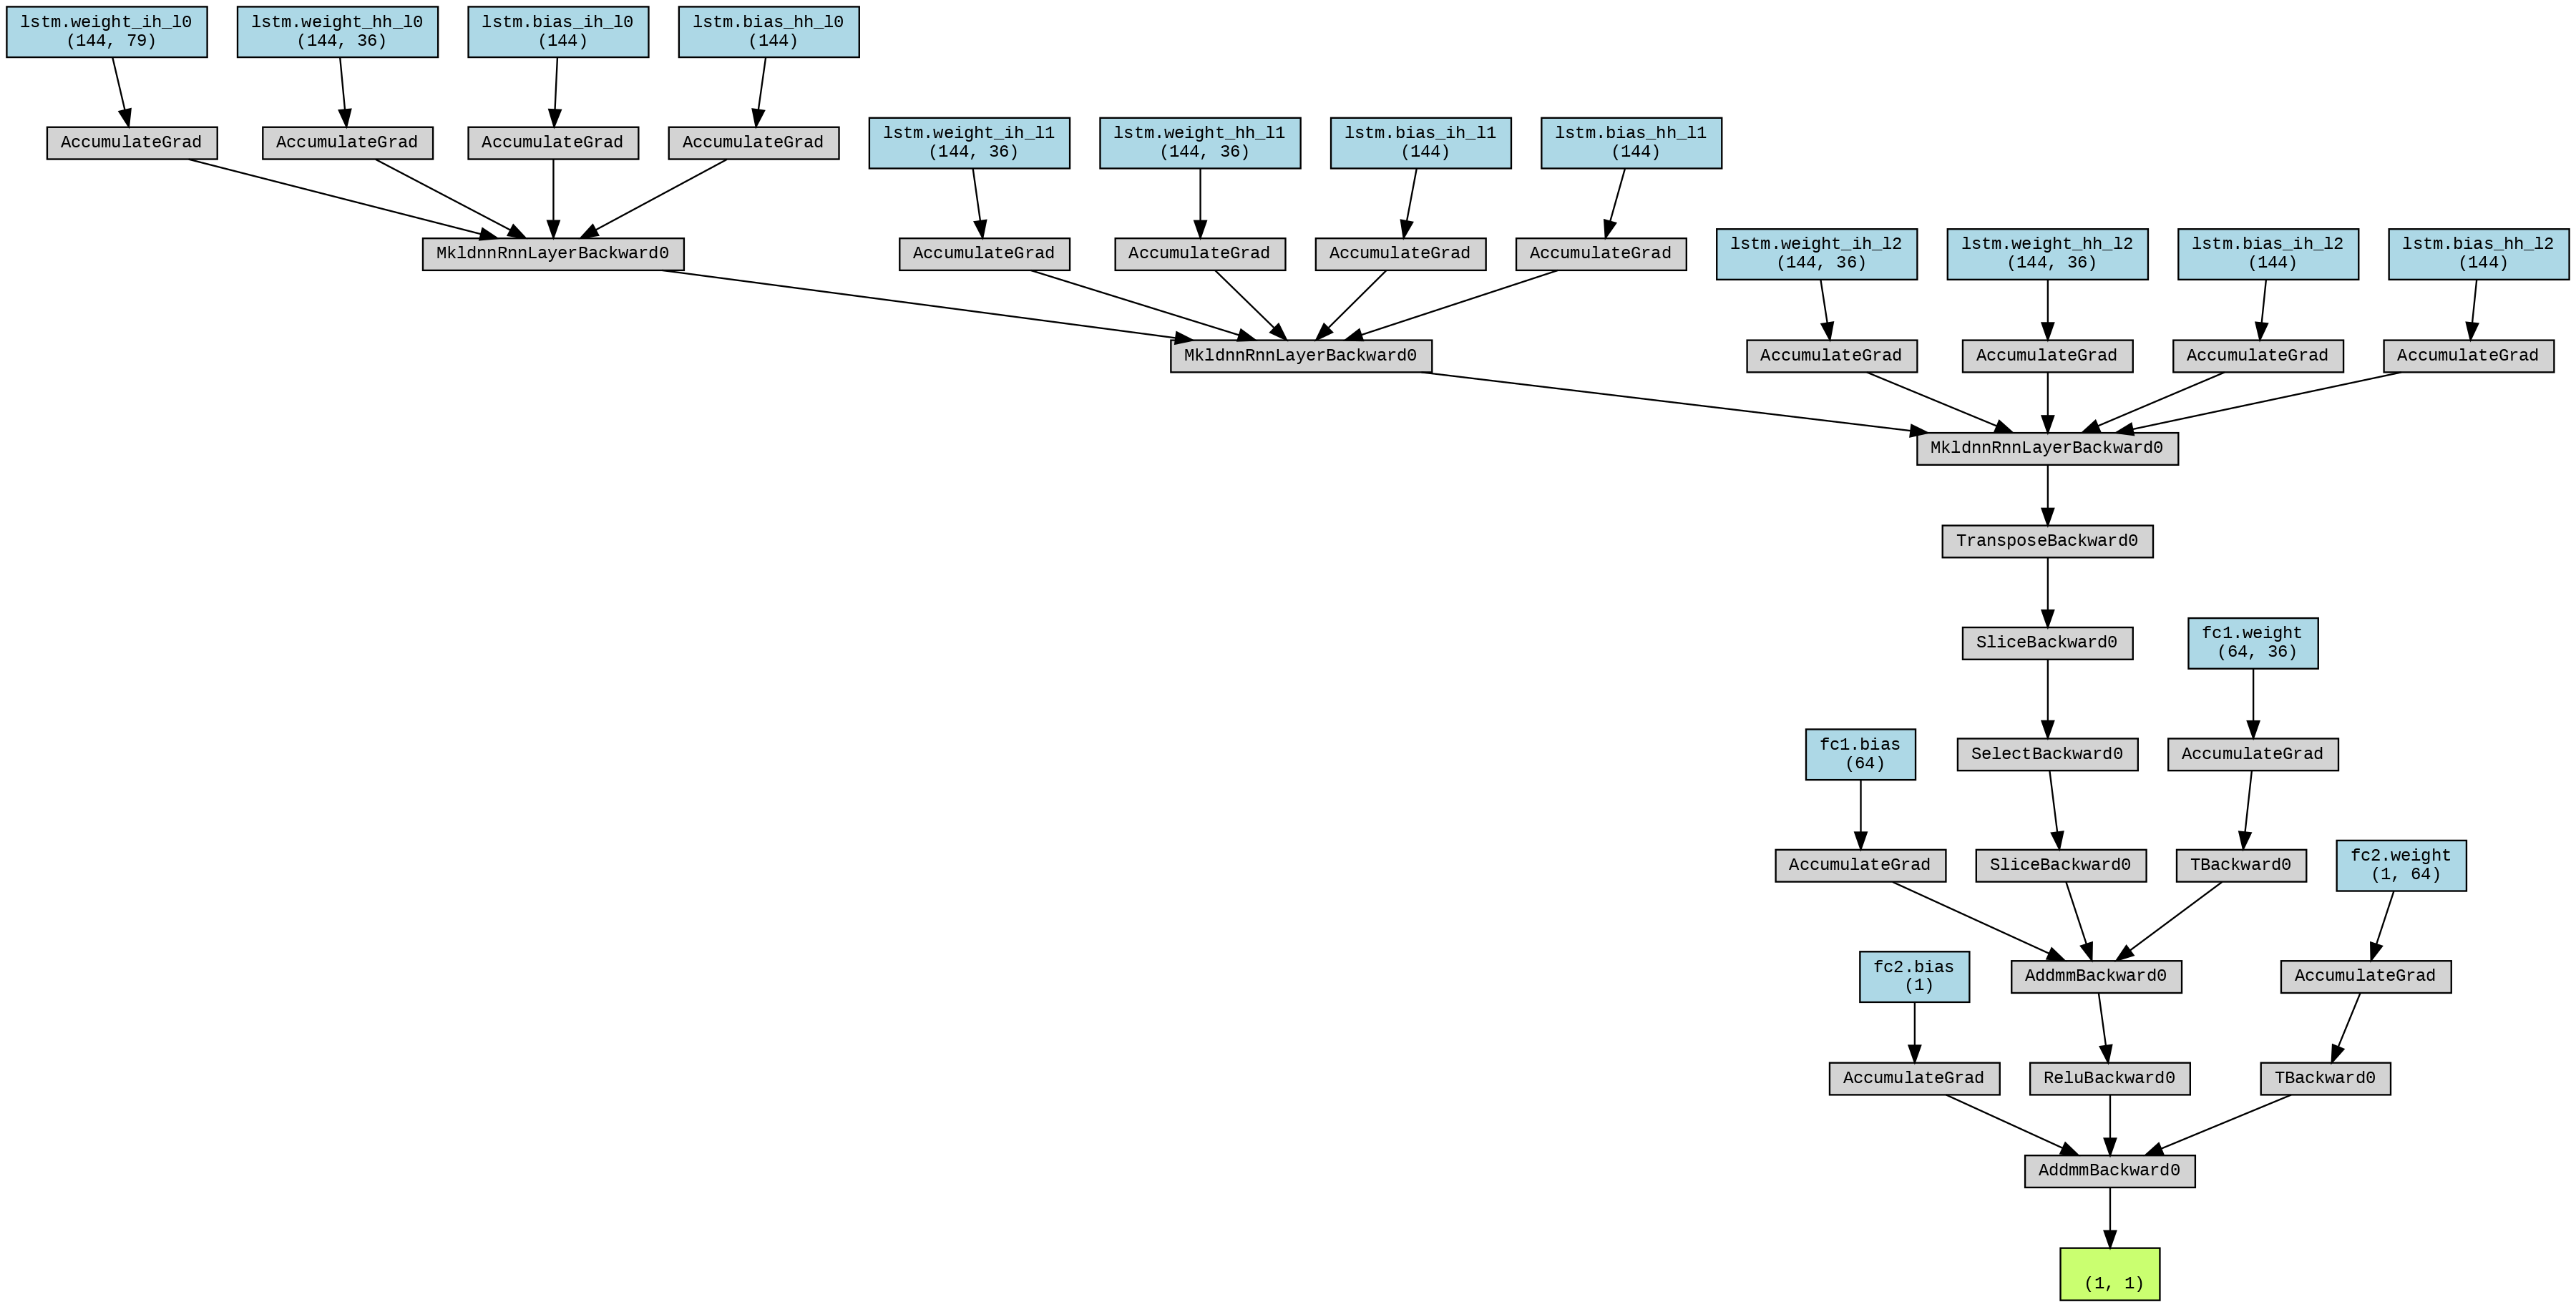

In [ ]:
from IPython.display import Image

Image(filename='/content/SpeedEstimatorRNN.png')

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter
writer = SummaryWriter('runs/SpeedEstimatorRNN', comment='Quality_Enhanced', max_queue=5, flush_secs=30)

# Add the model graph
writer.add_graph(model, x)

# Close the writer
writer.close()

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_areas(df_by_car, output_path):
    """
    Plot the area for each car type.

    Parameters:
    df_by_car (dict): Dictionary of DataFrames grouped by car type
    output_path (str): Path to save the plot images
    """
    for car, df in df_by_car.items():

        if 'speed' in df.columns:
          df.drop(columns=['speed'], inplace=True)

        plt.figure(figsize=(10, 6))

        for index, row in df.iterrows():
            label = index.split('_')[1]
            non_zero_values = row[row != 0]
            if not non_zero_values.empty:
                plt.plot(non_zero_values.index, non_zero_values.values, label=label)

        plt.ylabel('Area')
        plt.title(f'Area of {car}')
        plt.grid(True)
        plt.tight_layout()

        plt.gca().xaxis.set_visible(False)

        # plt.show()
        filename = f'{car}.jpg'
        filepath = os.path.join(output_path, filename)
        plt.savefig(filepath)
        plt.close()

# Example usage:
img_dir = 'images/area-change'
os.makedirs(img_dir, exist_ok=True)
plot_areas(df_by_car_area, img_dir)


## Plot Samples

In [ ]:
import os
import random
import matplotlib.pyplot as plt

def plot_samples(df_by_car, output_path):
    """
    Plot the area for each car type.

    Parameters:
    df_by_car (dict): Dictionary of DataFrames grouped by car type
    output_path (str): Path to save the plot images
    """
    for car, df in df_by_car.items():

        if 'speed' in df.columns:
            df.drop(columns=['speed'], inplace=True)

        plt.figure(figsize=(10, 6))

        # Randomly select 4 rows
        rows_to_plot = random.sample(list(df.index), min(4, len(df)))

        for index in rows_to_plot:
            row = df.loc[index]
            label = index.split('_')[1]
            non_zero_values = row[row != 0]
            if not non_zero_values.empty:
                plt.plot(non_zero_values.index, non_zero_values.values, label=f'{car}_{label}')

        plt.ylabel('Area')
        plt.title(f'Area of {car}')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()

        plt.gca().xaxis.set_visible(False)

        # Save the plot
        # plt.show()
        filename = f'{car}.jpg'
        filepath = os.path.join(output_path, filename)
        plt.savefig(filepath)
        plt.close()

# Example usage:
img_dir = 'images/samples'
os.makedirs(img_dir, exist_ok=True)
plot_samples(df_by_car_area, img_dir)


## Visualization for change in area

In [ ]:
df_diff = pd.read_csv('/content/df_final.csv', index_col=0)

In [ ]:
df_by_car_area_diff = {}

for car in set(index.split('_')[0] for index in df_diff.index):
    filtered_df = df_diff[df_diff.index.str.startswith(car)]

    # Filter out columns where all values are zero
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]

    # Store the filtered DataFrame in the dictionary
    df_by_car_area_diff[car] = filtered_df

for car, group_df in df_by_car_area_diff.items():
    print(f"DataFrame for car '{car}':")
    print(group_df.head(2))
    print('-----'*50)

In [ ]:
img_dir = 'images/area-difference-sample'
os.makedirs(img_dir, exist_ok=True)
plot_samples(df_by_car_area_diff, img_dir)

In [ ]:
img_dir = 'images/area-difference'
os.makedirs(img_dir, exist_ok=True)
plot_areas(df_by_car_area_diff, img_dir)

## Comparison between area and with actual-vs-pred

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

img_dir = Path('/content/images')
avp_img = list(img_dir.glob('actual-vs-pred/*.jpg'))

comp_dir = img_dir / 'comparison'
os.makedirs(comp_dir,  exist_ok=True)


# Set a higher dpi value for better image quality
dpi = 100

for img_path in avp_img:
    car = img_path.stem
    img = imread(img_path)
    area_img_path = img_dir / 'area-change' / f'{car}.jpg'
    area_img = imread(area_img_path)

    # Display images side by side with higher dpi
    plt.figure(figsize=(14, 7), dpi=dpi)

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Actual vs. Predicted')
    plt.axis('off')

    # Display area image
    plt.subplot(1, 2, 2)
    plt.imshow(area_img)
    plt.title('Area Change')
    plt.axis('off')

    plt.tight_layout()
    # plt.show()
    filename = f'{car}.jpg'
    filepath = os.path.join(comp_dir, filename)
    plt.savefig(filepath)
    plt.close()


## Zip all of them and Download

In [ ]:
import os
import zipfile

# Path to the root folder to include in the zip file
root_folder = '/content/'

# Path to the folder to be zipped
folder_to_zip = '/content/images'

# Path to save the zip file
zip_file_path = '/content/images.zip'

# Create a new zip file
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the folder structure
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            # Determine the arcname relative to the root folder
            arcname = os.path.relpath(file_path, root_folder)
            # Write the file to the zip with the desired arcname
            zipf.write(file_path, arcname=arcname)


In [ ]:
from google.colab import files

# Path to the zip file
zip_file_path = '/content/images.zip'

# Download the zip file
files.download(zip_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualizing the model

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot

class SpeedEstimatorRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpeedEstimatorRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last output of the LSTM
        out = nn.ReLU()(self.fc1(out))
        out = self.fc2(out)
        return out

model = SpeedEstimatorRNN(input_size=79, hidden_size=36, num_layers=3, output_size=1)
x = torch.randn(1, 10, 79)
y = model(x)

In [ ]:
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.graph_attr['dpi'] = '300'  # Set the DPI of the graph
dot.attr(size='12,12')  # Set the size of the figure
dot.render('SpeedEstimatorRNN')

'SpeedEstimatorRNN.png'

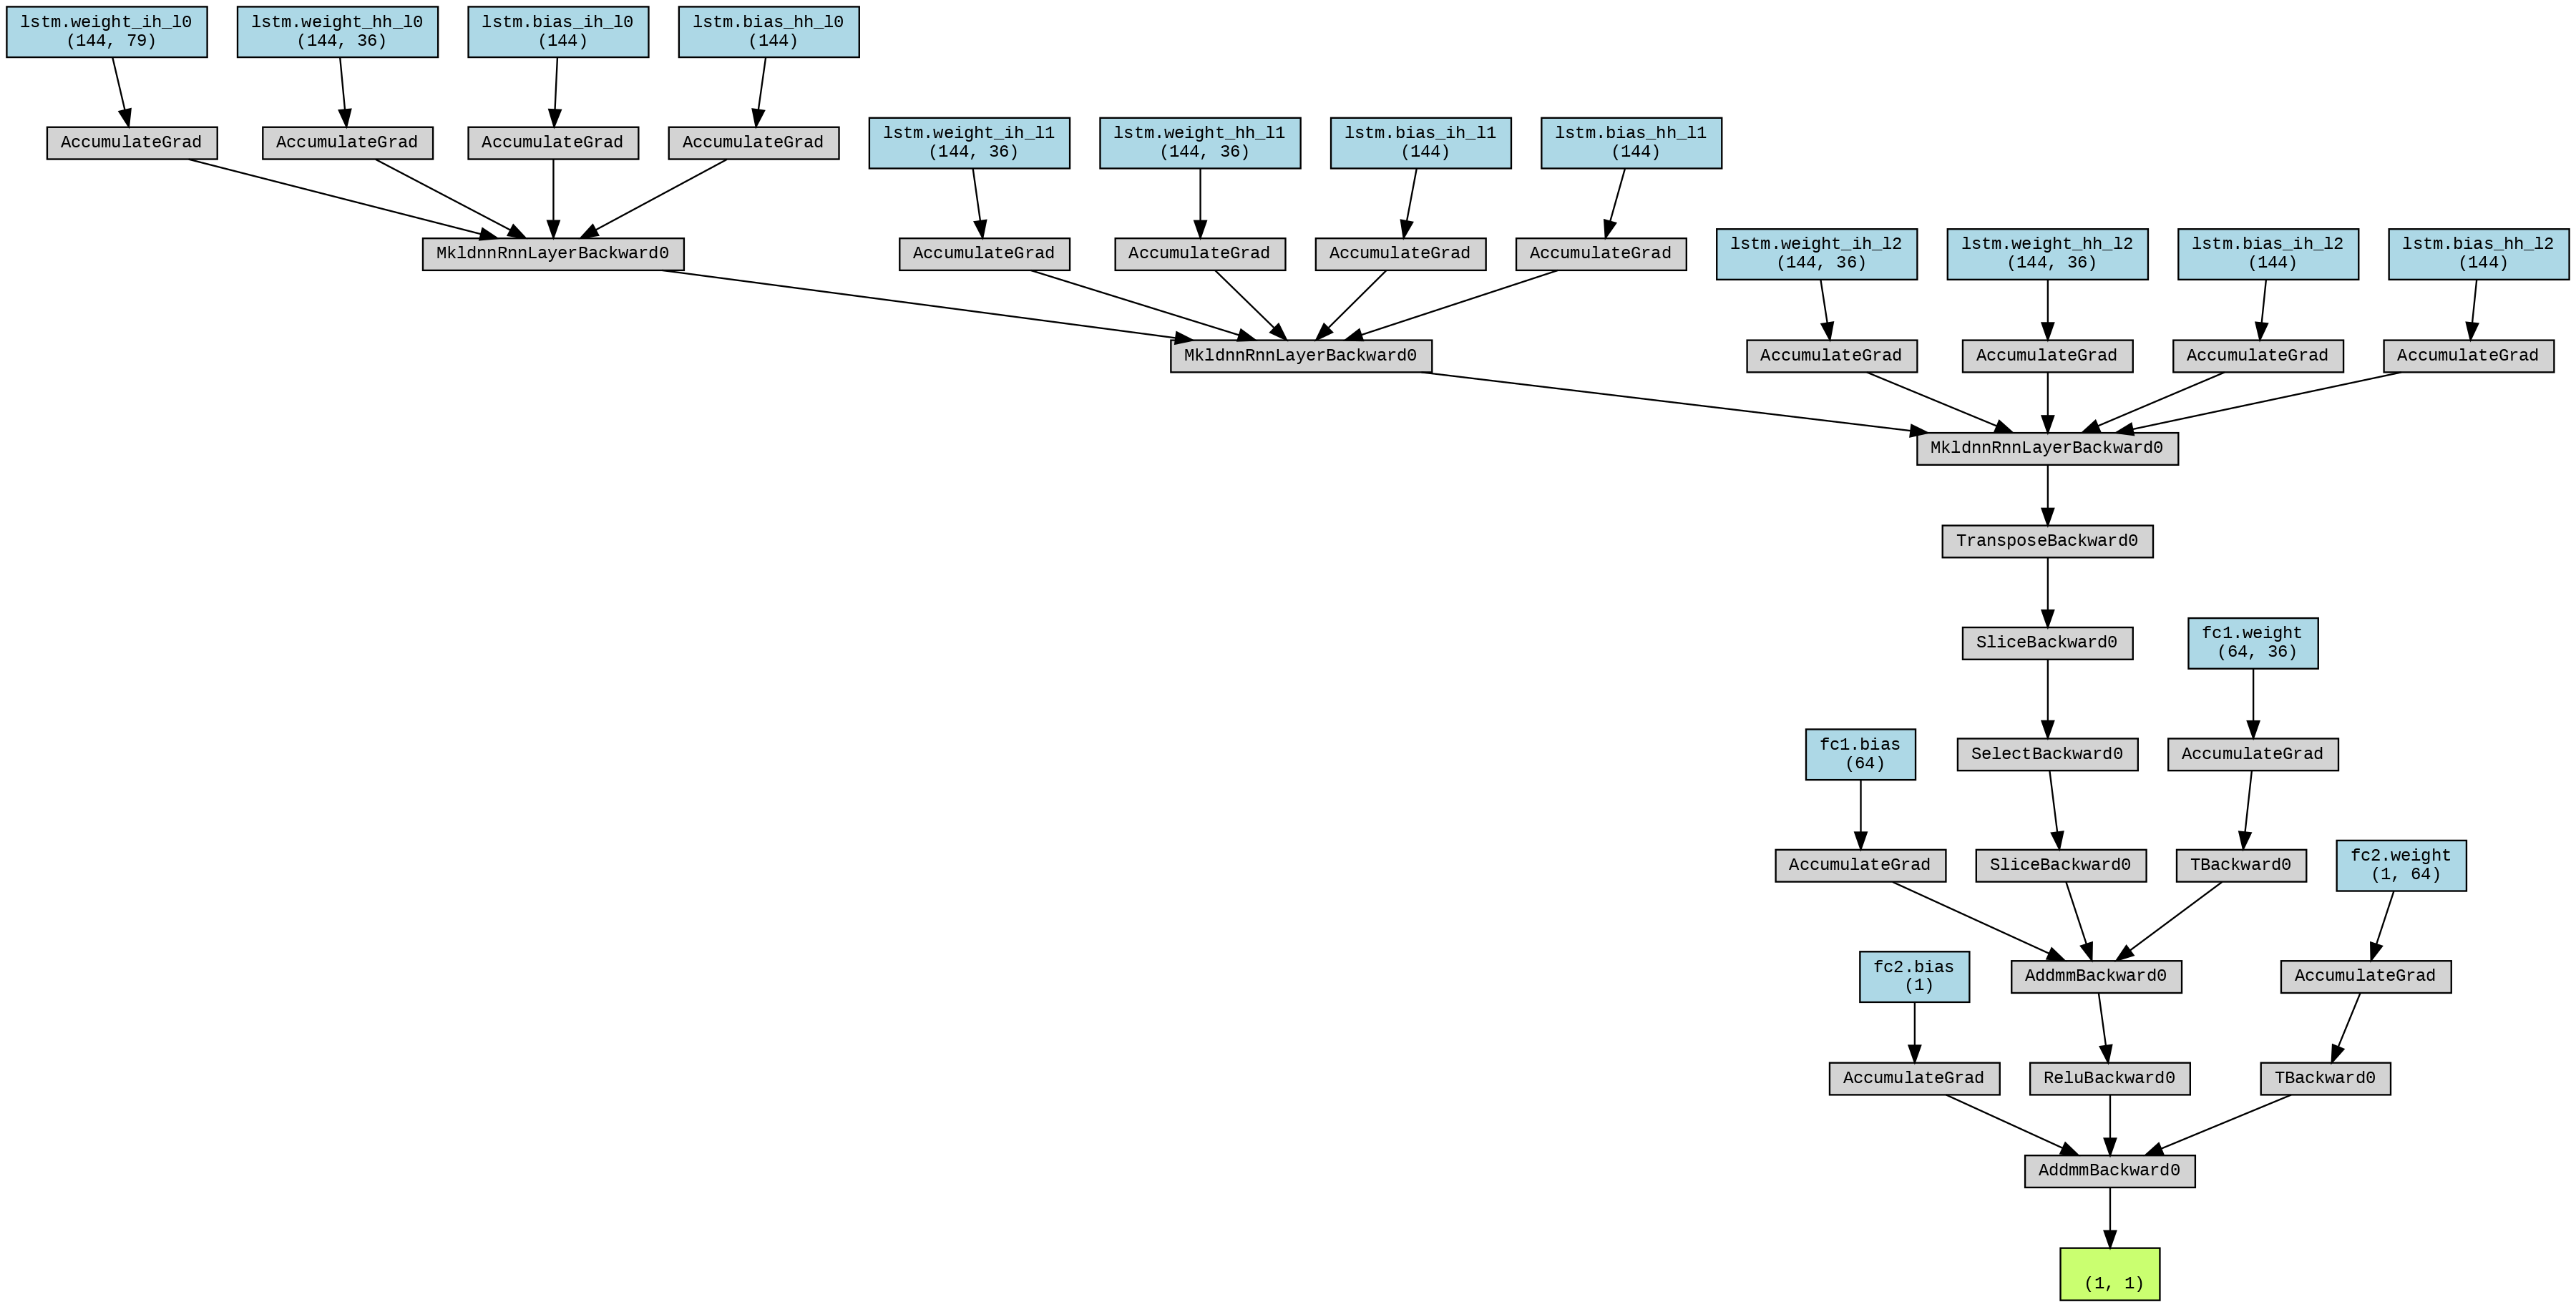

In [ ]:
from IPython.display import Image

Image(filename='/content/SpeedEstimatorRNN.png')

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter
writer = SummaryWriter('runs/SpeedEstimatorRNN', comment='Quality_Enhanced', max_queue=5, flush_secs=30)

# Add the model graph
writer.add_graph(model, x)

# Close the writer
writer.close()